# Libraries

In [9]:
import sys
sys.path.append('..')

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import pandas as pd
import graph_tool as gt
from tqdm import tqdm
from operator import itemgetter
from functools import reduce
import itertools
import scipy.sparse as sps
import random
import os
#from pymnet import *

import MuxVizPy as mxp

import gseapy as gp

import warnings
warnings.filterwarnings("ignore")


#set.seed(1)

# input data settings
NEIGH_ORDER = 1 # or 0, order of nerighbors, 0 only connected proteins, 1 also first neighbors
CUT_THR = 0.7   # don't change this one

target_folder = "../Data/Virus_data_Enriched_"+str(CUT_THR)+"_Neigh_"+str(NEIGH_ORDER)+"/"

# multilayer settings
layerCouplingStrength = 1
networkOfLayersType = "categorical" ## = all to all

#virus metadata
virus_metadata = pd.read_csv("../Data/Files/viruses_metadata.csv", header=0, sep=";")

virus_metadata_onco = virus_metadata[virus_metadata["isOncogenic"] == True].reset_index()
virus_metadata_nonco = virus_metadata[virus_metadata["isOncogenic"] == False].reset_index()

#dictionary containing a unquie mapping between name of the protein and a corresponding index
node_map_df = pd.read_csv("../Data/Files/node_map.csv")
node_map_dict = {k:(v-1) for k,v in zip(node_map_df["Prot"], node_map_df["Index"])}

#function to create list of n_iter combination of nonco virus indexes with a fixed random seed for repitibility
def SamplingForNoco(n_iter, start=0, group_dim=8, random_seed=1234):
    np.random.seed(random_seed)
    nonco_cond = np.where(np.all([np.array(virus_metadata["virus"]!="Human_SARS_coronavirus_2"),
                                  np.array(virus_metadata["virus_short"]!="Lymphocytic_choriomeningitis_virus"),
                                  np.array(virus_metadata["neigh_order"]==NEIGH_ORDER), 
                                  np.array(virus_metadata["isOncogenic"]==False)],
                                  axis=0))
    
    nonco_sampling = np.array([np.random.choice(nonco_cond[0], group_dim, replace=False) for i in range(n_iter+start)])
    return nonco_sampling[start:(n_iter+start)]

In [2]:
#M_agg_nx[M_agg_nx>1]=1
#G_agg_nx = nx.from_numpy_array(M_agg_nx)
#G_agg_nx

def entropy(G,tau):
    Ls = np.sort(nx.laplacian_spectrum(G))
    Z = np.sum(np.exp(-tau*Ls))
    p = np.exp(-tau*Ls)/Z
    #p=np.delete(p,np.where(p<10**-8))
    S = np.sum( -p * np.log2(p) )
    return S

#entropy(G_agg_nx, 0.1)

# ONCO

In [3]:
onco_virus_indexes = np.where(np.array(np.all([virus_metadata["neigh_order"]==NEIGH_ORDER, virus_metadata["isOncogenic"] == True], axis=0)))[0]
net_onco = mxp.VirusMultiplex(onco_virus_indexes, target_folder=target_folder, virus_metadata=virus_metadata)

for v in net_onco.virus_list:
    print(v)
    
print("\n"+net_onco.net_description)

Epstein-Barr_virus
Hepatitis_B_virus_genotype_C_subtype_ayr
Hepatitis_C_virus_genotype_1a
Human_herpesvirus_8_type_P
Human_papillomavirus_type_16
Human_papillomavirus_type_18
Human_papillomavirus_type_5
Human_T-cell_leukemia_virus_1

Multiplex with 8 layers, 11873 nodes and 2208041 edges


In [4]:
tensor_onco = mxp.build.get_node_tensor_from_network_list(net_onco.g_list)
layer_tensor_onco = mxp.build.build_layers_tensor(Layers=net_onco.Layers,
                                                  OmegaParameter=layerCouplingStrength, 
                                                  MultisliceType=networkOfLayersType
                                                  )
g_agg_onco = mxp.build.get_aggregate_network(obj=tensor_onco)

In [5]:
supra_onco = mxp.build.build_supra_adjacency_matrix_from_edge_colored_matrices(nodes_tensor=tensor_onco,
                                                                               layer_tensor=layer_tensor_onco,
                                                                               layers=net_onco.Layers,
                                                                               nodes=net_onco.Nodes)

trans_onco = mxp.build.build_supra_transition_matrix_from_supra_adjacency_matrix(supra=supra_onco,
                                                                                 layers=net_onco.Layers,
                                                                                 nodes=net_onco.Nodes)

In [33]:
resss = mxp.versatility.get_multi_RW_centrality_edge_colored(node_tensor=tensor_onco, cval=0.15)

In [7]:
mxp.build.create_supra_transition_matrix_virus(supra=supra_onco,
                                               node_tensor = tensor_onco,
                                               nodes = net_onco.Nodes,
                                               layers = net_onco.Layers)

<94984x94984 sparse matrix of type '<class 'numpy.float64'>'
	with 5080970 stored elements in COOrdinate format>

# Classification Data

In [68]:
#O1S
comb = list(itertools.combinations(range(8), 7))
Sars_onco_cond = np.where(np.array(np.all([virus_metadata["neigh_order"]==NEIGH_ORDER, virus_metadata["isOncogenic"] == True], axis=0)))[0]
Sars_pos = np.where(np.array(np.all([virus_metadata["neigh_order"]==NEIGH_ORDER, virus_metadata["virus"]=="Human_SARS_coronavirus_2"], axis=0)))[0][0]
o1s_virus_indexes = np.array([list(Sars_onco_cond[list(comb[i])])+[Sars_pos] for i in range(len(comb))])

#N1S
Snonco_nonco_samples = SamplingForNoco(500, group_dim=7, random_seed=4563)
Sars_pos = np.where(np.array(np.all([virus_metadata["neigh_order"]==NEIGH_ORDER, virus_metadata["virus"]=="Human_SARS_coronavirus_2"], axis=0)))[0][0]
n1s_virus_indexes = np.concatenate([Snonco_nonco_samples, np.repeat(Sars_pos,200).reshape([200,1])], axis=1)

#N1O
n1o_virus_indexes = []
n1o_sampling = SamplingForNoco(500, group_dim=7, random_seed=456)
for i in range(len(n1o_sampling)):
    onco_pick = np.random.choice(onco_virus_indexes)
    n1o_virus_indexes.append(np.concatenate([n1o_sampling[i], [onco_pick]]))

#N2O
n2o_virus_indexes = []
n2o_sampling = SamplingForNoco(500, group_dim=6, random_seed=17521)
for i in range(len(n2o_sampling)):
    onco_pick = np.random.choice(onco_virus_indexes, 2)
    n2o_virus_indexes.append(np.concatenate([n2o_sampling[i], onco_pick]))
    
#N3O
n3o_virus_indexes = []
n3o_sampling = SamplingForNoco(500, group_dim=5, random_seed=27521)
for i in range(len(n3o_sampling)):
    onco_pick = np.random.choice(onco_virus_indexes, 3)
    n3o_virus_indexes.append(np.concatenate([n3o_sampling[i], onco_pick]))

#N4O
n4o_virus_indexes = []
n4o_sampling = SamplingForNoco(200, group_dim=4, random_seed=796581)
for i in range(len(n4o_sampling)):
    onco_pick = np.random.choice(onco_virus_indexes, 4)
    n4o_virus_indexes.append(np.concatenate([n4o_sampling[i], onco_pick]))    

#N5O
n5o_virus_indexes = []
n5o_sampling = SamplingForNoco(500, group_dim=3, random_seed=37521)
for i in range(len(n5o_sampling)):
    onco_pick = np.random.choice(onco_virus_indexes, 5)
    n5o_virus_indexes.append(np.concatenate([n5o_sampling[i], onco_pick]))
    
#N6O
n6o_virus_indexes = []
n6o_sampling = SamplingForNoco(500, group_dim=2, random_seed=47521)
for i in range(len(n6o_sampling)):
    onco_pick = np.random.choice(onco_virus_indexes, 6)
    n6o_virus_indexes.append(np.concatenate([n6o_sampling[i], onco_pick]))
    
#O1N
comb = list(itertools.combinations(range(8), 7))
o1n_sampling = SamplingForNoco(500, group_dim=1, random_seed=12541).flatten()
o1n_virus_indexes = []
for i in range(len(onco_virus_indexes)):
    onco_samp = onco_virus_indexes[list(comb[i])]
    for j in range(len(o1n_sampling)):
        o1n_virus_indexes.append(np.concatenate([onco_samp, [o1n_sampling[j]]]))
        
o1n_virus_indexes = random.sample(o1n_virus_indexes, 200)
        
#N
n_virus_indexes = SamplingForNoco(200, random_seed=41252145)


########################################################################

#N1O1S
n1o1s_virus_indexes = []
n1o1s_sampling = SamplingForNoco(400, group_dim=6, random_seed=783)
for i in range(len(n1o1s_sampling)):
    onco_pick = np.random.choice(onco_virus_indexes)
    n1o1s_virus_indexes.append(np.concatenate([n1o1s_sampling[i], [onco_pick], [Sars_pos]]))
    
#N2O1S
n2o1s_virus_indexes = []
n2o1s_sampling = SamplingForNoco(400, group_dim=5, random_seed=154)
for i in range(len(n2o1s_sampling)):
    onco_pick = np.random.choice(onco_virus_indexes,2)
    n2o1s_virus_indexes.append(np.concatenate([n2o1s_sampling[i], onco_pick, [Sars_pos]]))
    
#N3O1S
n3o1s_virus_indexes = []
n3o1s_sampling = SamplingForNoco(400, group_dim=4, random_seed=118)
for i in range(len(n1o1s_sampling)):
    onco_pick = np.random.choice(onco_virus_indexes,3)
    n3o1s_virus_indexes.append(np.concatenate([n3o1s_sampling[i], onco_pick, [Sars_pos]]))
    
#N4O1S
n4o1s_virus_indexes = []
n4o1s_sampling = SamplingForNoco(400, group_dim=3, random_seed=11124)
for i in range(len(n1o1s_sampling)):
    onco_pick = np.random.choice(onco_virus_indexes,4)
    n4o1s_virus_indexes.append(np.concatenate([n4o1s_sampling[i], onco_pick, [Sars_pos]]))
    
#N5O1S
n5o1s_virus_indexes = []
n5o1s_sampling = SamplingForNoco(400, group_dim=2, random_seed=9874)
for i in range(len(n1o1s_sampling)):
    onco_pick = np.random.choice(onco_virus_indexes,5)
    n5o1s_virus_indexes.append(np.concatenate([n5o1s_sampling[i], onco_pick, [Sars_pos]]))

In [69]:
index_lists = [n1s_virus_indexes, 
               n1o_virus_indexes, 
               n2o_virus_indexes, 
               n3o_virus_indexes,
               n4o_virus_indexes, 
               n5o_virus_indexes, 
               n6o_virus_indexes, 
               o1n_virus_indexes, 
               n_virus_indexes,
               n1o1s_virus_indexes,
               n2o1s_virus_indexes,
               n3o1s_virus_indexes,
               n4o1s_virus_indexes,
               n5o1s_virus_indexes]

names_lists=["n1s", "n1o", "n2o", "n3o", "n4o", "n5o", "n6o", "o1n", "n", "n1o1s", "n2o1s", "n3o1s", "n4o1s", "n5o1s"]

In [ ]:
net = net_onco

for i in range(183,400):
    print(i)
    for nam, lst in tqdm(zip(names_lists, index_lists)):
        if not os.path.isdir("../Data/ClassificationData/topology/"+nam):
            os.mkdir("../Data/ClassificationData/topology/"+nam)
        if not os.path.isdir("../Data/ClassificationData/pathways/"+nam):
            os.mkdir("../Data/ClassificationData/pathways/"+nam)
        if not os.path.isdir("../Data/ClassificationData/top50nodes/"+nam):
            os.mkdir("../Data/ClassificationData/top50nodes/"+nam)
        
        net = mxp.VirusMultiplex(lst[i], target_folder=target_folder, virus_metadata=virus_metadata)
        tensor = mxp.build.get_node_tensor_from_network_list(net.g_list)
        
        
        res_df = mxp.versatility.get_multi_RW_centrality_edge_colored(node_tensor=tensor, cval=0.15)
        

        list_res = np.array(list(net.node_map.keys()))[res_df.sort_values("vers", ascending=False).index[:50]]

        #np.savetxt(X=list_res, fname="../Data/ClassificationData/top50nodes/"+nam+"/"+str(i)+".txt", fmt="%s")

        #enr_lvc = gp.enrichr(gene_list="../Data/ClassificationData/top50nodes/"+nam+"/"+str(i)+".txt", # or "./tests/data/gene_list.txt",
        #                    gene_sets=['KEGG_2021_Human'],
        #                    organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
        #                    outdir=None, # don't write to disk
        #                    )

        #enr_lvc.results[enr_lvc.results["Adjusted P-value"]<0.05].sort_values("Adjusted P-value")[["Term", "Overlap", "Adjusted P-value"]].to_csv("../Data/ClassificationData/pathways/"+nam+"/"+str(i)+".csv", index=False)

        centr_norm = np.zeros(len(node_map_dict))
        centr_norm[np.array(itemgetter(*list(net.node_map.keys()))(node_map_dict))] = res_df["vers"].to_numpy()
        centr_norm=centr_norm/max(centr_norm)
        
        np.savetxt(X=centr_norm, fname="../Data/ClassificationData/topology/"+nam+"/"+str(i)+".txt", fmt="%.6f")

183


14it [01:07,  4.84s/it]


184


14it [01:16,  5.44s/it]


185


14it [01:12,  5.17s/it]


186


14it [01:12,  5.17s/it]


187


14it [01:19,  5.66s/it]


188


14it [01:07,  4.84s/it]


189


14it [01:01,  4.36s/it]


190


14it [01:11,  5.13s/it]


191


14it [01:14,  5.30s/it]


192


14it [01:06,  4.75s/it]


193


14it [01:09,  4.94s/it]


194


14it [01:15,  5.37s/it]


195


14it [01:11,  5.07s/it]


196


10it [00:39,  4.52s/it]

In [299]:
def multi_custom_walk(supra, nodes, layers, walk_len=500, p_intra=0.5, starting_node="", random_seed=False):
    if random_seed!=False:
        np.random.seed(random_seed)
    
    if starting_node=="":
        starting_node=np.random.choice(nodes*layers)
    nodes_time = [starting_node-((starting_node//nodes)*nodes)]
    layer_time = [starting_node//nodes]

    for i in range(walk_len):
        non_zero_indexes = supra[starting_node].toarray()[0].nonzero()[0]
        non_zero_weights = supra[starting_node].toarray()[0][non_zero_indexes]

        interL_links_indexes = np.where(np.logical_not((non_zero_indexes//nodes)==(starting_node//nodes)))[0]
        intraL_links_indexes = np.where((non_zero_indexes//nodes)==(starting_node//nodes))[0]
        interlayer_nodes = non_zero_indexes[interL_links_indexes]
        
        interL_fut_weights = np.array([supra[iL].sum()-7 for iL in interlayer_nodes])

        
        if sum(interL_fut_weights)!=0:
            interL_fut_weights = interL_fut_weights/sum(interL_fut_weights)
            non_zero_weights[intraL_links_indexes] = p_intra*non_zero_weights[intraL_links_indexes]/sum(non_zero_weights[intraL_links_indexes])
            non_zero_weights[interL_links_indexes] = interL_fut_weights*(1-p_intra)
        else:
            non_zero_weights[interL_links_indexes] = [0]*len(interL_links_indexes)
        
        trans_prob = non_zero_weights/sum(non_zero_weights)

        new_node = np.random.choice(non_zero_indexes, p=trans_prob)
        nodes_time.append(new_node)#-((new_node//nodes)*nodes))
        layer_time.append(new_node//nodes)

        starting_node = new_node

    nodes_time = np.array(nodes_time)
    layer_time = np.array(layer_time)
    walk_df = pd.DataFrame({"time": np.arange(walk_len+1), "node":nodes_time, "layer": layer_time})
    
    #Statistics
    layer_counts = walk_df["layer"].value_counts().values
    layer_probs = pd.DataFrame({"layer":walk_df["layer"].value_counts().index, 
                                "prob":layer_counts/sum(layer_counts)})
    
    node_counts = walk_df["node"].value_counts().values
    node_idx = np.array(walk_df["node"].value_counts().index)
    node_probs = pd.DataFrame({"rep_node": node_idx, 
                               "prob":node_counts/sum(node_counts),
                               "phy_node": node_idx-((node_idx//nodes)*nodes),
                               "layer": node_idx//nodes})
    
    return {"data": walk_df, "layer_prob": layer_probs, "node_prob": node_probs}

In [333]:
my_walk = multi_custom_walk(supra=supra_onco,
                            nodes=net_onco.Nodes,
                            layers=net_onco.Layers,
                            walk_len=100000
                            )

In [334]:
my_walk["layer_prob"]

,layer,prob
0,2,0.212538
1,0,0.208788
2,3,0.188478
3,4,0.172118
4,1,0.144299
5,7,0.037350
6,5,0.036170
7,6,0.000260


In [451]:
my_walk["node_prob"]#.groupby("phy_node").sum().sort_values("prob", ascending=False)

,rep_node,prob,phy_node,layer
0,6313,0.00045,6313,0
1,7540,0.00044,7540,0
2,19486,0.00042,7613,1
3,55712,0.00041,8220,4
4,31251,0.00040,7505,2
...,...,...,...,...
26494,24236,0.00001,490,2
26495,38557,0.00001,2938,3
26496,3763,0.00001,3763,0
26497,41975,0.00001,6356,3


<AxesSubplot: xlabel='time', ylabel='node'>

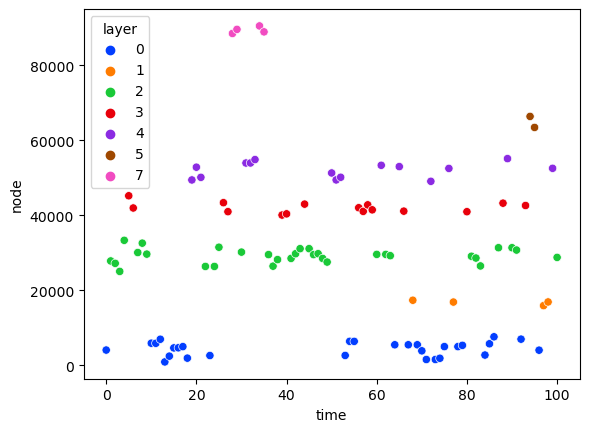

In [277]:
sns.scatterplot(my_walk, x="time", y="node", hue="layer", palette="bright", markers="-")

## Mod

In [ ]:
onco_modules, onco_modularity, onco_state = mxp.mesoscale.get_mod(net_onco.g_multi, n_iter=1, return_state=True)

In [ ]:
"""
for i in range(1000):
    net_onco = VirusMultiplex(onco_virus_indexes)
    onco_modules, onco_modularity = mxp.inference.get_mod(n_iter=1)   
    mods_list = np.loadtxt("Files/Mod/onco_mods_short.txt")
    mody_list = np.loadtxt("Files/Mod/onco_mody_short.txt")
    np.savetxt(X=np.concatenate([mods_list,onco_modules]), fname="Files/Mod/onco_mods_short.txt", fmt="%d")
    np.savetxt(X=np.concatenate([mody_list,onco_modularity]), fname="Files/Mod/onco_mody_short.txt", fmt="%.7f")
"""

## Components

In [76]:
onco_lcc = mxp.topology.get_multi_LCC(net_onco.g_list)
onco_lic = mxp.topology.get_multi_LIC(net_onco.g_list)
onco_lvc = mxp.topology.get_multi_LVC(net_onco.g_list, printt=False)

print("COMPONENTS")
print("   LCC size: %d" % (len(onco_lcc)))
print("   LIC size: %d" % (len(onco_lic)))
print("   LVC size: %d" % (len(onco_lvc)))

COMPONENTS
   LCC size: 11873
   LIC size: 30
   LVC size: 30


## Percolation

In [62]:
onco_perc = mxp.percolation.get_percolation(net_onco.g_list, 
                                        layers=net_onco.Layers, 
                                        nodes=net_onco.Nodes, 
                                        method="pagerank")

print(onco_perc["CritPoint"])

0.3023667143940032


In [60]:
print("Perc")
onco_perc = mxp.percolation.get_percolation(net_onco.g_list, 
                                            layers=net_onco.Layers, 
                                            nodes=net_onco.Nodes, 
                                            method="betweenness")
onco_perc["CritPoint"]

Perc


0.3597237429461804

In [61]:
print("Perc")
onco_perc = mxp.percolation.get_percolation(net_onco.g_list, 
                                            layers=net_onco.Layers, 
                                            nodes=net_onco.Nodes, 
                                            method="pagerank")
onco_perc["CritPoint"]

Perc


0.3023667143940032

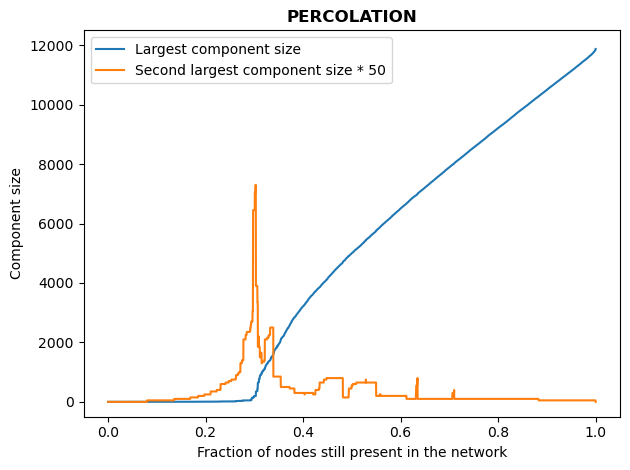

In [64]:
x = np.arange(len(onco_perc["1ComponentSize"]))/len(onco_perc["1ComponentSize"])
plt.plot(x, onco_perc["1ComponentSize"], label="Largest component size")
plt.plot(x, onco_perc["2ComponentSize"]*50, label="Second largest component size * 50")
#plt.vlines(onco_perc["CritPoint"], -500, 15000, ls="--", color="green", label=f"Critical point: {np.round(onco_perc["CritPoint"],4)}")
plt.ylim([-500,12500])
plt.legend()
plt.title("PERCOLATION", fontweight="bold")
plt.xlabel("Fraction of nodes still present in the network")
plt.ylabel("Component size")
plt.tight_layout()

## Centrality

In [84]:
pr_centr = mxp.versatility.get_multi_RW_centrality(supra=supra_onco, 
                                                   layers=net_onco.Layers, 
                                                   nodes=net_onco.Nodes, 
                                                   Type="pagerank")
keys = list(node_map_dict.keys())
keys_net = list(net_onco.node_map.keys())

centr_norm = np.zeros(len(node_map_dict))
centr_dict = dict(zip(keys_net, pr_centr))

for i,c in enumerate(keys):
    if c in keys_net:
        centr_norm[i]=centr_dict[c]
centr_norm=centr_norm/max(centr_norm)


Reached convergence


In [33]:
eig_centr_onco = mxp.versatility.get_multi_eigenvector_centrality(supra=supra_onco, layers=net_onco.Layers, nodes=net_onco.Nodes)

In [8]:
katz_onco = mxp.versatility.get_multi_katz_centrality(supra_onco, net_onco.Layers, net_onco.Nodes)

Reached convergence


In [ ]:
pr_centr_onco = mxp.versatility.get_multi_RW_centrality(supra=supra_onco, 
                                                        layers=net_onco.Layers, 
                                                        nodes=net_onco.Nodes, 
                                                        Type="pagerank")

In [37]:
cla_centr_onco = mxp.versatility.get_multi_RW_centrality(supra=supra_onco, 
                                                        layers=net_onco.Layers, 
                                                        nodes=net_onco.Nodes, 
                                                        Type="classical")

In [38]:
deg_centr_onco = mxp.versatility.get_multi_degree(supra=supra_onco, 
                                                        layers=net_onco.Layers, 
                                                        nodes=net_onco.Nodes)

In [17]:
hub_centr_onco = mxp.versatility.get_multi_hub_centrality(supra=supra_onco, 
                                                        layers=net_onco.Layers, 
                                                        nodes=net_onco.Nodes)

Reached convergence


In [40]:
auth_centr_onco = mxp.versatility.get_multi_auth_centrality(supra=supra_onco, 
                                                        layers=net_onco.Layers, 
                                                        nodes=net_onco.Nodes)

Reached convergence


In [ ]:
eig_c = np.array(list(net_onco.node_map.keys()))[np.argsort(eig_centr_onco)[::-1]]
eig_c_lic_onco = np.where(np.isin(eig_c, onco_lic_prot))

pr_c = np.array(list(net_onco.node_map.keys()))[np.argsort(pr_centr_onco)[::-1]]
pr_c_lic_onco = np.where(np.isin(pr_c, onco_lic_prot))

cla_c = np.array(list(net_onco.node_map.keys()))[np.argsort(cla_centr_onco)[::-1]]
cla_c_lic_onco = np.where(np.isin(cla_c, onco_lic_prot))

deg_c = np.array(list(net_onco.node_map.keys()))[np.argsort(deg_centr_onco)[::-1]][0]
deg_c_lic_onco = np.where(np.isin(deg_c, onco_lic_prot))

hub_c = np.array(list(net_onco.node_map.keys()))[np.argsort(hub_centr_onco)[::-1]]
hub_c_lic_onco = np.where(np.isin(hub_c, onco_lic_prot))

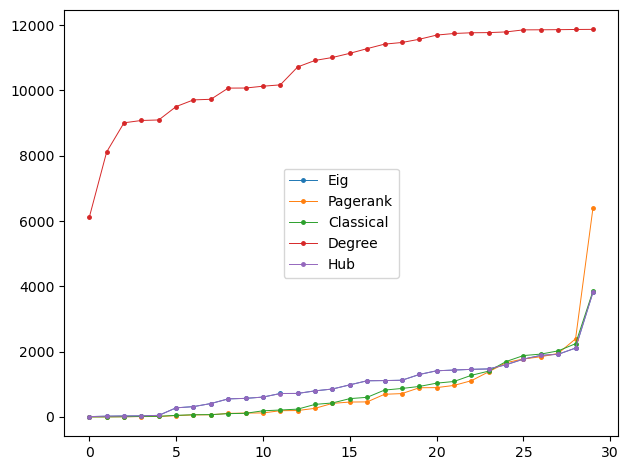

In [40]:
plt.plot(np.arange(len(onco_lic_prot)), eig_c_lic_onco[0], ".-", markersize=5, lw=0.7, label="Eig")
plt.plot(np.arange(len(onco_lic_prot)), pr_c_lic_onco[0], ".-", markersize=5, lw=0.7, label="Pagerank")
plt.plot(np.arange(len(onco_lic_prot)), cla_c_lic_onco[0], ".-", markersize=5, lw=0.7, label="Classical")
plt.plot(np.arange(len(onco_lic_prot)), deg_c_lic_onco[0], ".-", markersize=5, lw=0.7, label="Degree")
plt.plot(np.arange(len(onco_lic_prot)), hub_c_lic_onco[0], ".-", markersize=5, lw=0.7, label="Hub")
plt.legend()
plt.tight_layout()

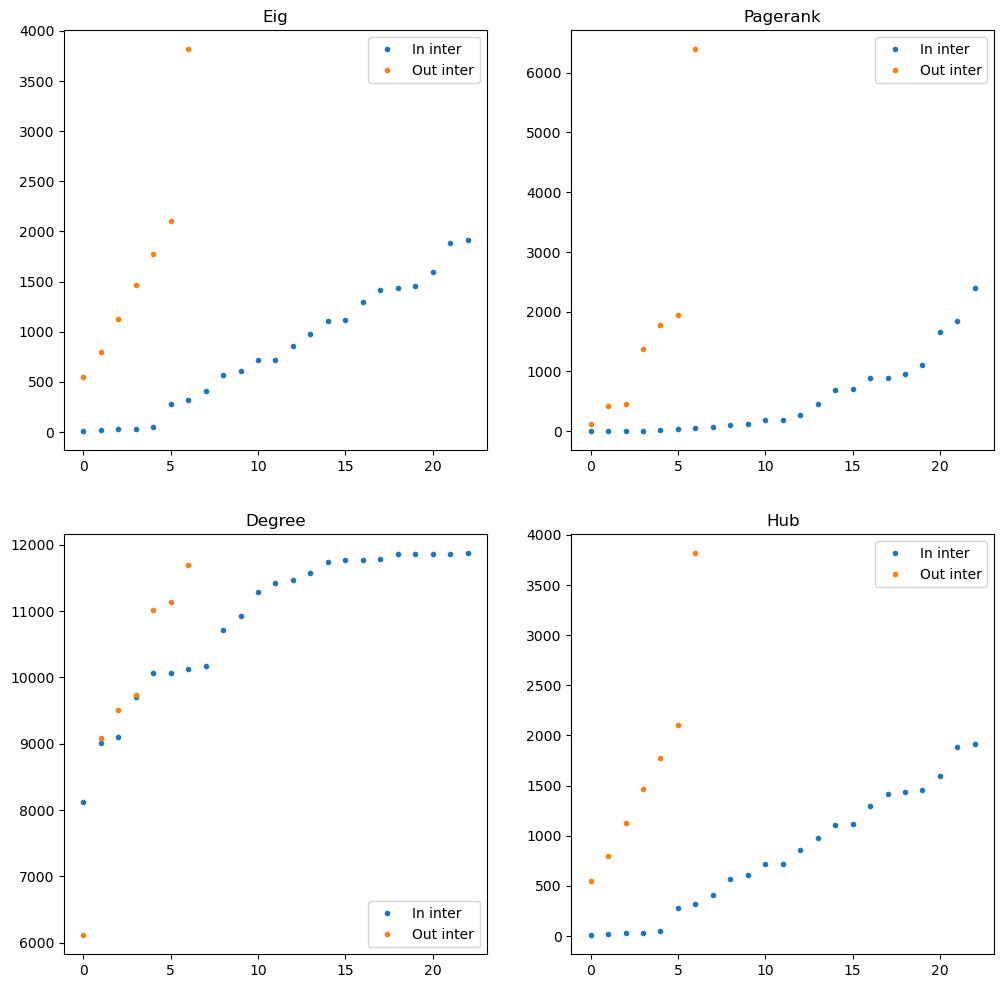

In [111]:
_, ax = plt.subplots(2,2,figsize=(12,12))
ax = ax.flatten()
centr_dict = {"Eig":eig_c, "Pagerank":pr_c, "Degree": deg_c, "Hub":hub_c}
for i in range(4):
    name = list(centr_dict.keys())[i]
    ax[i].plot(np.where(np.isin(centr_dict[name], onco_in_nonco_lic))[0], ".", label="In inter")
    ax[i].plot(np.where(np.isin(centr_dict[name], onco_notin_nonco_lic))[0], ".", label="Out inter")
    ax[i].set_title(name)
    ax[i].legend()

## Enrichment Analysis

In [6]:
nodes_list = np.array(list(net_onco.node_map.keys()))[onco_lvc]

In [8]:
np.savetxt(fname="nodes_list.txt", X=nodes_list, fmt="%s")

In [14]:
enr_lvc = gp.enrichr(gene_list="nodes_list.txt", # or "./tests/data/gene_list.txt",
                 gene_sets=['MSigDB_Hallmark_2020','KEGG_2021_Human'],
                 organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None, # don't write to disk
                )

In [11]:
cancer_pathways = ["PPAR signaling pathway" ,"MAPK signaling pathway" ,"Calcium signaling pathway" ,"cAMP signaling pathway" ,"Cytokine-cytokine receptor interaction" ,"HIF-1 signaling pathway" ,"Cell cycle" ,"p53 signaling pathway" ,"mTOR signaling pathway" ,"PI3K-Akt signaling pathway" ,"Apoptosis" ,"Wnt signaling pathway" ,"Notch signaling pathway" ,"Hedgehog signaling pathway" ,"TGF-beta signaling pathway" ,"VEGF signaling pathway" ,"Focal adhesion" ,"ECM-receptor interaction" ,"Adherens junction" ,"JAK-STAT signaling pathway" ,"Estrogen signaling pathway"]

In [10]:
enr_lvc.results[enr_lvc.results["Term"].isin(cancer_pathways)]

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
14,MSigDB_Hallmark_2020,Apoptosis,1/161,2.154566e-01,0.260462,0,0,4.269397,6.553505,CREBBP
19,KEGG_2021_Human,Cell cycle,6/124,2.642907e-08,0.000002,0,0,42.059322,733.884750,SMAD2;CREBBP;SMAD3;MDM2;ABL1;TP53
21,KEGG_2021_Human,p53 signaling pathway,5/73,7.480064e-08,0.000002,0,0,58.535294,960.472825,MDM2;MDM4;PPM1D;TP53;TP73
29,KEGG_2021_Human,Wnt signaling pathway,4/166,1.059834e-04,0.000858,0,0,18.811016,172.162708,CREBBP;SMAD3;CTBP1;TP53
33,KEGG_2021_Human,TGF-beta signaling pathway,3/94,3.723029e-04,0.002209,0,0,24.272283,191.649164,SMAD2;CREBBP;SMAD3
39,KEGG_2021_Human,Apoptosis,3/142,1.236194e-03,0.005239,0,0,15.852118,106.141318,DAXX;PARP1;TP53
49,KEGG_2021_Human,Notch signaling pathway,2/59,3.529054e-03,0.010132,0,0,24.953634,140.906322,CREBBP;CTBP1
51,KEGG_2021_Human,Adherens junction,2/71,5.068659e-03,0.013634,0,0,20.601449,108.872045,CREBBP;SMAD3
54,KEGG_2021_Human,MAPK signaling pathway,3/294,9.519388e-03,0.023534,0,0,7.513937,34.973052,DAXX;MAP3K1;TP53
64,KEGG_2021_Human,JAK-STAT signaling pathway,2/162,2.445216e-02,0.047310,0,0,8.843750,32.819482,CREBBP;PIAS1


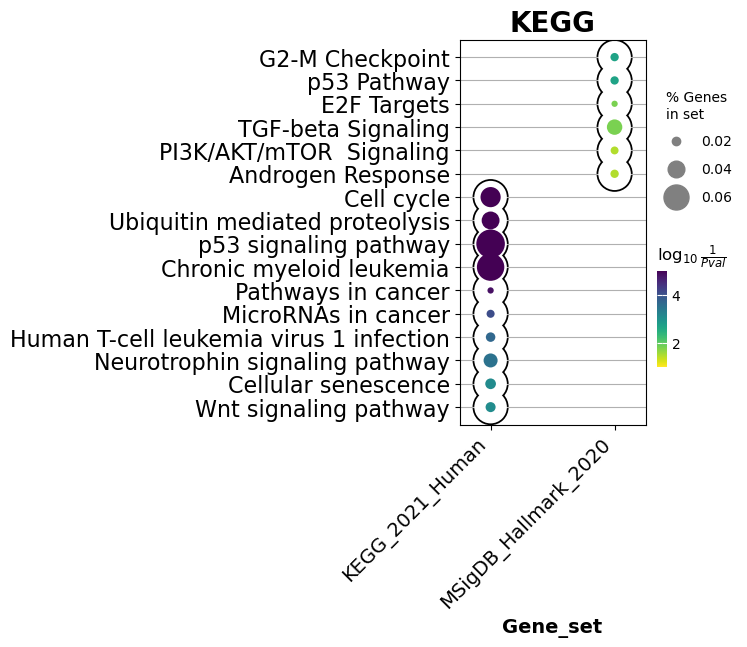

In [57]:
ax = gp.dotplot(enr_lvc.results,
              column="Adjusted P-value",
              x='Gene_set', # set x axis, so you could do a multi-sample/library comparsion
              size=50,
              top_term=10,
              figsize=(3,5),
              title = "KEGG",
              xticklabels_rot=45, # rotate xtick labels
              show_ring=True, # set to False to revmove outer ring
              marker='o',
             )

In [53]:
np.savetxt(X=eig_c[:100], fname="eig_onco_100.txt", fmt="%s")

In [58]:
enr_eig_100 = gp.enrichr(gene_list="eig_onco_100.txt", # or "./tests/data/gene_list.txt",
                 gene_sets=['MSigDB_Hallmark_2020','KEGG_2021_Human'],
                 organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None, # don't write to disk
                )

In [59]:
enr_eig_100.results.sort_values("P-value").head(5)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
31,KEGG_2021_Human,Ubiquitin mediated proteolysis,55/140,7.103030e-96,6.534788e-94,0,0,284.921569,62422.796188,UBE2D2;UBE2D3;KEAP1;UBE2D1;UBE3A;UBE2L6;BRCA1;...
32,KEGG_2021_Human,Cell cycle,18/124,1.022922e-21,4.705442e-20,0,0,40.990796,1981.151727,ANAPC7;CUL1;ANAPC10;RBX1;ANAPC11;CDC20;FZR1;CD...
33,KEGG_2021_Human,Oocyte meiosis,17/129,8.271943e-20,2.536729e-18,0,0,36.187177,1590.022317,ANAPC7;FBXW11;CUL1;ANAPC10;RBX1;ANAPC11;CDC20;...
34,KEGG_2021_Human,Progesterone-mediated oocyte maturation,12/100,9.039991e-14,2.079198e-12,0,0,30.700413,922.072576,FZR1;CDC23;ANAPC7;CDC26;CDC27;CDC16;ANAPC4;ANA...
35,KEGG_2021_Human,Shigellosis,15/246,1.455569e-12,2.678246e-11,0,0,15.025974,409.542306,FBXW11;UBE2D2;UBE2D3;CUL1;UBE2D1;RBX1;UBB;UBC;...


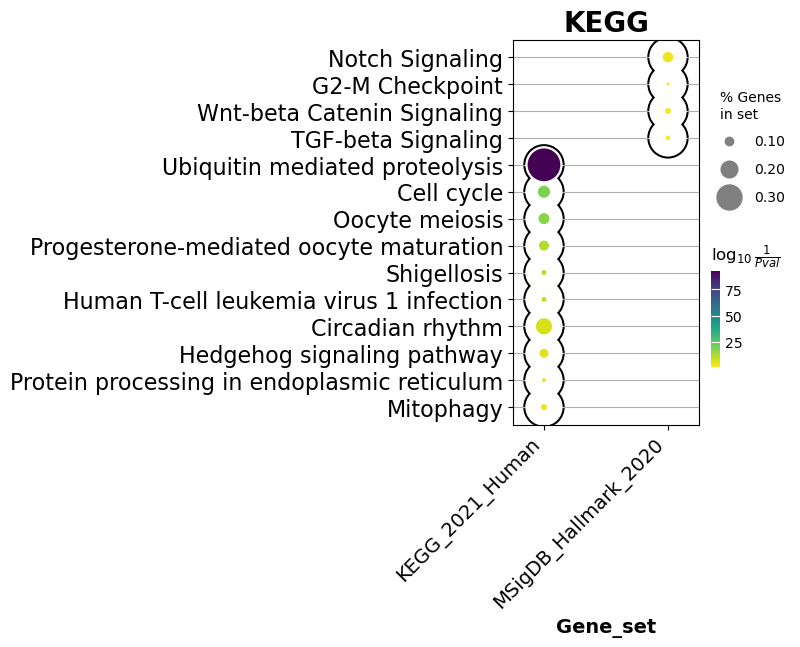

In [65]:
ax = gp.dotplot(enr_eig_100.results,
              column="Adjusted P-value",
              x='Gene_set', # set x axis, so you could do a multi-sample/library comparsion
              size=10,
              top_term=10,
              figsize=(3,5),
              title = "KEGG",
              xticklabels_rot=45, # rotate xtick labels
              show_ring=True, # set to False to revmove outer ring
              marker='o',
             )

# NONCO

In [19]:
nonco_sampling = SamplingForNoco(400, start=200)

## Mod

In [ ]:
#producing modules and modularity samples for different combinations of viruses

names_list = np.loadtxt("Files/Mod/nonco_multi_names_short.txt")
nonco_sampling = SamplingForNoco(20000, start=len(names_list)-3)

nonco_modules = []
nonco_modularity = []
nonco_perc_point = []
nonco_lcc = []
nonco_lic = []


for i, n in enumerate(nonco_sampling):
    print(f"Iteration {i+1}")
    print(n)
    net_nonco = VirusMultiplex(n)
    print(net_nonco.net_description)
    #modules and modularity
    nonco_ms, nonco_my = net_nonco.GetMod(n_iter=1)

    
    ms_file = list(np.loadtxt("Files/Mod/nonco_multi_modules_short.txt"))
    my_file = list(np.loadtxt("Files/Mod/nonco_multi_modularity_short.txt"))
    nn_file = readComponent(fname="Files/Mod/nonco_multi_names_short.txt")
    nn_file.append(n)
    
    ms_file.append(nonco_ms[0])
    my_file.append(nonco_my[0])
    
    print(nonco_sampling[i], nonco_ms[0], nonco_my[0])
    
    np.savetxt(X=ms_file, fname="Files/Mod/nonco_multi_modules_short.txt", fmt="%d")
    np.savetxt(X=my_file, fname="Files/Mod/nonco_multi_modularity_short.txt", fmt="%.7f")
    np.savetxt(X=nn_file, fname="Files/Mod/nonco_multi_names_short.txt", fmt="%d")
    

In [ ]:
for i, ms, my in zip(np.arange(len(nonco_modules)),nonco_modules, nonco_modularity):
    print("Iter:%d  Modules: %d  Modularity: %.4f" %(i+1, ms, my))

## Components

In [22]:
nonco_sampling = SamplingForNoco(10, start=0)
lvc_nonco_list = []
lic_nonco_list = []

for n in tqdm(nonco_sampling):
    net_nonco=mxp.VirusMultiplex(n, target_folder=target_folder, virus_metadata=virus_metadata)
    #print(net_nonco.net_description)
    lvc_list = np.loadtxt()
    
    lvc_nonco_list.append(mxp.topology.get_multi_LVC(net_nonco.g_list, printt=False))
    lic_nonco_list.append(mxp.topology.get_multi_LIC(net_nonco.g_list))
    

100%|███████████████████████████████████████████| 10/10 [00:20<00:00,  2.10s/it]


## Centrality

In [ ]:
for j in tqdm(range(200)):
    net_nonco = mxp.VirusMultiplex(nonco_sampling[j], target_folder=target_folder, virus_metadata=virus_metadata)
    tensor_nonco = mxp.build.get_node_tensor_from_network_list(net_nonco.g_list)
    layer_tensor_nonco = mxp.build.build_layers_tensor(Layers=net_nonco.Layers,
                                                      OmegaParameter=layerCouplingStrength, 
                                                      MultisliceType=networkOfLayersType)
    supra_nonco = mxp.build.build_supra_adjacency_matrix_from_edge_colored_matrices(nodes_tensor=tensor_nonco,
                                                                               layer_tensor=layer_tensor_nonco,
                                                                               layers=net_nonco.Layers,
                                                                               nodes=net_nonco.Nodes)
    pr_centr = mxp.versatility.get_multi_RW_centrality(supra=supra_nonco, 
                                                       layers=net_nonco.Layers, 
                                                       nodes=net_nonco.Nodes, 
                                                       Type="pagerank",
                                                        )
    keys = list(node_map_dict.keys())
    keys_net = list(net_nonco.node_map.keys())

    centr_norm = np.zeros(len(node_map_dict))
    centr_dict = dict(zip(keys_net, pr_centr))

    for i,c in enumerate(keys):
        if c in keys_net:
            centr_norm[i]=centr_dict[c]
    centr_norm=centr_norm/max(centr_norm)
    
    #if j>0:
    centr_all = np.loadtxt("Files/MachineLearning/Pagerank/nonco.txt")
    centr_norm = np.vstack([centr_all, centr_norm])
    np.savetxt(X=centr_norm, fname="Files/MachineLearning/Pagerank/nonco.txt", fmt="%.6f")

 16%|██████▋                                   | 32/200 [02:50<17:11,  6.14s/it]

In [11]:
net_nonco = mxp.VirusMultiplex(nonco_sampling[0], target_folder=target_folder, virus_metadata=virus_metadata)

In [12]:
tensor_nonco = mxp.build.get_node_tensor_from_network_list(net_nonco.g_list)
layer_tensor_nonco = mxp.build.build_layers_tensor(Layers=net_nonco.Layers,
                                                  OmegaParameter=layerCouplingStrength, 
                                                  MultisliceType=networkOfLayersType)

g_agg_nonco = mxp.build.get_aggregate_network(obj=tensor_nonco)

In [13]:
supra_nonco = mxp.build.build_supra_adjacency_matrix_from_edge_colored_matrices(nodes_tensor=tensor_nonco,
                                                                               layer_tensor=layer_tensor_nonco,
                                                                               layers=net_nonco.Layers,
                                                                               nodes=net_nonco.Nodes)

trans_nonco = mxp.build.build_supra_transition_matrix_from_supra_adjacency_matrix(supra=supra_nonco,
                                                                                 layers=net_nonco.Layers,
                                                                                 nodes=net_nonco.Nodes)

In [14]:
hub_centr_nonco = mxp.versatility.get_multi_hub_centrality(supra=supra_nonco,
                                                           layers=net_nonco.Layers,
                                                           nodes=net_nonco.Nodes)

Reached convergence


In [45]:
hub_cn = np.array(list(net_onco.node_map.keys()))[np.argsort(hub_centr_nonco)[::-1]]
hub_cn_lic_onco = np.where(np.isin(hub_cn, freq_lic.Prot))[0]

In [63]:
hub_centr_nonco_list=[]
for i in range(10):
    net_nonco = mxp.VirusMultiplex(nonco_sampling[i], target_folder=target_folder, virus_metadata=virus_metadata)
    print(net_nonco.net_description)
    tensor_nonco = mxp.build.get_node_tensor_from_network_list(net_nonco.g_list)
    layer_tensor_nonco = mxp.build.build_layers_tensor(Layers=net_nonco.Layers,
                                                      OmegaParameter=layerCouplingStrength, 
                                                      MultisliceType=networkOfLayersType)
    supra_nonco = mxp.build.build_supra_adjacency_matrix_from_edge_colored_matrices(nodes_tensor=tensor_nonco,
                                                                               layer_tensor=layer_tensor_nonco,
                                                                               layers=net_nonco.Layers,
                                                                               nodes=net_nonco.Nodes)
    hub_centr_nonco_list.append(mxp.versatility.get_multi_hub_centrality(supra=supra_nonco,
                                                               layers=net_nonco.Layers,
                                                               nodes=net_nonco.Nodes))

Multiplex with 8 layers, 9362 nodes and 836514 edges
Reached convergence
Multiplex with 8 layers, 4698 nodes and 261783 edges
Multiplex with 8 layers, 8115 nodes and 826628 edges
Reached convergence
Multiplex with 8 layers, 8176 nodes and 738556 edges
Reached convergence
Multiplex with 8 layers, 7965 nodes and 878203 edges
Reached convergence
Multiplex with 8 layers, 8338 nodes and 805872 edges
Reached convergence
Multiplex with 8 layers, 9813 nodes and 1054966 edges
Reached convergence
Multiplex with 8 layers, 4743 nodes and 297822 edges
Reached convergence
Multiplex with 8 layers, 5239 nodes and 383379 edges
Reached convergence
Multiplex with 8 layers, 5690 nodes and 425620 edges
Reached convergence


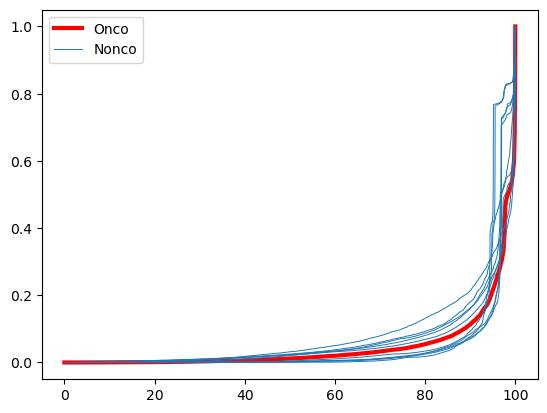

In [72]:
plt.plot(np.linspace(0,100,len(hub_centr_onco)), np.sort(hub_centr_onco), label="Onco", lw=3, color="red")

for hc in hub_centr_nonco_list:
    plt.plot(np.linspace(0,100,len(hc)),np.sort(hc), label="Nonco", color="C0", lw=0.7)
plt.legend(["Onco","Nonco"], loc="upper left")
#plt.xlim([80,100])

# O1S

In [3]:
comb = list(itertools.combinations(range(8), 7))
Sars_onco_cond = np.where(np.array(np.all([virus_metadata["neigh_order"]==NEIGH_ORDER, virus_metadata["isOncogenic"] == True], axis=0)))[0]
Sars_pos = np.where(np.array(np.all([virus_metadata["neigh_order"]==NEIGH_ORDER, virus_metadata["virus"]=="Human_SARS_coronavirus_2"], axis=0)))[0][0]
o1s_virus_indexes = np.array([list(Sars_onco_cond[list(comb[i])])+[Sars_pos] for i in range(len(comb))])
print(o1s_virus_indexes)

[[28 43 44 67 75 77 78 89]
 [28 43 44 67 75 77 90 89]
 [28 43 44 67 75 78 90 89]
 [28 43 44 67 77 78 90 89]
 [28 43 44 75 77 78 90 89]
 [28 43 67 75 77 78 90 89]
 [28 44 67 75 77 78 90 89]
 [43 44 67 75 77 78 90 89]]


In [22]:
net_sonco = mxp.VirusMultiplex(indexes=Sars_onco_comb[0], 
                                    target_folder=target_folder, 
                                    virus_metadata=virus_metadata, 
                                    NEIGH_ORDER=1)

In [23]:
o1s_ass = mxp.mesoscale.inter_layer_assortativity(net_sonco.g_list, 8)

<AxesSubplot: >

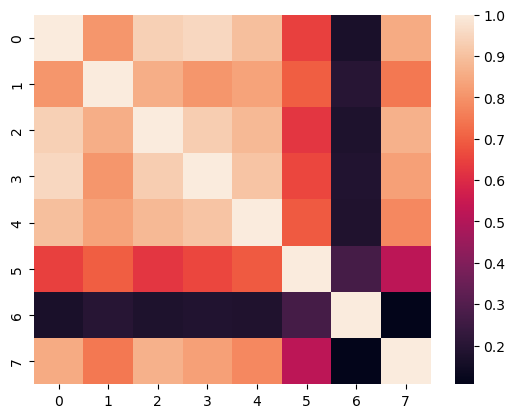

In [24]:
sns.heatmap(o1s_ass["Pearson"])

## Mod

In [ ]:
for ind in o1s_virus_indexes:
    net_o1s = mxp.VirusMultiplex(indexes=ind, 
                                  target_folder=target_folder, 
                                  virus_metadata=virus_metadata, 
                                  NEIGH_ORDER=1)
    print(net_o1s.net_description)
    for j in range(50):
        o1s_mod = mxp.mesoscale.get_mod(net_o1s.g_multi, n_iter=1)

        mods_list = np.loadtxt("Files/Mod/Sonco_mods.txt")
        mody_list = np.loadtxt("Files/Mod/Sonco_mody.txt")
        np.savetxt(X=np.concatenate([mods_list, Sonco_mod[0]]), fname="Files/Mod/Sonco_mods.txt", fmt="%d")
        np.savetxt(X=np.concatenate([mody_list, Sonco_mod[1]]), fname="Files/Mod/Sonco_mody.txt", fmt="%.7f")

## Components

In [25]:
for ind in tqdm(o1s_virus_indexes):
    net_o1s = mxp.VirusMultiplex(indexes=ind, 
                                  target_folder=target_folder, 
                                  virus_metadata=virus_metadata, 
                                  NEIGH_ORDER=1)
    o1s_lcc = mxp.topology.get_multi_LCC(net_o1s.g_list)
    lcc_list = list(np.loadtxt("Files/Components/o1s_lcc_len.txt"))
    lcc_list.append(len(o1s_lcc))
    np.savetxt(fname="Files/Components/o1s_lcc_len.txt", X=np.array(lcc_list), fmt="%d")
    

100%|█████████████████████████████████████████████| 8/8 [01:06<00:00,  8.30s/it]


In [60]:
for ind in Sars_onco_comb:
    net_sonco = mxp.VirusMultiplex(indexes=ind, 
                                  target_folder=target_folder, 
                                  virus_metadata=virus_metadata, 
                                  NEIGH_ORDER=1)
    print(net_sonco.net_description)
    Sonco_lvc = mxp.topology.get_multi_LVC(net_sonco.g_list, printt=False)
    Sonco_lvc = itemgetter(*np.array(list(net_sonco.node_map.keys()))[Sonco_lvc])(node_map_dict)
    Sonco_lic = mxp.topology.get_multi_LIC(net_sonco.g_list)
    Sonco_lic = itemgetter(*np.array(list(net_sonco.node_map.keys()))[Sonco_lic])(node_map_dict)

    lvc_list = mxp.utils.readComponent("Files/Components/Sonco_lvc.txt")
    lvc_list.append(Sonco_lvc)
    lic_list = mxp.utils.readComponent("Files/Components/Sonco_lic.txt")
    lic_list.append(Sonco_lic)
    
    #mxp.utils.writeComponent(ensemble=lvc_list, fname="Files/Components/Sonco_lvc.txt")
    #mxp.utils.writeComponent(ensemble=lic_list, fname="Files/Components/Sonco_lic.txt")

Multiplex with 8 layers, 14075 nodes and 2662385 edges
Multiplex with 8 layers, 14090 nodes and 2735592 edges
Multiplex with 8 layers, 14091 nodes and 2660741 edges
Multiplex with 8 layers, 13906 nodes and 2354852 edges
Multiplex with 8 layers, 13910 nodes and 2315248 edges
Multiplex with 8 layers, 13611 nodes and 2254355 edges
Multiplex with 8 layers, 14025 nodes and 2430370 edges
Multiplex with 8 layers, 13640 nodes and 2268016 edges


## Percolation

In [12]:
for ind in Sars_onco_comb:
    net_sonco = mxp.VirusMultiplex(indexes=ind, 
                                  target_folder=target_folder, 
                                  virus_metadata=virus_metadata, 
                                  NEIGH_ORDER=1)
    print(net_sonco.net_description)
    Sonco_perc = mxp.percolation.get_percolation(net_sonco.g_list, 
                                                 layers=net_sonco.Layers, 
                                                 nodes=net_sonco.Nodes, 
                                                 method="pagerank")

    cPoint_list = np.loadtxt("Files/Percolation/CritPoint/Sonco_pr.txt")
    
    np.savetxt(X=np.concatenate([cPoint_list, [Sonco_perc["CritPoint"]]]), fname="Files/Percolation/CritPoint/Sonco_pr.txt", fmt="%.6f")

Multiplex with 8 layers, 14075 nodes and 2662385 edges
Multiplex with 8 layers, 14090 nodes and 2735592 edges
Multiplex with 8 layers, 14091 nodes and 2660741 edges
Multiplex with 8 layers, 13906 nodes and 2354852 edges
Multiplex with 8 layers, 13910 nodes and 2315248 edges
Multiplex with 8 layers, 13611 nodes and 2254355 edges
Multiplex with 8 layers, 14025 nodes and 2430370 edges
Multiplex with 8 layers, 13640 nodes and 2268016 edges


## Centrality

In [5]:
for j in tqdm(range(len(o1s_virus_indexes))):
    net_nonco = mxp.VirusMultiplex(o1s_virus_indexes[j], target_folder=target_folder, virus_metadata=virus_metadata)
    tensor_nonco = mxp.build.get_node_tensor_from_network_list(net_nonco.g_list)
    layer_tensor_nonco = mxp.build.build_layers_tensor(Layers=net_nonco.Layers,
                                                      OmegaParameter=layerCouplingStrength, 
                                                      MultisliceType=networkOfLayersType)
    supra_nonco = mxp.build.build_supra_adjacency_matrix_from_edge_colored_matrices(nodes_tensor=tensor_nonco,
                                                                               layer_tensor=layer_tensor_nonco,
                                                                               layers=net_nonco.Layers,
                                                                               nodes=net_nonco.Nodes)
    pr_centr = mxp.versatility.get_multi_RW_centrality(supra=supra_nonco, 
                                                       layers=net_nonco.Layers, 
                                                       nodes=net_nonco.Nodes, 
                                                       Type="pagerank",
                                                        )
    keys = list(node_map_dict.keys())
    keys_net = list(net_nonco.node_map.keys())

    centr_norm = np.zeros(len(node_map_dict))
    centr_dict = dict(zip(keys_net, pr_centr))

    for i,c in enumerate(keys):
        if c in keys_net:
            centr_norm[i]=centr_dict[c]
    centr_norm=centr_norm/max(centr_norm)
    
    if j>0:
        centr_all = np.loadtxt("Files/MachineLearning/Pagerank/o1s.txt")
        centr_norm = np.vstack([centr_all, centr_norm])
    np.savetxt(X=centr_norm, fname="Files/MachineLearning/Pagerank/o1s.txt", fmt="%.6f")

100%|█████████████████████████████████████████████| 8/8 [01:30<00:00, 11.27s/it]


# N1S

In [6]:
ncombs=2000
Snonco_nonco_samples = SamplingForNoco(ncombs,start=1500, group_dim=7, random_seed=4563)
Sars_pos = np.where(np.array(np.all([virus_metadata["neigh_order"]==NEIGH_ORDER, virus_metadata["virus"]=="Human_SARS_coronavirus_2"], axis=0)))[0][0]
n1s_virus_indexes = np.concatenate([Snonco_nonco_samples, np.repeat(Sars_pos,ncombs).reshape([ncombs,1])], axis=1)

In [8]:
net_snonco = mxp.VirusMultiplex(indexes=Sars_nonco_comb[0], 
                                    target_folder=target_folder, 
                                    virus_metadata=virus_metadata, 
                                    NEIGH_ORDER=1)

In [9]:
n1s_ass = mxp.mesoscale.inter_layer_assortativity(net_snonco.g_list, 8)

<AxesSubplot: >

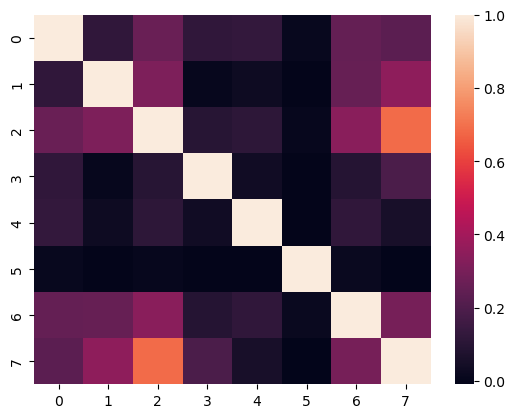

In [10]:
sns.heatmap(n1s_ass["Pearson"])

## Mod

In [ ]:
for ind in tqdm(n1s_virus_indexes):
    net_n1s = mxp.VirusMultiplex(indexes=ind, 
                                  target_folder=target_folder, 
                                  virus_metadata=virus_metadata, 
                                  NEIGH_ORDER=1)
    n1s_lcc = mxp.topology.get_multi_LCC(net_n1s.g_list)
    lcc_list = list(np.loadtxt("Files/Components/n1s_lcc_len.txt"))
    lcc_list.append(len(n1s_lcc))
    np.savetxt(fname="Files/Components/n1s_lcc_len.txt", X=np.array(lcc_list), fmt="%d")
    

  5%|█▉                                     | 98/2000 [05:24<1:41:49,  3.21s/it]

In [ ]:
for i,ind in enumerate(Sars_nonco_comb):
    net_snonco = mxp.VirusMultiplex(indexes=ind, 
                                    target_folder=target_folder, 
                                    virus_metadata=virus_metadata, 
                                    NEIGH_ORDER=1)
    print(net_snonco.net_description)
    Snonco_mod = mxp.mesoscale.get_mod(net_snonco.g_multi, n_iter=1)

    mods_list = np.loadtxt("Files/Mod/Snonco_mods.txt")
    np.savetxt(X=np.concatenate([mods_list, Snonco_mod[0]]), fname="Files/Mod/Snonco_mods.txt", fmt="%d")

    mody_list = np.loadtxt("Files/Mod/Snonco_mody_new.txt")
    np.savetxt(X=np.concatenate([mody_list, Snonco_mod[1]]), fname="Files/Mod/Snonco_mody_new.txt", fmt="%.7f")

Multiplex with 8 layers, 12969 nodes and 1427457 edges


  0%|                                                     | 0/1 [00:00<?, ?it/s]

## Components

In [ ]:
for ind in tqdm(Sars_nonco_comb):
    net_snonco = mxp.VirusMultiplex(indexes=ind, 
                                  target_folder=target_folder, 
                                  virus_metadata=virus_metadata, 
                                  NEIGH_ORDER=1)
    #print(net_snonco.net_description)
    
    Snonco_lvc = mxp.topology.get_multi_LVC(net_snonco.g_list, printt=False)
    if len(Snonco_lvc)>1: 
        Snonco_lvc = itemgetter(*np.array(list(net_snonco.node_map.keys()))[Snonco_lvc])(node_map_dict)
    elif len(Snonco_lvc)==1:
        Snonco_lvc = [itemgetter(*np.array(list(net_snonco.node_map.keys()))[Snonco_lvc])(node_map_dict)]
        
    Snonco_lic = mxp.topology.get_multi_LIC(net_snonco.g_list)
    if len(Snonco_lic)>1: 
        Snonco_lic = itemgetter(*np.array(list(net_snonco.node_map.keys()))[Snonco_lic])(node_map_dict)
    elif len(Snonco_lic)==1:
        Snonco_lic = [itemgetter(*np.array(list(net_snonco.node_map.keys()))[Snonco_lic])(node_map_dict)]
        
    lvc_list = mxp.utils.readComponent("Files/Components/Snonco_lvc.txt")
    lvc_list.append(Snonco_lvc)

    lic_list = mxp.utils.readComponent("Files/Components/Snonco_lic.txt")
    lic_list.append(Snonco_lic)
    
    mxp.utils.writeComponent(ensemble=lvc_list, fname="Files/Components/Snonco_lvc.txt")
    mxp.utils.writeComponent(ensemble=lic_list, fname="Files/Components/Snonco_lic.txt")

  3%|█▎                                     | 51/1500 [03:06<1:30:17,  3.74s/it]

## Percolation

In [17]:
Snonco_perc

{'1ComponentSize': array([    1,     1,     1, ..., 12971, 12974, 13004], dtype=uint64),
 '2ComponentSize': array([0, 0, 0, ..., 1, 1, 0], dtype=uint64),
 'CritPoint': 0.2826053521993233}

In [ ]:
for ind in tqdm(Sars_nonco_comb):
    net_snonco = mxp.VirusMultiplex(indexes=ind, 
                                    target_folder=target_folder, 
                                    virus_metadata=virus_metadata, 
                                    NEIGH_ORDER=1)
    Snonco_perc = mxp.percolation.get_percolation(net_snonco.g_list,
                                                 nodes=net_snonco.Nodes,
                                                 layers=net_snonco.Layers,
                                                 method="pagerank")
    
    cPoint_list = np.loadtxt("Files/Percolation/CritPoint/Snonco_pr.txt")
    
    np.savetxt(X=np.concatenate([cPoint_list,[Snonco_perc["CritPoint"]]]) , fname="Files/Percolation/CritPoint/Snonco_pr.txt", fmt="%.6f")
    

  0%|                                      | 2/20000 [00:07<21:10:21,  3.81s/it]

## Centrality

In [7]:
for j in tqdm(range(100)):
    net_nonco = mxp.VirusMultiplex(n1s_virus_indexes[j], target_folder=target_folder, virus_metadata=virus_metadata)
    tensor_nonco = mxp.build.get_node_tensor_from_network_list(net_nonco.g_list)
    layer_tensor_nonco = mxp.build.build_layers_tensor(Layers=net_nonco.Layers,
                                                      OmegaParameter=layerCouplingStrength, 
                                                      MultisliceType=networkOfLayersType)
    supra_nonco = mxp.build.build_supra_adjacency_matrix_from_edge_colored_matrices(nodes_tensor=tensor_nonco,
                                                                               layer_tensor=layer_tensor_nonco,
                                                                               layers=net_nonco.Layers,
                                                                               nodes=net_nonco.Nodes)
    pr_centr = mxp.versatility.get_multi_RW_centrality(supra=supra_nonco, 
                                                       layers=net_nonco.Layers, 
                                                       nodes=net_nonco.Nodes, 
                                                       Type="pagerank",
                                                        )
    keys = list(node_map_dict.keys())
    keys_net = list(net_nonco.node_map.keys())

    centr_norm = np.zeros(len(node_map_dict))
    centr_dict = dict(zip(keys_net, pr_centr))

    for i,c in enumerate(keys):
        if c in keys_net:
            centr_norm[i]=centr_dict[c]
    centr_norm=centr_norm/max(centr_norm)
    
    if j>0:
        centr_all = np.loadtxt("Files/MachineLearning/Pagerank/n1s.txt")
        centr_norm = np.vstack([centr_all, centr_norm])
    np.savetxt(X=centr_norm, fname="Files/MachineLearning/Pagerank/n1s.txt", fmt="%.6f")

100%|█████████████████████████████████████████| 100/100 [09:58<00:00,  5.99s/it]


# RANDOM 50 50

In [48]:
random_virus_indexes = []
random_nonco_sampling = SamplingForNoco(2000,group_dim=4, random_seed=78541)
for i in range(2000):
    random_onco = np.random.choice(onco_virus_indexes, 4, replace=False)
    random_nonco = random_nonco_sampling[i]
    random_samp = np.concatenate([random_onco, random_nonco])
    np.random.shuffle(random_samp)
    random_virus_indexes.append(random_samp)

## Mod

In [ ]:
for i,ind in enumerate(random_virus_indexes):
    net_random = mxp.VirusMultiplex(indexes=ind, 
                                    target_folder=target_folder, 
                                    virus_metadata=virus_metadata, 
                                    NEIGH_ORDER=1)
    print(net_random.net_description)
    random_mod = mxp.mesoscale.get_mod(net_random.g_multi, n_iter=1)

    mods_list = np.loadtxt("Files/Mod/random_mods.txt")
    np.savetxt(X=np.concatenate([mods_list, random_mod[0]]), fname="Files/Mod/random_mods.txt", fmt="%d")

    mody_list = np.loadtxt("Files/Mod/random_mody.txt")
    np.savetxt(X=np.concatenate([mody_list, random_mod[1]]), fname="Files/Mod/random_mody.txt", fmt="%.7f")

## Components

In [ ]:
for ind in tqdm(random_virus_indexes):
    net_random = mxp.VirusMultiplex(indexes=ind, 
                                  target_folder=target_folder, 
                                  virus_metadata=virus_metadata, 
                                  NEIGH_ORDER=1)
    random_lcc = mxp.topology.get_multi_LCC(net_random.g_list)
    lcc_list = list(np.loadtxt("Files/Components/random_lcc_len.txt"))
    lcc_list.append(len(random_lcc))
    np.savetxt(fname="Files/Components/random_lcc_len.txt", X=np.array(lcc_list), fmt="%d")
    

  0%|                                        | 3/2000 [00:14<2:37:25,  4.73s/it]

In [ ]:
for ind in tqdm(random_virus_indexes):
    net_random = mxp.VirusMultiplex(indexes=ind, 
                                  target_folder=target_folder, 
                                  virus_metadata=virus_metadata, 
                                  NEIGH_ORDER=1)
    #print(net_random.net_description)
    random_lvc = mxp.topology.get_multi_LVC(net_random.g_list, printt=False)
    if len(random_lvc)>1: 
        random_lvc = itemgetter(*np.array(list(net_random.node_map.keys()))[random_lvc])(node_map_dict)
    elif len(random_lvc)==1:
        random_lvc = [itemgetter(*np.array(list(net_random.node_map.keys()))[random_lvc])(node_map_dict)]
        
    random_lic = mxp.topology.get_multi_LIC(net_random.g_list)
    if len(random_lic)>1: 
        random_lic = itemgetter(*np.array(list(net_random.node_map.keys()))[random_lic])(node_map_dict)
    elif len(random_lic)==1:
        random_lic = [itemgetter(*np.array(list(net_random.node_map.keys()))[random_lic])(node_map_dict)]
        
    lvc_list = mxp.utils.readComponent("Files/Components/random_lvc.txt")
    lvc_list.append(random_lvc)

    lic_list = mxp.utils.readComponent("Files/Components/random_lic.txt")
    lic_list.append(random_lic)
    
    mxp.utils.writeComponent(ensemble=lvc_list, fname="Files/Components/random_lvc.txt")
    mxp.utils.writeComponent(ensemble=lic_list, fname="Files/Components/random_lic.txt")

  1%|▎                                      | 35/5000 [03:04<6:19:47,  4.59s/it]

## Percolation

In [ ]:
for ind in random_virus_indexes:
    net_random = mxp.VirusMultiplex(indexes=ind, 
                                  target_folder=target_folder, 
                                  virus_metadata=virus_metadata, 
                                  NEIGH_ORDER=1)
    print(net_random.net_description)
    random_perc = mxp.percolation.get_percolation(net_random.g_list, 
                                                 layers=net_random.Layers, 
                                                 nodes=net_random.Nodes, 
                                                 method="pagerank")

    cPoint_list = np.loadtxt("Files/Percolation/CritPoint/random_pr.txt")
    
    np.savetxt(X=np.concatenate([cPoint_list, [random_perc["CritPoint"]]]), fname="Files/Percolation/CritPoint/random_pr.txt", fmt="%.6f")

Multiplex with 8 layers, 9907 nodes and 1021060 edges
Multiplex with 8 layers, 10850 nodes and 1196694 edges
Multiplex with 8 layers, 7283 nodes and 638064 edges


## Centrality

In [49]:
for j in tqdm(range(100)):
    net_nonco = mxp.VirusMultiplex(random_virus_indexes[j], target_folder=target_folder, virus_metadata=virus_metadata)
    tensor_nonco = mxp.build.get_node_tensor_from_network_list(net_nonco.g_list)
    layer_tensor_nonco = mxp.build.build_layers_tensor(Layers=net_nonco.Layers,
                                                      OmegaParameter=layerCouplingStrength, 
                                                      MultisliceType=networkOfLayersType)
    supra_nonco = mxp.build.build_supra_adjacency_matrix_from_edge_colored_matrices(nodes_tensor=tensor_nonco,
                                                                               layer_tensor=layer_tensor_nonco,
                                                                               layers=net_nonco.Layers,
                                                                               nodes=net_nonco.Nodes)
    pr_centr = mxp.versatility.get_multi_RW_centrality(supra=supra_nonco, 
                                                       layers=net_nonco.Layers, 
                                                       nodes=net_nonco.Nodes, 
                                                       Type="pagerank",
                                                        )
    keys = list(node_map_dict.keys())
    keys_net = list(net_nonco.node_map.keys())

    centr_norm = np.zeros(len(node_map_dict))
    centr_dict = dict(zip(keys_net, pr_centr))

    for i,c in enumerate(keys):
        if c in keys_net:
            centr_norm[i]=centr_dict[c]
    centr_norm=centr_norm/max(centr_norm)
    
    #if j>0:
    centr_all = np.loadtxt("Files/MachineLearning/Pagerank/random.txt")
    centr_norm = np.vstack([centr_all, centr_norm])
    np.savetxt(X=centr_norm, fname="Files/MachineLearning/Pagerank/random.txt", fmt="%.6f")

100%|█████████████████████████████████████████| 100/100 [13:24<00:00,  8.04s/it]


# O1N

In [13]:
comb = list(itertools.combinations(range(8), 7))
nonco_virus_indexes = np.where(np.all([np.array(virus_metadata["virus"]!="Human_SARS_coronavirus_2"),
                                  np.array(virus_metadata["virus_short"]!="Lymphocytic_choriomeningitis_virus"),
                                  np.array(virus_metadata["neigh_order"]==NEIGH_ORDER), 
                                  np.array(virus_metadata["isOncogenic"]==False)],
                                  axis=0))[0]

o1n_virus_indexes = []
for i in range(len(onco_virus_indexes)):
    onco_samp = onco_virus_indexes[list(comb[i])]
    for j in range(len(nonco_virus_indexes)):
        o1n_virus_indexes.append(np.concatenate([onco_samp, [nonco_virus_indexes[j]]]))

## Mod

In [ ]:
for i,ind in enumerate(o1n_virus_indexes):
    net_o1n = mxp.VirusMultiplex(indexes=ind, 
                                    target_folder=target_folder, 
                                    virus_metadata=virus_metadata, 
                                    NEIGH_ORDER=1)
    print(net_o1n.net_description)
    o1n_mod = mxp.mesoscale.get_mod(net_o1n.g_multi, n_iter=1)

    mods_list = np.loadtxt("Files/Mod/o1n_mods.txt")
    np.savetxt(X=np.concatenate([mods_list, o1n_mod[0]]), fname="Files/Mod/o1n_mods.txt", fmt="%d")

    mody_list = np.loadtxt("Files/Mod/o1n_mody.txt")
    np.savetxt(X=np.concatenate([mody_list, o1n_mod[1]]), fname="Files/Mod/o1n_mody.txt", fmt="%.7f")

Multiplex with 8 layers, 11852 nodes and 2214490 edges


  0%|                                                     | 0/1 [00:00<?, ?it/s]

## Components

In [23]:
for ind in tqdm(o1n_virus_indexes):
    net_o1n = mxp.VirusMultiplex(indexes=ind, 
                                  target_folder=target_folder, 
                                  virus_metadata=virus_metadata, 
                                  NEIGH_ORDER=1)
    o1n_lcc = mxp.topology.get_multi_LCC(net_o1n.g_list)
    lcc_list = list(np.loadtxt("Files/Components/o1n_lcc_len.txt"))
    lcc_list.append(len(o1n_lcc))
    np.savetxt(fname="Files/Components/o1n_lcc_len.txt", X=np.array(lcc_list), fmt="%d")
    

100%|███████████████████████████████████████| 568/568 [1:05:50<00:00,  6.96s/it]


In [ ]:
for ind in tqdm(o1n_virus_indexes):
    net_o1n = mxp.VirusMultiplex(indexes=ind, 
                                  target_folder=target_folder, 
                                  virus_metadata=virus_metadata, 
                                  NEIGH_ORDER=1)
    #print(net_o1n.net_description)
    o1n_lvc = mxp.topology.get_multi_LVC(net_o1n.g_list, printt=False)
    if len(o1n_lvc)>1: 
        o1n_lvc = itemgetter(*np.array(list(net_o1n.node_map.keys()))[o1n_lvc])(node_map_dict)
    elif len(o1n_lvc)==1:
        o1n_lvc = [itemgetter(*np.array(list(net_o1n.node_map.keys()))[o1n_lvc])(node_map_dict)]
        
    o1n_lic = mxp.topology.get_multi_LIC(net_o1n.g_list)
    if len(o1n_lic)>1: 
        o1n_lic = itemgetter(*np.array(list(net_o1n.node_map.keys()))[o1n_lic])(node_map_dict)
    elif len(o1n_lic)==1:
        o1n_lic = [itemgetter(*np.array(list(net_o1n.node_map.keys()))[o1n_lic])(node_map_dict)]
        
    lvc_list = mxp.utils.readComponent("Files/Components/o1n_lvc.txt")
    lvc_list.append(o1n_lvc)

    lic_list = mxp.utils.readComponent("Files/Components/o1n_lic.txt")
    lic_list.append(o1n_lic)
    
    mxp.utils.writeComponent(ensemble=lvc_list, fname="Files/Components/o1n_lvc.txt")
    mxp.utils.writeComponent(ensemble=lic_list, fname="Files/Components/o1n_lic.txt")

## Percolation

In [ ]:
for ind in o1n_virus_indexes:
    net_o1n = mxp.VirusMultiplex(indexes=ind, 
                                  target_folder=target_folder, 
                                  virus_metadata=virus_metadata, 
                                  NEIGH_ORDER=1)
    print(net_o1n.net_description)
    o1n_perc = mxp.percolation.get_percolation(net_o1n.g_list, 
                                                 layers=net_o1n.Layers, 
                                                 nodes=net_o1n.Nodes, 
                                                 method="pagerank")

    cPoint_list = np.loadtxt("Files/Percolation/CritPoint/o1n_pr.txt")
    
    np.savetxt(X=np.concatenate([cPoint_list, [o1n_perc["CritPoint"]]]), fname="Files/Percolation/CritPoint/o1n_pr.txt", fmt="%.6f")

Multiplex with 8 layers, 11852 nodes and 2214490 edges


## Centrality

In [14]:
for j in tqdm(range(100)):
    net_nonco = mxp.VirusMultiplex(o1n_virus_indexes[j], target_folder=target_folder, virus_metadata=virus_metadata)
    tensor_nonco = mxp.build.get_node_tensor_from_network_list(net_nonco.g_list)
    layer_tensor_nonco = mxp.build.build_layers_tensor(Layers=net_nonco.Layers,
                                                      OmegaParameter=layerCouplingStrength, 
                                                      MultisliceType=networkOfLayersType)
    supra_nonco = mxp.build.build_supra_adjacency_matrix_from_edge_colored_matrices(nodes_tensor=tensor_nonco,
                                                                               layer_tensor=layer_tensor_nonco,
                                                                               layers=net_nonco.Layers,
                                                                               nodes=net_nonco.Nodes)
    pr_centr = mxp.versatility.get_multi_RW_centrality(supra=supra_nonco, 
                                                       layers=net_nonco.Layers, 
                                                       nodes=net_nonco.Nodes, 
                                                       Type="pagerank",
                                                        )
    keys = list(node_map_dict.keys())
    keys_net = list(net_nonco.node_map.keys())

    centr_norm = np.zeros(len(node_map_dict))
    centr_dict = dict(zip(keys_net, pr_centr))

    for i,c in enumerate(keys):
        if c in keys_net:
            centr_norm[i]=centr_dict[c]
    centr_norm=centr_norm/max(centr_norm)
    
    if j>0:
        centr_all = np.loadtxt("Files/MachineLearning/Pagerank/o1n.txt")
        centr_norm = np.vstack([centr_all, centr_norm])
    np.savetxt(X=centr_norm, fname="Files/MachineLearning/Pagerank/o1n.txt", fmt="%.6f")

100%|█████████████████████████████████████████| 100/100 [17:50<00:00, 10.71s/it]


# N1O

In [ ]:
n1o_virus_indexes = []
n1o_sampling = SamplingForNoco(2000, start=100, group_dim=7, random_seed=456)
for i in range(len(n1o_sampling)):
    onco_pick = np.random.choice(onco_virus_indexes)
    n1o_virus_indexes.append(np.concatenate([n1o_sampling[i], [onco_pick]]))

## Mod

In [ ]:
for i,ind in enumerate(n1o_virus_indexes):
    net_n1o = mxp.VirusMultiplex(indexes=ind, 
                                    target_folder=target_folder, 
                                    virus_metadata=virus_metadata, 
                                    NEIGH_ORDER=1)
    print(net_n1o.net_description)
    n1o_mod = mxp.mesoscale.get_mod(net_n1o.g_multi, n_iter=1)

    mods_list = np.loadtxt("Files/Mod/n1o_mods.txt")
    np.savetxt(X=np.concatenate([mods_list, n1o_mod[0]]), fname="Files/Mod/n1o_mods.txt", fmt="%d")

    mody_list = np.loadtxt("Files/Mod/n1o_mody.txt")
    np.savetxt(X=np.concatenate([mody_list, n1o_mod[1]]), fname="Files/Mod/n1o_mody.txt", fmt="%.7f")

Multiplex with 8 layers, 10399 nodes and 1036132 edges


100%|████████████████████████████████████████████| 1/1 [03:23<00:00, 203.79s/it]


Multiplex with 8 layers, 9082 nodes and 1132871 edges


  0%|                                                     | 0/1 [00:00<?, ?it/s]

## Components

In [5]:
for ind in tqdm(n1o_virus_indexes):
    net_n1o = mxp.VirusMultiplex(indexes=ind, 
                                  target_folder=target_folder, 
                                  virus_metadata=virus_metadata, 
                                  NEIGH_ORDER=1)
    n1o_lcc = mxp.topology.get_multi_LCC(net_n1o.g_list)
    lcc_list = list(np.loadtxt("Files/Components/n1o_lcc_len.txt"))
    lcc_list.append(len(n1o_lcc))
    np.savetxt(fname="Files/Components/n1o_lcc_len.txt", X=np.array(lcc_list), fmt="%d")
    

100%|█████████████████████████████████████| 2000/2000 [1:26:53<00:00,  2.61s/it]


In [ ]:
for ind in tqdm(n1o_virus_indexes):
    net_n1o = mxp.VirusMultiplex(indexes=ind, 
                                  target_folder=target_folder, 
                                  virus_metadata=virus_metadata, 
                                  NEIGH_ORDER=1)
    #print(net_n1o.net_description)
    n1o_lvc = mxp.topology.get_multi_LVC(net_n1o.g_list, printt=False)
    if len(n1o_lvc)>1: 
        n1o_lvc = itemgetter(*np.array(list(net_n1o.node_map.keys()))[n1o_lvc])(node_map_dict)
    elif len(n1o_lvc)==1:
        n1o_lvc = [itemgetter(*np.array(list(net_n1o.node_map.keys()))[n1o_lvc])(node_map_dict)]
        
    n1o_lic = mxp.topology.get_multi_LIC(net_n1o.g_list)
    if len(n1o_lic)>1: 
        n1o_lic = itemgetter(*np.array(list(net_n1o.node_map.keys()))[n1o_lic])(node_map_dict)
    elif len(n1o_lic)==1:
        n1o_lic = [itemgetter(*np.array(list(net_n1o.node_map.keys()))[n1o_lic])(node_map_dict)]
        
    lvc_list = mxp.utils.readComponent("Files/Components/n1o_lvc.txt")
    lvc_list.append(n1o_lvc)

    lic_list = mxp.utils.readComponent("Files/Components/n1o_lic.txt")
    lic_list.append(n1o_lic)
    
    mxp.utils.writeComponent(ensemble=lvc_list, fname="Files/Components/n1o_lvc.txt")
    mxp.utils.writeComponent(ensemble=lic_list, fname="Files/Components/n1o_lic.txt")

## Percolation

In [ ]:
for ind in tqdm(n1o_virus_indexes):
    net_n1o = mxp.VirusMultiplex(indexes=ind, 
                                  target_folder=target_folder, 
                                  virus_metadata=virus_metadata, 
                                  NEIGH_ORDER=1)
    #print(net_n1o.net_description)
    n1o_perc = mxp.percolation.get_percolation(net_n1o.g_list, 
                                                 layers=net_n1o.Layers, 
                                                 nodes=net_n1o.Nodes, 
                                                 method="pagerank")

    cPoint_list = np.loadtxt("Files/Percolation/CritPoint/n1o_pr.txt")
    
    np.savetxt(X=np.concatenate([cPoint_list, [n1o_perc["CritPoint"]]]), fname="Files/Percolation/CritPoint/n1o_pr.txt", fmt="%.6f")

 13%|█████                                 | 666/5000 [31:47<2:37:10,  2.18s/it]

## Centrality

In [ ]:
for j in tqdm(range(300)):
    net_nonco = mxp.VirusMultiplex(n1o_virus_indexes[j], target_folder=target_folder, virus_metadata=virus_metadata)
    tensor_nonco = mxp.build.get_node_tensor_from_network_list(net_nonco.g_list)
    layer_tensor_nonco = mxp.build.build_layers_tensor(Layers=net_nonco.Layers,
                                                      OmegaParameter=layerCouplingStrength, 
                                                      MultisliceType=networkOfLayersType)
    supra_nonco = mxp.build.build_supra_adjacency_matrix_from_edge_colored_matrices(nodes_tensor=tensor_nonco,
                                                                               layer_tensor=layer_tensor_nonco,
                                                                               layers=net_nonco.Layers,
                                                                               nodes=net_nonco.Nodes)
    pr_centr = mxp.versatility.get_multi_RW_centrality(supra=supra_nonco, 
                                                       layers=net_nonco.Layers, 
                                                       nodes=net_nonco.Nodes, 
                                                       Type="pagerank",
                                                        )
    keys = list(node_map_dict.keys())
    keys_net = list(net_nonco.node_map.keys())

    centr_norm = np.zeros(len(node_map_dict))
    centr_dict = dict(zip(keys_net, pr_centr))

    for i,c in enumerate(keys):
        if c in keys_net:
            centr_norm[i]=centr_dict[c]
    centr_norm=centr_norm/max(centr_norm)
    
    #if j>0:
    centr_all = np.loadtxt("Files/MachineLearning/Pagerank/n1o.txt")
    centr_norm = np.vstack([centr_all, centr_norm])
    np.savetxt(X=centr_norm, fname="Files/MachineLearning/Pagerank/n1o.txt", fmt="%.6f")

# ALL OTHERS

In [ ]:
#N2O
n2o_virus_indexes = []
n2o_sampling = SamplingForNoco(200, group_dim=6, random_seed=17521)
for i in range(len(n2o_sampling)):
    onco_pick = np.random.choice(onco_virus_indexes, 2)
    n2o_virus_indexes.append(np.concatenate([n2o_sampling[i], onco_pick]))
    
#N3O
n3o_virus_indexes = []
n3o_sampling = SamplingForNoco(200, group_dim=5, random_seed=27521)
for i in range(len(n3o_sampling)):
    onco_pick = np.random.choice(onco_virus_indexes, 3)
    n3o_virus_indexes.append(np.concatenate([n3o_sampling[i], onco_pick]))
    
#N5O
n5o_virus_indexes = []
n5o_sampling = SamplingForNoco(200, group_dim=3, random_seed=37521)
for i in range(len(n5o_sampling)):
    onco_pick = np.random.choice(onco_virus_indexes, 5)
    n5o_virus_indexes.append(np.concatenate([n5o_sampling[i], onco_pick]))
    
#N6O
n6o_virus_indexes = []
n6o_sampling = SamplingForNoco(200, group_dim=2, random_seed=47521)
for i in range(len(n6o_sampling)):
    onco_pick = np.random.choice(onco_virus_indexes, 6)
    n6o_virus_indexes.append(np.concatenate([n6o_sampling[i], onco_pick]))

## N2O

In [ ]:
for j in tqdm(range(200)):
    net_nonco = mxp.VirusMultiplex(n2o_virus_indexes[j], target_folder=target_folder, virus_metadata=virus_metadata)
    tensor_nonco = mxp.build.get_node_tensor_from_network_list(net_nonco.g_list)
    layer_tensor_nonco = mxp.build.build_layers_tensor(Layers=net_nonco.Layers,
                                                      OmegaParameter=layerCouplingStrength, 
                                                      MultisliceType=networkOfLayersType)
    supra_nonco = mxp.build.build_supra_adjacency_matrix_from_edge_colored_matrices(nodes_tensor=tensor_nonco,
                                                                               layer_tensor=layer_tensor_nonco,
                                                                               layers=net_nonco.Layers,
                                                                               nodes=net_nonco.Nodes)
    pr_centr = mxp.versatility.get_multi_RW_centrality(supra=supra_nonco, 
                                                       layers=net_nonco.Layers, 
                                                       nodes=net_nonco.Nodes, 
                                                       Type="pagerank",
                                                        )
    keys = list(node_map_dict.keys())
    keys_net = list(net_nonco.node_map.keys())

    centr_norm = np.zeros(len(node_map_dict))
    centr_dict = dict(zip(keys_net, pr_centr))

    for i,c in enumerate(keys):
        if c in keys_net:
            centr_norm[i]=centr_dict[c]
    centr_norm=centr_norm/max(centr_norm)
    
    #if j>0:
    centr_all = np.loadtxt("Files/MachineLearning/Pagerank/n2o.txt")
    centr_norm = np.vstack([centr_all, centr_norm])
    np.savetxt(X=centr_norm, fname="Files/MachineLearning/Pagerank/n2o.txt", fmt="%.6f")

## N3O

In [ ]:
for j in tqdm(range(200)):
    net_nonco = mxp.VirusMultiplex(n3o_virus_indexes[j], target_folder=target_folder, virus_metadata=virus_metadata)
    tensor_nonco = mxp.build.get_node_tensor_from_network_list(net_nonco.g_list)
    layer_tensor_nonco = mxp.build.build_layers_tensor(Layers=net_nonco.Layers,
                                                      OmegaParameter=layerCouplingStrength, 
                                                      MultisliceType=networkOfLayersType)
    supra_nonco = mxp.build.build_supra_adjacency_matrix_from_edge_colored_matrices(nodes_tensor=tensor_nonco,
                                                                               layer_tensor=layer_tensor_nonco,
                                                                               layers=net_nonco.Layers,
                                                                               nodes=net_nonco.Nodes)
    pr_centr = mxp.versatility.get_multi_RW_centrality(supra=supra_nonco, 
                                                       layers=net_nonco.Layers, 
                                                       nodes=net_nonco.Nodes, 
                                                       Type="pagerank",
                                                        )
    keys = list(node_map_dict.keys())
    keys_net = list(net_nonco.node_map.keys())

    centr_norm = np.zeros(len(node_map_dict))
    centr_dict = dict(zip(keys_net, pr_centr))

    for i,c in enumerate(keys):
        if c in keys_net:
            centr_norm[i]=centr_dict[c]
    centr_norm=centr_norm/max(centr_norm)
    
    #if j>0:
    centr_all = np.loadtxt("Files/MachineLearning/Pagerank/n3o.txt")
    centr_norm = np.vstack([centr_all, centr_norm])
    np.savetxt(X=centr_norm, fname="Files/MachineLearning/Pagerank/n3o.txt", fmt="%.6f")

## N5O

In [ ]:
for j in tqdm(range(200)):
    net_nonco = mxp.VirusMultiplex(n5o_virus_indexes[j], target_folder=target_folder, virus_metadata=virus_metadata)
    tensor_nonco = mxp.build.get_node_tensor_from_network_list(net_nonco.g_list)
    layer_tensor_nonco = mxp.build.build_layers_tensor(Layers=net_nonco.Layers,
                                                      OmegaParameter=layerCouplingStrength, 
                                                      MultisliceType=networkOfLayersType)
    supra_nonco = mxp.build.build_supra_adjacency_matrix_from_edge_colored_matrices(nodes_tensor=tensor_nonco,
                                                                               layer_tensor=layer_tensor_nonco,
                                                                               layers=net_nonco.Layers,
                                                                               nodes=net_nonco.Nodes)
    pr_centr = mxp.versatility.get_multi_RW_centrality(supra=supra_nonco, 
                                                       layers=net_nonco.Layers, 
                                                       nodes=net_nonco.Nodes, 
                                                       Type="pagerank",
                                                        )
    keys = list(node_map_dict.keys())
    keys_net = list(net_nonco.node_map.keys())

    centr_norm = np.zeros(len(node_map_dict))
    centr_dict = dict(zip(keys_net, pr_centr))

    for i,c in enumerate(keys):
        if c in keys_net:
            centr_norm[i]=centr_dict[c]
    centr_norm=centr_norm/max(centr_norm)
    
    #if j>0:
    centr_all = np.loadtxt("Files/MachineLearning/Pagerank/n5o.txt")
    centr_norm = np.vstack([centr_all, centr_norm])
    np.savetxt(X=centr_norm, fname="Files/MachineLearning/Pagerank/n5o.txt", fmt="%.6f")

## N6O

In [ ]:
for j in tqdm(range(200)):
    net_nonco = mxp.VirusMultiplex(n6o_virus_indexes[j], target_folder=target_folder, virus_metadata=virus_metadata)
    tensor_nonco = mxp.build.get_node_tensor_from_network_list(net_nonco.g_list)
    layer_tensor_nonco = mxp.build.build_layers_tensor(Layers=net_nonco.Layers,
                                                      OmegaParameter=layerCouplingStrength, 
                                                      MultisliceType=networkOfLayersType)
    supra_nonco = mxp.build.build_supra_adjacency_matrix_from_edge_colored_matrices(nodes_tensor=tensor_nonco,
                                                                               layer_tensor=layer_tensor_nonco,
                                                                               layers=net_nonco.Layers,
                                                                               nodes=net_nonco.Nodes)
    pr_centr = mxp.versatility.get_multi_RW_centrality(supra=supra_nonco, 
                                                       layers=net_nonco.Layers, 
                                                       nodes=net_nonco.Nodes, 
                                                       Type="pagerank",
                                                        )
    keys = list(node_map_dict.keys())
    keys_net = list(net_nonco.node_map.keys())

    centr_norm = np.zeros(len(node_map_dict))
    centr_dict = dict(zip(keys_net, pr_centr))

    for i,c in enumerate(keys):
        if c in keys_net:
            centr_norm[i]=centr_dict[c]
    centr_norm=centr_norm/max(centr_norm)
    
    #if j>0:
    centr_all = np.loadtxt("Files/MachineLearning/Pagerank/n6o.txt")
    centr_norm = np.vstack([centr_all, centr_norm])
    np.savetxt(X=centr_norm, fname="Files/MachineLearning/Pagerank/n6o.txt", fmt="%.6f")

# O1S

In [63]:
#N1O1S
n1o1s_virus_indexes = []
n1o1s_sampling = SamplingForNoco(100, group_dim=6, random_seed=783)
for i in range(len(n1o1s_sampling)):
    onco_pick = np.random.choice(onco_virus_indexes)
    n1o1s_virus_indexes.append(np.concatenate([n2o_sampling[i], [onco_pick], [Sars_pos]]))
    
#N2O1S
n2o1s_virus_indexes = []
n2o1s_sampling = SamplingForNoco(100, group_dim=5, random_seed=154)
for i in range(len(n2o1s_sampling)):
    onco_pick = np.random.choice(onco_virus_indexes,2)
    n2o1s_virus_indexes.append(np.concatenate([n2o1s_sampling[i], onco_pick, [Sars_pos]]))
    
#N3O1S
n3o1s_virus_indexes = []
n3o1s_sampling = SamplingForNoco(100, group_dim=4, random_seed=118)
for i in range(len(n1o1s_sampling)):
    onco_pick = np.random.choice(onco_virus_indexes,3)
    n3o1s_virus_indexes.append(np.concatenate([n3o1s_sampling[i], onco_pick, [Sars_pos]]))
    
#N4O1S
n4o1s_virus_indexes = []
n4o1s_sampling = SamplingForNoco(100, group_dim=3, random_seed=11124)
for i in range(len(n1o1s_sampling)):
    onco_pick = np.random.choice(onco_virus_indexes,4)
    n4o1s_virus_indexes.append(np.concatenate([n4o1s_sampling[i], onco_pick, [Sars_pos]]))
    
#N5O1S
n5o1s_virus_indexes = []
n5o1s_sampling = SamplingForNoco(100, group_dim=2, random_seed=9874)
for i in range(len(n1o1s_sampling)):
    onco_pick = np.random.choice(onco_virus_indexes,5)
    n5o1s_virus_indexes.append(np.concatenate([n5o1s_sampling[i], onco_pick, [Sars_pos]]))

## N1O1S

In [36]:
for j in tqdm(range(100)):
    net_nonco = mxp.VirusMultiplex(n1o1s_virus_indexes[j], target_folder=target_folder, virus_metadata=virus_metadata)
    tensor_nonco = mxp.build.get_node_tensor_from_network_list(net_nonco.g_list)
    layer_tensor_nonco = mxp.build.build_layers_tensor(Layers=net_nonco.Layers,
                                                      OmegaParameter=layerCouplingStrength, 
                                                      MultisliceType=networkOfLayersType)
    supra_nonco = mxp.build.build_supra_adjacency_matrix_from_edge_colored_matrices(nodes_tensor=tensor_nonco,
                                                                               layer_tensor=layer_tensor_nonco,
                                                                               layers=net_nonco.Layers,
                                                                               nodes=net_nonco.Nodes)
    pr_centr = mxp.versatility.get_multi_RW_centrality(supra=supra_nonco, 
                                                       layers=net_nonco.Layers, 
                                                       nodes=net_nonco.Nodes, 
                                                       Type="pagerank",
                                                        )
    keys = list(node_map_dict.keys())
    keys_net = list(net_nonco.node_map.keys())

    centr_norm = np.zeros(len(node_map_dict))
    centr_dict = dict(zip(keys_net, pr_centr))

    for i,c in enumerate(keys):
        if c in keys_net:
            centr_norm[i]=centr_dict[c]
    centr_norm=centr_norm/max(centr_norm)
    
    if j>0:
        centr_all = np.loadtxt("Files/MachineLearning/Pagerank/n1o1s.txt")
        centr_norm = np.vstack([centr_all, centr_norm])
    np.savetxt(X=centr_norm, fname="Files/MachineLearning/Pagerank/n1o1s.txt", fmt="%.6f")

100%|█████████████████████████████████████████| 100/100 [11:48<00:00,  7.09s/it]


## N2O1S

In [39]:
for j in tqdm(range(100)):
    net_nonco = mxp.VirusMultiplex(n2o1s_virus_indexes[j], target_folder=target_folder, virus_metadata=virus_metadata)
    tensor_nonco = mxp.build.get_node_tensor_from_network_list(net_nonco.g_list)
    layer_tensor_nonco = mxp.build.build_layers_tensor(Layers=net_nonco.Layers,
                                                      OmegaParameter=layerCouplingStrength, 
                                                      MultisliceType=networkOfLayersType)
    supra_nonco = mxp.build.build_supra_adjacency_matrix_from_edge_colored_matrices(nodes_tensor=tensor_nonco,
                                                                               layer_tensor=layer_tensor_nonco,
                                                                               layers=net_nonco.Layers,
                                                                               nodes=net_nonco.Nodes)
    pr_centr = mxp.versatility.get_multi_RW_centrality(supra=supra_nonco, 
                                                       layers=net_nonco.Layers, 
                                                       nodes=net_nonco.Nodes, 
                                                       Type="pagerank",
                                                        )
    keys = list(node_map_dict.keys())
    keys_net = list(net_nonco.node_map.keys())

    centr_norm = np.zeros(len(node_map_dict))
    centr_dict = dict(zip(keys_net, pr_centr))

    for i,c in enumerate(keys):
        if c in keys_net:
            centr_norm[i]=centr_dict[c]
    centr_norm=centr_norm/max(centr_norm)
    
    if j>0:
        centr_all = np.loadtxt("Files/MachineLearning/Pagerank/n2o1s.txt")
        centr_norm = np.vstack([centr_all, centr_norm])
    np.savetxt(X=centr_norm, fname="Files/MachineLearning/Pagerank/n2o1s.txt", fmt="%.6f")

100%|█████████████████████████████████████████| 100/100 [12:52<00:00,  7.72s/it]


## N3O1S

In [38]:
for j in tqdm(range(100)):
    net_nonco = mxp.VirusMultiplex(n3o1s_virus_indexes[j], target_folder=target_folder, virus_metadata=virus_metadata)
    tensor_nonco = mxp.build.get_node_tensor_from_network_list(net_nonco.g_list)
    layer_tensor_nonco = mxp.build.build_layers_tensor(Layers=net_nonco.Layers,
                                                      OmegaParameter=layerCouplingStrength, 
                                                      MultisliceType=networkOfLayersType)
    supra_nonco = mxp.build.build_supra_adjacency_matrix_from_edge_colored_matrices(nodes_tensor=tensor_nonco,
                                                                               layer_tensor=layer_tensor_nonco,
                                                                               layers=net_nonco.Layers,
                                                                               nodes=net_nonco.Nodes)
    pr_centr = mxp.versatility.get_multi_RW_centrality(supra=supra_nonco, 
                                                       layers=net_nonco.Layers, 
                                                       nodes=net_nonco.Nodes, 
                                                       Type="pagerank",
                                                        )
    keys = list(node_map_dict.keys())
    keys_net = list(net_nonco.node_map.keys())

    centr_norm = np.zeros(len(node_map_dict))
    centr_dict = dict(zip(keys_net, pr_centr))

    for i,c in enumerate(keys):
        if c in keys_net:
            centr_norm[i]=centr_dict[c]
    centr_norm=centr_norm/max(centr_norm)
    
    if j>0:
        centr_all = np.loadtxt("Files/MachineLearning/Pagerank/n3o1s.txt")
        centr_norm = np.vstack([centr_all, centr_norm])
    np.savetxt(X=centr_norm, fname="Files/MachineLearning/Pagerank/n3o1s.txt", fmt="%.6f")

100%|█████████████████████████████████████████| 100/100 [13:56<00:00,  8.37s/it]


## N4O1S

In [ ]:
for j in tqdm(range(100)):
    net_nonco = mxp.VirusMultiplex(n4o1s_virus_indexes[j], target_folder=target_folder, virus_metadata=virus_metadata)
    tensor_nonco = mxp.build.get_node_tensor_from_network_list(net_nonco.g_list)
    layer_tensor_nonco = mxp.build.build_layers_tensor(Layers=net_nonco.Layers,
                                                      OmegaParameter=layerCouplingStrength, 
                                                      MultisliceType=networkOfLayersType)
    supra_nonco = mxp.build.build_supra_adjacency_matrix_from_edge_colored_matrices(nodes_tensor=tensor_nonco,
                                                                               layer_tensor=layer_tensor_nonco,
                                                                               layers=net_nonco.Layers,
                                                                               nodes=net_nonco.Nodes)
    pr_centr = mxp.versatility.get_multi_RW_centrality(supra=supra_nonco, 
                                                       layers=net_nonco.Layers, 
                                                       nodes=net_nonco.Nodes, 
                                                       Type="pagerank",
                                                        )
    keys = list(node_map_dict.keys())
    keys_net = list(net_nonco.node_map.keys())

    centr_norm = np.zeros(len(node_map_dict))
    centr_dict = dict(zip(keys_net, pr_centr))

    for i,c in enumerate(keys):
        if c in keys_net:
            centr_norm[i]=centr_dict[c]
    centr_norm=centr_norm/max(centr_norm)
    
    if j>0:
        centr_all = np.loadtxt("Files/MachineLearning/Pagerank/n4o1s.txt")
        centr_norm = np.vstack([centr_all, centr_norm])
    np.savetxt(X=centr_norm, fname="Files/MachineLearning/Pagerank/n4o1s.txt", fmt="%.6f")

 81%|██████████████████████████████████        | 81/100 [12:04<02:51,  9.04s/it]

# STATISTICS

## Components

In [72]:
nonco_lcc_len = np.loadtxt("../Data/Files/Components/nonco_lcc_len_20k.txt")
nonco_lic_len = np.loadtxt("../Data/Files/Components/nonco_lic_len_20k.txt")
nonco_lvc_len = np.loadtxt("../Data/Files/Components/nonco_lvc_len_20k.txt")

o1s_lcc = np.loadtxt("../Data/Files/Components/o1s_lcc_len.txt")
o1s_lic = mxp.utils.readComponent("../Data/Files/Components/o1s_lic.txt")
o1s_lvc = mxp.utils.readComponent("../Data/Files/Components/o1s_lvc.txt")
o1s_lic_len = [len(lic) for lic in o1s_lic]
o1s_lvc_len = [len(lvc) for lvc in o1s_lvc]

random_lcc = np.loadtxt("../Data/Files/Components/random_lcc_len.txt")
random_lic = mxp.utils.readComponent("../Data/Files/Components/random_lic.txt")
random_lvc = mxp.utils.readComponent("../Data/Files/Components/random_lvc.txt")
random_lic_len = [len(lic) for lic in random_lic]
random_lvc_len = [len(lvc) for lvc in random_lvc]

n1s_lcc = np.loadtxt("../Data/Files/Components/n1s_lcc_len.txt")
n1s_lic = mxp.utils.readComponent("../Data/Files/Components/n1s_lic.txt")
n1s_lvc = mxp.utils.readComponent("../Data/Files/Components/n1s_lvc.txt")
n1s_lic_len = [len(lic) for lic in n1s_lic]
n1s_lvc_len = [len(lvc) for lvc in n1s_lvc]

o1n_lcc = np.loadtxt("../Data/Files/Components/o1n_lcc_len.txt")
o1n_lic = mxp.utils.readComponent("../Data/Files/Components/o1n_lic.txt")
o1n_lvc = mxp.utils.readComponent("../Data/Files/Components/o1n_lvc.txt")
o1n_lic_len = [len(lic) for lic in o1n_lic]
o1n_lvc_len = [len(lvc) for lvc in o1n_lvc]

n1o_lcc = np.loadtxt("../Data/Files/Components/n1o_lcc_len.txt")
n1o_lic = mxp.utils.readComponent("../Data/Files/Components/n1o_lic.txt")
n1o_lvc = mxp.utils.readComponent("../Data/Files/Components/n1o_lvc.txt")
n1o_lic_len = [len(lic) for lic in n1o_lic]
n1o_lvc_len = [len(lvc) for lvc in n1o_lvc]

In [73]:
print("\t\t NONCO \t SONCO \t SNONCO\t RAND \t O1N \t N1O")

print("  LCC")
print("Nr. of samples: %d \t %d \t %d \t %d \t %d \t %d" %(len(nonco_lcc_len),
                                                           len(o1s_lcc),
                                                           len(n1s_lcc),
                                                           len(random_lcc),
                                                           len(o1n_lcc),
                                                           len(n1o_lcc)))
print("Mean:\t\t %d \t %d \t %d \t %d \t %d \t %d" %(np.mean(nonco_lcc_len),
                                                     np.mean(o1s_lcc),
                                                     np.mean(n1s_lcc),
                                                     np.mean(random_lcc),
                                                     np.mean(o1n_lcc),
                                                     np.mean(n1o_lcc)))
print("Std:\t\t %d \t %d \t %d \t %d \t %d \t %d" %(np.std(nonco_lcc_len),
                                                    np.std(o1s_lcc),
                                                    np.std(n1s_lcc),
                                                    np.std(random_lcc),
                                                    np.std(o1n_lcc),
                                                    np.std(n1o_lcc)))
print("Median:\t\t %d \t %d \t %d \t %d \t %d \t %d" %(np.median(nonco_lcc_len),
                                                       np.median(o1s_lcc),
                                                       np.median(n1s_lcc),
                                                       np.median(random_lcc),
                                                       np.median(o1n_lcc),
                                                       np.median(n1o_lcc)))

print("  LIC")
print("Nr. of samples: %d \t %d \t %d \t %d \t %d \t %d" %(len(nonco_lic_len),
                                                           len(o1s_lic_len),
                                                           len(n1s_lic_len),
                                                           len(random_lic_len),
                                                           len(o1n_lic_len),
                                                           len(n1o_lic_len)))
print("Mean:\t\t %d \t %d \t %d \t %d \t %d \t %d" %(np.mean(nonco_lic_len),
                                                     np.mean(o1s_lic_len),
                                                     np.mean(n1s_lic_len),
                                                     np.mean(random_lic_len),
                                                     np.mean(o1n_lic_len),
                                                     np.mean(n1o_lic_len)))
print("Std:\t\t %d \t %d \t %d \t %d \t %d \t %d" %(np.std(nonco_lic_len),
                                                    np.std(o1s_lic_len),
                                                    np.std(n1s_lic_len),
                                                    np.std(random_lic_len),
                                                    np.std(o1n_lic_len),
                                                    np.std(n1o_lic_len)))
print("Median:\t\t %d \t %d \t %d \t %d \t %d \t %d" %(np.median(nonco_lic_len),
                                                       np.median(o1s_lic_len),
                                                       np.median(n1s_lic_len),
                                                       np.median(random_lic_len),
                                                       np.median(o1n_lic_len),
                                                       np.median(n1o_lic_len)))

print("  LVC")
print("Nr. of samples: %d \t %d \t %d \t %d \t %d \t %d" %(len(nonco_lvc_len),
                                                           len(o1s_lvc_len),
                                                           len(n1s_lvc_len),
                                                           len(random_lvc_len),
                                                           len(o1n_lvc_len),
                                                           len(n1o_lvc_len)))
print("Mean:\t\t %d \t %d \t %d \t %d \t %d \t %d" %(np.mean(nonco_lvc_len),
                                                     np.mean(o1s_lvc_len),
                                                     np.mean(n1s_lvc_len),
                                                     np.mean(random_lvc_len),
                                                     np.mean(o1n_lvc_len),
                                                     np.mean(n1o_lvc_len)))
print("Std:\t\t %d \t %d \t %d \t %d \t %d \t %d" %(np.std(nonco_lvc_len),
                                                    np.std(o1s_lvc_len),
                                                    np.std(n1s_lvc_len),
                                                    np.std(random_lvc_len),
                                                    np.std(o1n_lvc_len),
                                                    np.std(n1o_lvc_len)))
print("Median:\t\t %d \t %d \t %d \t %d \t %d \t %d" %(np.median(nonco_lvc_len),
                                                       np.median(o1s_lvc_len),
                                                       np.median(n1s_lvc_len),
                                                       np.median(random_lvc_len),
                                                       np.median(o1n_lvc_len),
                                                       np.median(n1o_lvc_len)))

		 NONCO 	 SONCO 	 SNONCO	 RAND 	 O1N 	 N1O
  LCC
Nr. of samples: 20000 	 8 	 2002 	 2000 	 568 	 2002
Mean:		 7050 	 13918 	 12210 	 10462 	 11591 	 8298
Std:		 2176 	 182 	 704 	 1070 	 406 	 2063
Median:		 7404 	 13967 	 12286 	 10589 	 11714 	 8748
  LIC
Nr. of samples: 20000 	 8 	 1501 	 5000 	 568 	 5000
Mean:		 2 	 94 	 3 	 12 	 38 	 3
Std:		 6 	 169 	 7 	 36 	 94 	 10
Median:		 0 	 27 	 0 	 2 	 14 	 0
  LVC
Nr. of samples: 20000 	 8 	 1501 	 5000 	 568 	 5000
Mean:		 2 	 94 	 3 	 11 	 38 	 3
Std:		 6 	 168 	 7 	 36 	 94 	 10
Median:		 0 	 27 	 0 	 2 	 14 	 0


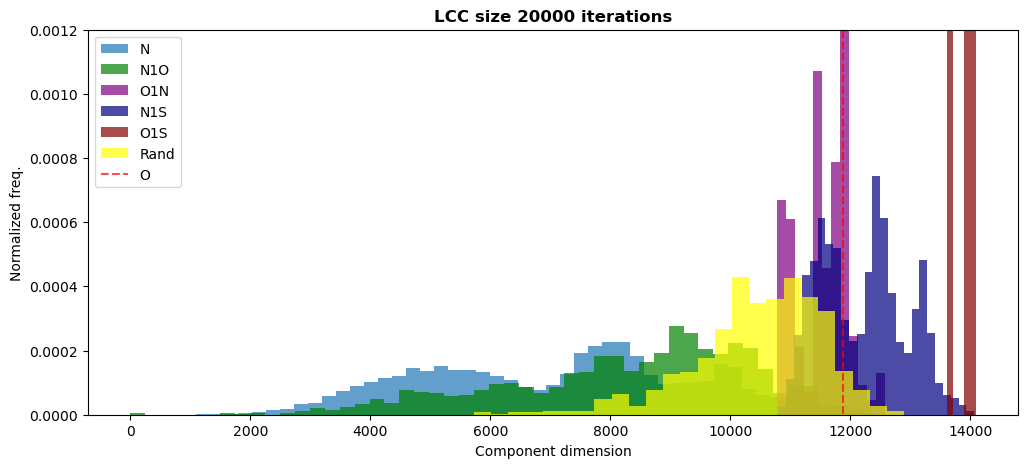

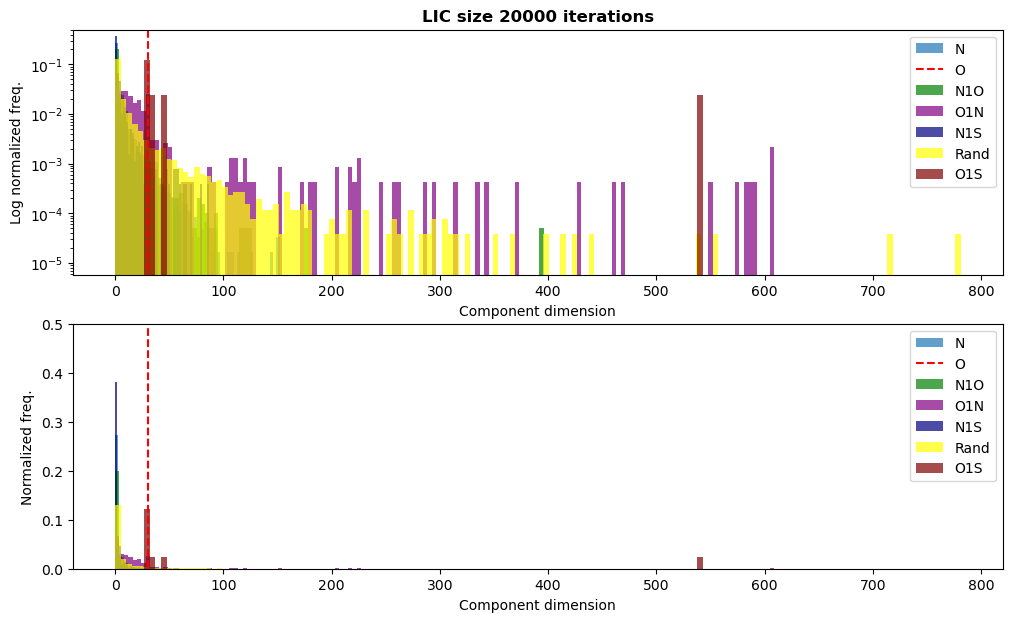

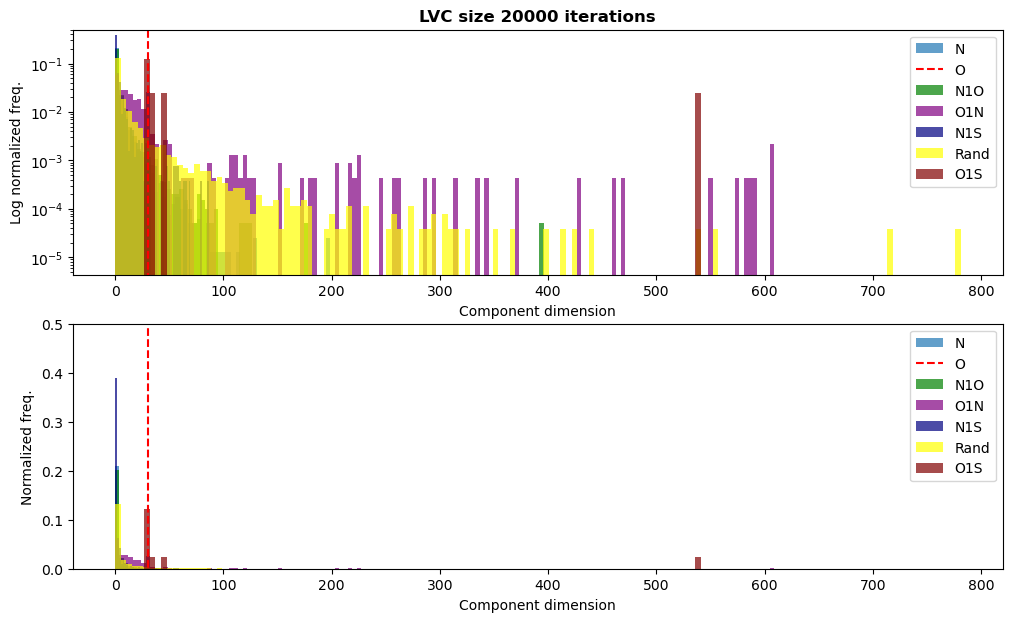

In [86]:
#LCC
plt.figure(figsize=(12,5))

plt.hist(nonco_lcc_len, bins=50, density=True, label="N", alpha=0.7)
plt.hist(n1o_lcc, bins=50, density=True, label="N1O", color="green", alpha=0.7)
plt.hist(o1n_lcc, bins=12, density=True, label="O1N", color="purple", alpha=0.7)
plt.hist(n1s_lcc, bins=25, density=True, label="N1S", color="navy", alpha=0.7)
plt.hist(o1s_lcc, bins=5, density=True, label="O1S", color="maroon", alpha=0.7)
plt.hist(random_lcc, bins=25, density=True, label="Rand", color="yellow", alpha=0.7)
plt.vlines(onco_lcc.shape[0], -100, 3000, ls="--", color="red", label="O", alpha=0.7)
plt.ylim([0,0.0012])
plt.legend()
plt.title("LCC size "+str(len(nonco_lic_len))+" iterations", fontsize=12, fontweight="bold")
plt.xlabel("Component dimension")
plt.ylabel("Normalized freq.")
plt.show()


#LIC
plt.figure(figsize=(12,7))
plt.subplot(2,1,1)

plt.hist(nonco_lic_len, bins=50, density=True, alpha=0.7, label="N")
plt.vlines(onco_lic.shape[0], -100, 20000, ls="--", color="red", label="O")
plt.hist(n1o_lic_len, bins=100, density=True, label="N1O", color="green", alpha=0.7)
plt.hist(o1n_lic_len, bins=150, density=True, label="O1N", color="purple", alpha=0.7)
plt.hist(n1s_lic_len, bins=50, density=True, label="N1S", color="navy", alpha=0.7)
plt.hist(random_lic_len, bins=150, density=True, label="Rand", color="yellow", alpha=0.7)
plt.hist(o1s_lic_len, bins=100, density=True,label="O1S", alpha=0.7, color="maroon")

plt.yscale("log")
plt.ylim([0,0.5])
#plt.xlim([-10,80])
plt.legend()
plt.title("LIC size "+str(len(nonco_lic_len))+" iterations", fontsize=12, fontweight="bold")
plt.xlabel("Component dimension")
plt.ylabel("Log normalized freq.")

plt.subplot(2,1,2)
plt.hist(nonco_lic_len, bins=50, density=True, alpha=0.7, label="N")
plt.vlines(onco_lic.shape[0], -100, 20000, ls="--", color="red", label="O")
plt.hist(n1o_lic_len, bins=100, density=True, label="N1O", color="green", alpha=0.7)
plt.hist(o1n_lic_len, bins=150, density=True, label="O1N", color="purple", alpha=0.7)
plt.hist(n1s_lic_len, bins=50, density=True, label="N1S", color="navy", alpha=0.7)
plt.hist(random_lic_len, bins=150, density=True, label="Rand", color="yellow", alpha=0.7)
plt.hist(o1s_lic_len, bins=100, density=True,label="O1S", alpha=0.7, color="maroon")
plt.ylim([0,0.5])
#plt.xlim([-10,80])
plt.legend()
plt.xlabel("Component dimension")
plt.ylabel("Normalized freq.")

plt.show()

#LVC
plt.figure(figsize=(12,7))
plt.subplot(2,1,1)

plt.hist(nonco_lvc_len, bins=50, density=True, alpha=0.7, label="N")
plt.vlines(onco_lvc.shape[0], -100, 20000, ls="--", color="red", label="O")
plt.hist(n1o_lvc_len, bins=100, density=True, label="N1O", color="green", alpha=0.7)
plt.hist(o1n_lvc_len, bins=150, density=True, label="O1N", color="purple", alpha=0.7)
plt.hist(n1s_lvc_len, bins=50, density=True, label="N1S", color="navy", alpha=0.7)
plt.hist(random_lvc_len, bins=150, density=True, label="Rand", color="yellow", alpha=0.7)
plt.hist(o1s_lvc_len, bins=100, density=True,label="O1S", alpha=0.7, color="maroon")
plt.yscale("log")
plt.ylim([0,0.5])
#plt.xlim([-10,80])
plt.legend()
plt.title("LVC size "+str(len(nonco_lic_len))+" iterations", fontsize=12, fontweight="bold")
plt.xlabel("Component dimension")
plt.ylabel("Log normalized freq.")

plt.subplot(2,1,2)
plt.hist(nonco_lvc_len, bins=50, density=True, alpha=0.7, label="N")
plt.vlines(onco_lvc.shape[0], -100, 20000, ls="--", color="red", label="O")
plt.hist(n1o_lvc_len, bins=100, density=True, label="N1O", color="green", alpha=0.7)
plt.hist(o1n_lvc_len, bins=150, density=True, label="O1N", color="purple", alpha=0.7)
plt.hist(n1s_lvc_len, bins=50, density=True, label="N1S", color="navy", alpha=0.7)
plt.hist(random_lvc_len, bins=150, density=True, label="Rand", color="yellow", alpha=0.7)
plt.hist(o1s_lvc_len, bins=100, density=True,label="O1S", alpha=0.7, color="maroon")
plt.ylim([0,0.5])
#plt.xlim([-10,80])
plt.legend()
plt.xlabel("Component dimension")
plt.ylabel("Normalized freq.")

plt.show()

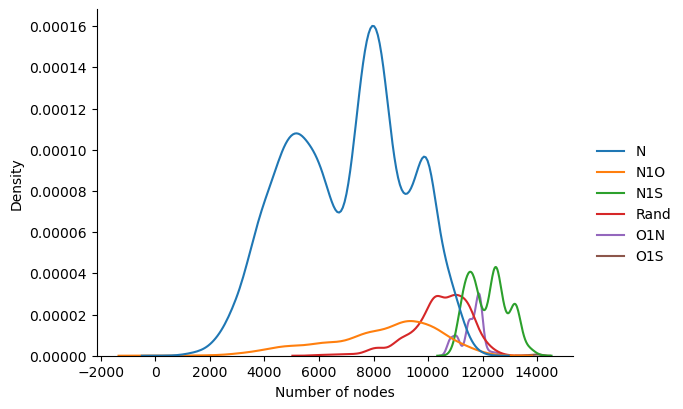

In [92]:
sns.displot(dict({"N":nonco_lcc_len,
                    "N1O":n1o_lcc,
                    "N1S":n1s_lcc,
                    "Rand":random_lcc,
                    "O1N":o1n_lcc,
                    "O1S":o1s_lcc}),
            kind="kde", 
            height=4,
            aspect=1.5,
            )
plt.xlabel("Number of nodes")
plt.show()

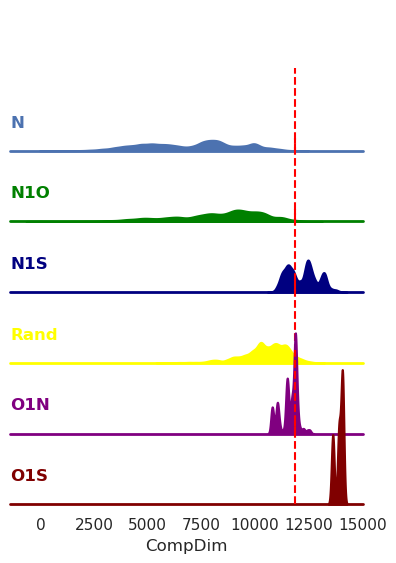

In [39]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

g = np.concatenate([["N"]*len(nonco_lcc_len),
                    ["N1O"]*len(n1o_lcc),
                    ["N1S"]*len(n1s_lcc),
                    ["Rand"]*len(random_lcc),
                    ["O1N"]*len(o1n_lcc),
                    ["O1S"]*len(o1s_lcc)])
                   
x = np.concatenate([nonco_lcc_len, n1o_lcc, n1s_lcc, random_lcc, o1n_lcc, o1s_lcc])
df = pd.DataFrame(dict(CompDim=x, g=g))
pal = ["C0","green", "navy", "yellow", "purple", "maroon"]#sns.color_palette("bright", 7)
g = sns.FacetGrid(df, row="g", hue="g", aspect=5, height=1, palette=pal)
g.map(sns.kdeplot, "CompDim",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)
    ax.vlines(len(onco_lcc), 0 ,0.0018, ls="--", color="red")
g.map(label, "CompDim")
g.figure.subplots_adjust(hspace=-.5)
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

In [30]:
print("N:\t %.3e" %(len(nonco_lcc_len[nonco_lcc_len>len(onco_lcc)])/len(nonco_lcc_len)))
print("N1O:\t %.3e" %(len(n1o_lcc[n1o_lcc>len(onco_lcc)])/len(n1o_lcc)))
print("N1S:\t %.3e" %(len(n1s_lcc[n1s_lcc>len(onco_lcc)])/len(n1s_lcc)))
print("Rand:\t %.3e" %(len(random_lcc[random_lcc>len(onco_lcc)])/len(random_lcc)))
print("O1N:\t %.3e" %(len(o1n_lcc[o1n_lcc>len(onco_lcc)])/len(o1n_lcc)))
print("O1S:\t %.3e" %(len(o1s_lcc[o1s_lcc>len(onco_lcc)])/len(o1s_lcc)))

N:	 2.000e-04
N1O:	 9.491e-03
N1S:	 6.019e-01
Rand:	 5.250e-02
O1N:	 2.588e-01
O1S:	 1.000e+00


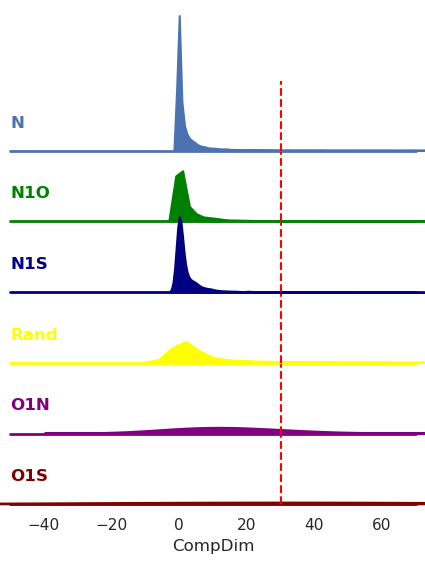

In [51]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

g = np.concatenate([["N"]*len(nonco_lic_len),
                    ["N1O"]*len(n1o_lic_len),
                    ["N1S"]*len(n1s_lic_len),
                    ["Rand"]*len(random_lic_len),
                    ["O1N"]*len(o1n_lic_len),
                    ["O1S"]*len(o1s_lic_len)])
                   
x = np.concatenate([nonco_lic_len, n1o_lic_len, n1s_lic_len, random_lic_len, o1n_lic_len, o1s_lic_len])
df = pd.DataFrame(dict(CompDim=x, g=g))
pal = ["C0","green", "navy", "yellow", "purple", "maroon"]#sns.color_palette("bright", 7)
g = sns.FacetGrid(df, row="g", hue="g", aspect=5, height=1, palette=pal, xlim=[-50,70])
g.map(sns.kdeplot, "CompDim",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)
    ax.vlines(len(onco_lic),0,0.25, color="red", ls="--")
g.map(label, "CompDim")
g.figure.subplots_adjust(hspace=-.5)
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)


In [33]:
n1o_lvc_len=np.array(n1o_lvc_len)
n1s_lvc_len=np.array(n1s_lvc_len)
random_lvc_len=np.array(random_lvc_len)
o1n_lvc_len=np.array(o1n_lvc_len)
o1s_lvc_len=np.array(o1s_lvc_len)

In [32]:
print("N:\t %.3e" %(len(nonco_lic_len[nonco_lic_len>len(onco_lic)])/len(nonco_lic_len)))
print("N1O:\t %.3e" %(len(n1o_lic_len[n1o_lic_len>len(onco_lic)])/len(n1o_lic_len)))
print("N1S:\t %.3e" %(len(n1s_lic_len[n1s_lic_len>len(onco_lic)])/len(n1s_lic_len)))
print("Rand:\t %.3e" %(len(random_lic_len[random_lic_len>len(onco_lic)])/len(random_lic_len)))
print("O1N:\t %.3e" %(len(o1n_lic_len[o1n_lic_len>len(onco_lic)])/len(o1n_lic_len)))
print("O1S:\t %.3e" %(len(o1s_lic_len[o1s_lic_len>len(onco_lic)])/len(o1s_lic_len)))

N:	 9.850e-03
N1O:	 1.940e-02
N1S:	 1.532e-02
Rand:	 9.380e-02
O1N:	 1.567e-01
O1S:	 3.750e-01


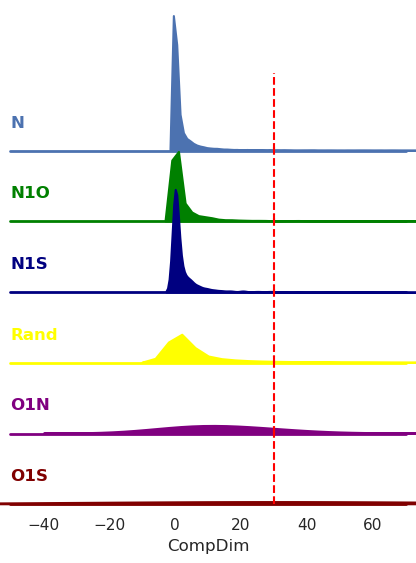

In [50]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

g = np.concatenate([["N"]*len(nonco_lvc_len),
                    ["N1O"]*len(n1o_lvc_len),
                    ["N1S"]*len(n1s_lvc_len),
                    ["Rand"]*len(random_lvc_len),
                    ["O1N"]*len(o1n_lvc_len),
                    ["O1S"]*len(o1s_lvc_len)])
                   
x = np.concatenate([nonco_lvc_len, n1o_lvc_len, n1s_lvc_len, random_lvc_len, o1n_lvc_len, o1s_lvc_len])
df = pd.DataFrame(dict(CompDim=x, g=g))
pal = ["C0","green", "navy", "yellow", "purple", "maroon"]#sns.color_palette("bright", 7)
g = sns.FacetGrid(df, row="g", hue="g", aspect=5, height=1, palette=pal, xlim=[-50,70])
g.map(sns.kdeplot, "CompDim",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)
    ax.vlines(len(onco_lvc),0,0.21, color="red", ls="--")
g.map(label, "CompDim")
g.figure.subplots_adjust(hspace=-.5)
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)


In [34]:
print("N:\t %.3e" %(len(nonco_lvc_len[nonco_lvc_len>len(onco_lvc)])/len(nonco_lvc_len)))
print("N1O:\t %.3e" %(len(n1o_lvc_len[n1o_lvc_len>len(onco_lvc)])/len(n1o_lvc_len)))
print("N1S:\t %.3e" %(len(n1s_lvc_len[n1s_lvc_len>len(onco_lvc)])/len(n1s_lvc_len)))
print("Rand:\t %.3e" %(len(random_lvc_len[random_lvc_len>len(onco_lvc)])/len(random_lvc_len)))
print("O1N:\t %.3e" %(len(o1n_lvc_len[o1n_lvc_len>len(onco_lvc)])/len(o1n_lvc_len)))
print("O1S:\t %.3e" %(len(o1s_lvc_len[o1s_lvc_len>len(onco_lvc)])/len(o1s_lvc_len)))

N:	 9.600e-03
N1O:	 1.940e-02
N1S:	 1.532e-02
Rand:	 9.380e-02
O1N:	 1.567e-01
O1S:	 3.750e-01


In [35]:
percentile_list = [10,25,30,50,60,65,75,90]
pd.DataFrame({"LCC":[int(np.percentile(nonco_lcc_len, pc)) for pc in percentile_list],
              "LIC":[int(np.percentile(nonco_lic_len, pc)) for pc in percentile_list],
            "LVC":[int(np.percentile(nonco_lvc_len, pc)) for pc in percentile_list]}, index=[str(p)+"%" for p in percentile_list])

,LCC,LIC,LVC
10%,4092,0,0
25%,5228,0,0
30%,5586,0,0
50%,7404,0,0
60%,7891,1,1
65%,8109,1,1
75%,8617,2,2
90%,9954,6,6


In [36]:
pvalue_compLCC_nonco = len(nonco_lcc_len[nonco_lcc_len>onco_lcc.shape[0]])/len(nonco_lcc_len)
pvalue_compLCC_o1n = len(o1n_lcc[o1n_lcc>onco_lcc.shape[0]])/len(o1n_lcc)
pvalue_compLCC_n1o = len(n1o_lcc[n1o_lcc>onco_lcc.shape[0]])/len(n1o_lcc)
print(f"LCC \n Onco => Number of extreme values : {int(pvalue_compLCC_nonco*len(nonco_lcc_len))} \t P-value: {pvalue_compLCC_nonco}")
print(f"O1N => Number of extreme values : {int(pvalue_compLCC_o1n*len(o1n_lcc))} \t P-value: {pvalue_compLCC_o1n}")
print(f"N1O => Number of extreme values : {int(pvalue_compLCC_n1o*len(n1o_lcc))} \t P-value: {pvalue_compLCC_n1o}")

pvalue_compLIC_nonco = len(nonco_lic_len[nonco_lic_len>onco_lic.shape[0]])/len(nonco_lic_len)
print(f"LIC \n Number of extreme values : {int(pvalue_compLIC_nonco*len(nonco_lic_len))}  P-value: {pvalue_compLIC_nonco}")

pvalue_compLVC_nonco = len(nonco_lvc_len[nonco_lvc_len>onco_lvc.shape[0]])/len(nonco_lvc_len)
print(f"LIC \n Number of extreme values : {int(pvalue_compLVC_nonco*len(nonco_lvc_len))}  P-value: {pvalue_compLVC_nonco}")

LCC 
 Onco => Number of extreme values : 4 	 P-value: 0.0002
O1N => Number of extreme values : 147 	 P-value: 0.25880281690140844
N1O => Number of extreme values : 19 	 P-value: 0.00949050949050949
LIC 
 Number of extreme values : 197  P-value: 0.00985
LIC 
 Number of extreme values : 191  P-value: 0.0096


In [37]:
#nonco_lcc = mxp.utils.readComponent("Files/Components/nonco_lcc_20k.txt")
nonco_lic = mxp.utils.readComponent("Files/Components/nonco_lic_20k.txt")
nonco_lvc = mxp.utils.readComponent("Files/Components/nonco_lvc_20k.txt")

In [38]:
#uniq_lcc, cnt_lcc = np.unique(np.concatenate(nonco_lcc), return_counts=True)
uniq_lic, cnt_lic = np.unique(np.concatenate(nonco_lic), return_counts=True)
uniq_lvc, cnt_lvc = np.unique(np.concatenate(nonco_lvc), return_counts=True)

In [39]:
uniq_lic_name = np.array(list(node_map_dict.keys()))[list(uniq_lic.astype(int))]
uniq_lvc_name = np.array(list(node_map_dict.keys()))[list(uniq_lvc.astype(int)-1)] #lvc are produced in R that starts the conunt from 1

In [40]:
freq_lic = pd.DataFrame({"Prot": uniq_lic_name, "Freq": cnt_lic})
freq_lvc = pd.DataFrame({"Prot": uniq_lvc_name, "Freq": cnt_lvc})

In [41]:
sorted_freq_lic = freq_lic.sort_values("Freq", ascending=False).head(100)
sorted_freq_lic = sorted_freq_lic.reset_index(drop=True)

sorted_freq_lvc = freq_lvc.sort_values("Freq", ascending=False).head(100)
sorted_freq_lvc = sorted_freq_lvc.reset_index(drop=True)

In [42]:
sorted_freq_lic.head(10)

,Prot,Freq
0,RELA,2727
1,TP53,2691
2,TNF,2024
3,MYC,2006
4,NTRK1,1721
5,TRIM25,1432
6,UBC,1055
7,HSP90AA1,933
8,CTNNB1,895
9,NFKB1,862


In [66]:
freq_lvc.sort_values("Freq")

,Prot,Freq
938,PTK6,1
380,MDM4,1
184,HAUS1,1
379,DUT,1
641,EIF3I,1
...,...,...
19,NTRK1,1530
15,MYC,2025
3,TNF,2048
85,TP53,2649


In [44]:
sorted_freq_lvc[sorted_freq_lvc["Prot"]=="RELA"].index[0]

0

In [45]:
def sigma_dist(index):
    name1 = sorted_freq_lic.loc[index,"Prot"]
    sel2 = sorted_freq_lvc[sorted_freq_lvc["Prot"]==name1]
    if sel2.shape[0]==0:
        raise ValueError("Different proteins")
    index2 = sel2.index[0]
    name2 = sorted_freq_lvc.loc[index2, "Prot"]
    a1=sorted_freq_lvc.loc[index,"Freq"]
    s1=np.sqrt(sorted_freq_lvc.loc[index,"Freq"])
    a2=sorted_freq_lic.loc[index2,"Freq"]
    s2=np.sqrt(sorted_freq_lic.loc[index2,"Freq"])

    a1c, a2c = np.array([a1,a2])[np.argsort([a1,a2])]
    s1c, s2c = np.array([s1,s2])[np.argsort([a1,a2])]
    nsig = 0
    while a1c<a2c:
        a1c+=s1c
        a2c-=s2c
        nsig+=1
    return {"Prot":name1, "sigma_dist":nsig}

In [46]:
sigma_dist(0)

{'Prot': 'RELA', 'sigma_dist': 2}

In [90]:
for i in range(20):
    try: 
        print(sigma_dist(i)["Prot"]+"    ","\tsigma distance:", sigma_dist(i)["sigma_dist"])
    except:
        print("Not corresponding")

RELA     	sigma distance: 2
TP53     	sigma distance: 1
TNF     	sigma distance: 1
MYC     	sigma distance: 1
NTRK1     	sigma distance: 3
TRIM25     	sigma distance: 1
UBC     	sigma distance: 1
HSP90AA1     	sigma distance: 4
CTNNB1     	sigma distance: 1
NFKB1     	sigma distance: 2
COPS5     	sigma distance: 2
AKT1     	sigma distance: 2
RPS27A     	sigma distance: 2
APP     	sigma distance: 1
KIAA1429     	sigma distance: 1
CUL1     	sigma distance: 1
UBA52     	sigma distance: 1
JUN     	sigma distance: 1
KRAS     	sigma distance: 0
MAPK3     	sigma distance: 1


In [72]:
np.array(freq_lvc[freq_lvc["Freq"]>2600].Prot)

array(['RELA', 'TP53'], dtype=object)

In [48]:
onco_lic_prot = np.array(list(net_onco.node_map.keys()))[onco_lic]
onco_lvc_prot = np.array(list(net_onco.node_map.keys()))[onco_lvc]

In [68]:
(np.array(freq_lvc[freq_lic["Freq"]>2600].Prot))

array(['RELA', 'PSMD8'], dtype=object)

In [78]:
for thre in [0,0.2,0.5,1,2,3,4,5,6,7,10]: 
    most_frequent_nonco_lic=(np.array(freq_lic[freq_lic["Freq"]>(len(nonco_lic_len)*(thre/100))].Prot))
    most_frequent_nonco_lvc=(np.array(freq_lvc[freq_lvc["Freq"]>(len(nonco_lvc_len)*(thre/100))].Prot))
    onco_in_nonco_lic = onco_lic_prot[np.where(np.isin(onco_lic_prot, most_frequent_nonco_lic))[0]]
    onco_in_nonco_lvc = onco_lvc_prot[np.where(np.isin(onco_lvc_prot, most_frequent_nonco_lvc))[0]]
    #print(f"\tOnco in Nonco LIC, threshold={thre}%")
    print((" ").join(list(onco_in_nonco_lvc)),"\n")
    #print("LVC =>",(" ").join(list(onco_in_nonco_lvc)))
    
onco_in_nonco_lic = onco_lic_prot[np.where(np.isin(onco_lic_prot, freq_lic.Prot))[0]]
onco_in_nonco_lvc = onco_lvc_prot[np.where(np.isin(onco_lvc_prot, freq_lvc.Prot))[0]]

TP73 SMAD3 PIAS1 UBE2I MDM4 SKI MAP3K1 TRIM25 PML FBXW7 PIN1 ABL1 SMAD2 MDM2 DAXX RNF4 KIAA1429 HNRNPL PARP1 TP53 CREBBP 

MAP3K1 TRIM25 PML FBXW7 PIN1 SMAD2 MDM2 RNF4 KIAA1429 TP53 CREBBP 

TRIM25 FBXW7 MDM2 KIAA1429 TP53 CREBBP 

TRIM25 KIAA1429 TP53 CREBBP 

TRIM25 KIAA1429 TP53 CREBBP 

TRIM25 KIAA1429 TP53 

TRIM25 TP53 

TRIM25 TP53 

TRIM25 TP53 

TRIM25 TP53 

TP53 



	Onco in Nonco LIC, threshold=0% 

LIC => PPM1D NKX2-1 SUMO2 RANBP9 ACTBL2 HIST2H2BE CTBP1 

LVC => PPM1D SMAD3 PIAS1 UBE2I MDM4 SKI SUMO2 RANBP9 ACTBL2 PML CBX4 FBXW7 HIST2H2BE HMGA1 ABL1 SMAD2 RNF4 KIAA1429 HNRNPL CTBP1 CREBBP 

	Onco in Nonco LIC, threshold=0.5% 

LIC => PPM1D TP73 SMAD3 NKX2-1 PIAS1 UBE2I MDM4 SKI SUMO2 RANBP9 MAP3K1 ACTBL2 PML CBX4 HIST2H2BE HMGA1 ABL1 SMAD2 DAXX RNF4 HNRNPL PARP1 CTBP1 

LVC => PPM1D TP73 SMAD3 NKX2-1 PIAS1 UBE2I MDM4 SKI SUMO2 RANBP9 MAP3K1 TRIM25 ACTBL2 PML CBX4 FBXW7 PIN1 HIST2H2BE HMGA1 ABL1 SMAD2 MDM2 DAXX RNF4 KIAA1429 HNRNPL CTBP1 TP53 CREBBP 

	Onco in Nonco LIC, threshold=1% 

LIC => PPM1D TP73 SMAD3 NKX2-1 PIAS1 UBE2I MDM4 SKI SUMO2 RANBP9 MAP3K1 ACTBL2 PML CBX4 FBXW7 PIN1 HIST2H2BE HMGA1 ABL1 SMAD2 DAXX RNF4 HNRNPL PARP1 CTBP1 

LVC => PPM1D TP73 SMAD3 NKX2-1 PIAS1 UBE2I MDM4 SKI SUMO2 RANBP9 MAP3K1 TRIM25 ACTBL2 PML CBX4 FBXW7 PIN1 HIST2H2BE HMGA1 ABL1 SMAD2 MDM2 DAXX RNF4 KIAA1429 HNRNPL CTBP1 TP53 CREBBP 

	Onco in Nonco LIC, thresh

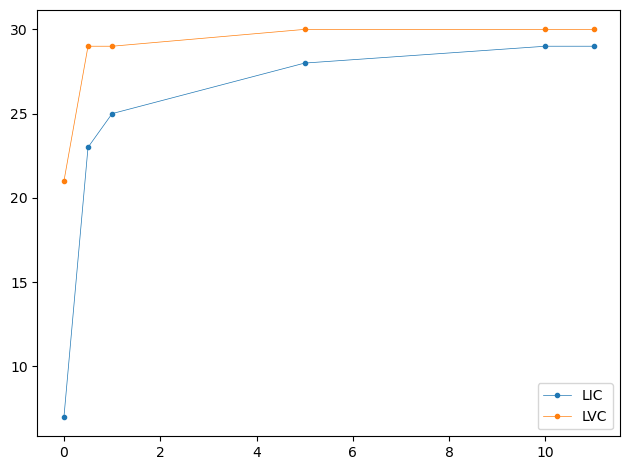

In [16]:
thresh_non = [0,0.5,1,5,10,11]
lic_list_non = []
lvc_list_non = []
for thre in thresh_non: 
    most_frequent_nonco_lic=(np.array(freq_lic[freq_lic["Freq"]>(len(nonco_lic_len)*(thre/100))].Prot))
    most_frequent_nonco_lvc=(np.array(freq_lvc[freq_lic["Freq"]>(len(nonco_lvc_len)*(thre/100))].Prot))
    onco_in_nonco_lic = onco_lic_prot[np.where(np.logical_not(np.isin(onco_lic_prot, most_frequent_nonco_lic))) [0]]
    onco_in_nonco_lvc = onco_lvc_prot[np.where(np.logical_not(np.isin(onco_lvc_prot, most_frequent_nonco_lvc)))[0]]
    lic_list_non.append(len(onco_in_nonco_lic))
    lvc_list_non.append(len(onco_in_nonco_lvc))
    print(f"\tOnco in Nonco LIC, threshold={thre}%","\n")
    print("LIC =>",(" ").join(list(onco_in_nonco_lic)),"\n")
    print("LVC =>",(" ").join(list(onco_in_nonco_lvc)),"\n")
    
plt.plot(thresh_non, lic_list_non, ".-", lw=0.5, label="LIC")
plt.plot(thresh_non, lvc_list_non, ".-", lw=0.5, label="LVC")
plt.legend()
plt.tight_layout()

onco_notin_nonco_lic = onco_lic_prot[np.where(np.logical_not(np.isin(onco_lic_prot, freq_lic.Prot))) [0]]
onco_notin_nonco_lvc = onco_lvc_prot[np.where(np.logical_not(np.isin(onco_lvc_prot, freq_lic.Prot)))[0]]

In [77]:
nonco_lic_prot = np.array(freq_lic.sort_values("Freq", ascending=False).head(100)["Prot"])
nonco_lvc_prot = np.array(freq_lvc.sort_values("Freq", ascending=False).head(100)["Prot"])

In [94]:
for i in []
    onco_in_nonco_lic = onco_lic_prot[np.where(np.isin(onco_lic_prot, nonco_lic_prot))[0]]
    onco_in_nonco_lvc = onco_lvc_prot[np.where(np.isin(onco_lvc_prot, nonco_lvc_prot))[0]]
    print("Onco LIC proteins in nonco LIC: ", (" ").join(list(onco_in_nonco_lic)))
    print("Onco LVC proteins in nonco LVC: ", (" ").join(list(onco_in_nonco_lvc)))


#nonco_in_onco_lic = nonco_lic_prot[np.where(np.isin(nonco_lic_prot, onco_lic_prot))[0]]
#nonco_in_onco_lvc = nonco_lvc_prot[np.where(np.isin(nonco_lvc_prot, onco_lvc_prot))[0]]

In [96]:
print("Onco LIC proteins in nonco LIC: ", (" ").join(list(onco_in_nonco_lic)))
print("Onco LVC proteins in nonco LVC: ", (" ").join(list(onco_in_nonco_lvc)))

print("Nonco LIC proteins in onco LIC: ", (" ").join(list(nonco_in_onco_lic)))
print("Nonco LVC proteins in onco LVC: ", (" ").join(list(nonco_in_onco_lvc)))

Onco LIC proteins in nonco LIC:  TRIM25 FBXW7 PIN1 MDM2 KIAA1429 TP53 CREBBP
Onco LVC proteins in nonco LVC:  MDM2 TP53
Nonco LIC proteins in onco LIC:  TP53 TRIM25 KIAA1429 CREBBP MDM2 FBXW7 PIN1
Nonco LVC proteins in onco LVC:  MDM2 TP53


## Percolation

In [6]:
"""
np.savetxt(fname="Files/Percolation/CritPoint/nonco_crit_point.txt", X=nonco_max_critp, fmt="%.6f")
nonco_max_critp = np.concatenate([np.loadtxt("Files/Percolation/CritPoint/nonco_agg_crit_point_5000.txt"),
                                  np.loadtxt("Files/Percolation/CritPoint/nonco_agg_crit_point_15000.txt")])
np.savetxt(X=nonco_max_critp, fname="Files/Percolation/CritPoint/nonco_pr.txt")
"""
nonco_critp = np.loadtxt("Files/Percolation/CritPoint/nonco_pr.txt")
o1s_critp = np.loadtxt("Files/Percolation/CritPoint/Sonco_pr.txt")
n1s_critp = np.loadtxt("Files/Percolation/CritPoint/Snonco_pr.txt")
o1n_critp = np.loadtxt("Files/Percolation/CritPoint/o1n_pr.txt")
n1o_critp = np.loadtxt("Files/Percolation/CritPoint/n1o_pr.txt")
random_critp = np.loadtxt("Files/Percolation/CritPoint/n1o_pr.txt")
onco_perc_point = onco_perc["CritPoint"]#0.3024 #arrotondamento risultato



In [7]:
print("\t\t NONCO \t SONCO \t SNONCO\t RAND \t O1N \t N1O")
print("Nr. of samples: %d \t %d \t %d \t %d \t %d \t %d" %(len(nonco_critp),
                                                           len(o1s_critp),
                                                           len(n1s_critp),
                                                           len(random_critp),
                                                           len(o1n_critp),
                                                           len(n1o_critp)))
print("Mean:\t\t %.3f \t %.3f \t %.3f \t %.3f \t %.3f \t %.3f" %(np.mean(nonco_critp),
                                                     np.mean(o1s_critp),
                                                     np.mean(n1s_critp),
                                                     np.mean(random_critp),
                                                     np.mean(o1n_critp),
                                                     np.mean(n1o_critp)))
print("Std:\t\t %.3f \t %.3f \t %.3f \t %.3f \t %.3f \t %.3f" %(np.std(nonco_critp),
                                                    np.std(o1s_critp),
                                                    np.std(n1s_critp),
                                                    np.std(random_critp),
                                                    np.std(o1n_critp),
                                                    np.std(n1o_critp)))
print("Median:\t\t %.3f \t %.3f \t %.3f \t %.3f \t %.3f \t %.3f" %(np.median(nonco_critp),
                                                       np.median(o1s_critp),
                                                       np.median(n1s_critp),
                                                       np.median(random_critp),
                                                       np.median(o1n_critp),
                                                       np.median(n1o_critp)))

		 NONCO 	 SONCO 	 SNONCO	 RAND 	 O1N 	 N1O
Nr. of samples: 20000 	 8 	 21500 	 5000 	 568 	 5000
Mean:		 0.327 	 0.308 	 0.265 	 0.309 	 0.299 	 0.309
Std:		 0.045 	 0.008 	 0.023 	 0.038 	 0.009 	 0.038
Median:		 0.320 	 0.311 	 0.263 	 0.303 	 0.300 	 0.303


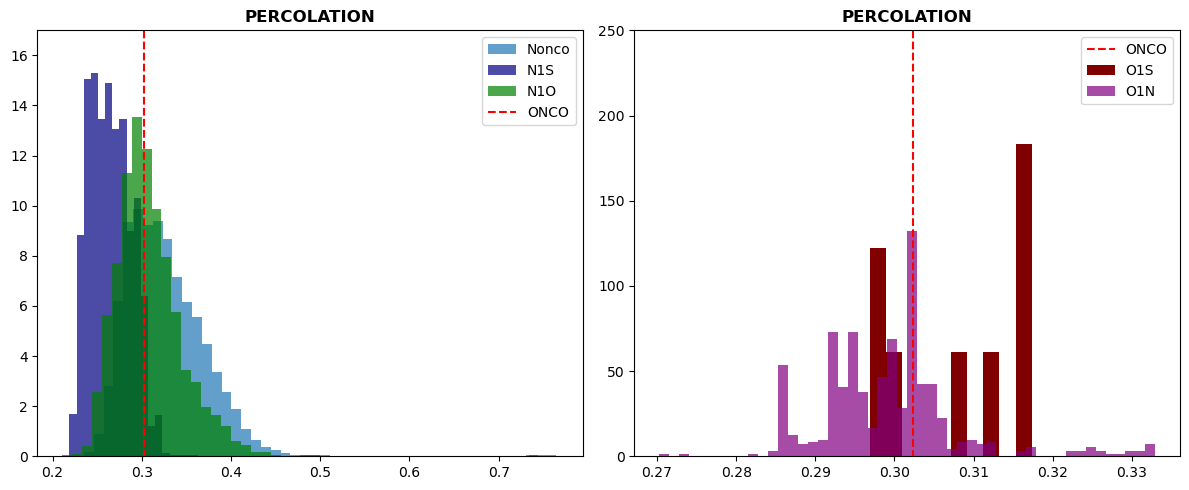

In [10]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(nonco_critp, bins=50, density=True, alpha=0.7, label="Nonco")
plt.hist(n1s_critp[2:], bins=20, density=True, alpha=0.7, color="navy", label="N1S")
plt.hist(n1o_critp, bins=50, density=True, alpha=0.7, label="N1O", color="green")
plt.vlines(onco_perc_point, -100, 300, ls="--", color="red", label="ONCO")
plt.title("PERCOLATION", fontweight="bold")
plt.ylim([0,17])
plt.legend()
plt.tight_layout()

plt.subplot(1,2,2)
plt.vlines(onco_perc_point, -100, 300, ls="--", color="red", label="ONCO")
plt.hist(o1s_critp, density=True, bins=10, color="maroon", label="O1S")
plt.hist(o1n_critp, bins=50, density=True, alpha=0.7, label="O1N", color="purple")



#plt.vlines(np.mean(nonco_max_critp), -100, 3000, ls="--", color="black", lw=0.7, label="Mean")
#plt.vlines(np.median(nonco_max_critp), -100, 3000, ls="--", color="green", lw=0.7, label="Median")
#plt.hlines(200, *borders, color="purple")
plt.ylim([0,250])
plt.title("PERCOLATION", fontweight="bold")
plt.legend()
plt.tight_layout()

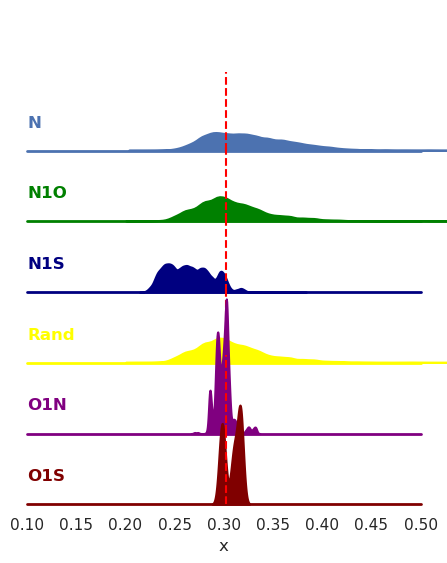

In [113]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Create the data
g = np.concatenate([["N"]*len(nonco_critp),
                    ["N1O"]*len(n1o_critp),
                    ["N1S"]*len(n1s_critp),
                    ["Rand"]*len(random_critp),
                    ["O1N"]*len(o1n_critp),
                    ["O1S"]*len(o1s_critp)])
x = np.concatenate([nonco_critp, n1o_critp, n1s_critp, random_critp, o1n_critp, o1s_critp])
df = pd.DataFrame(dict(x=x, g=g))
#m = df.g.map(ordfunc)
#df["x"]+=m

# Initialize the FacetGrid object
pal=["C0","green", "navy", "yellow", "purple", "maroon"]#sns.color_palette("bright", 7)
#sns.cubehelix_palette(6, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="g", hue="g", aspect=5, height=1, palette=pal, xlim=[0.1,0.5])

# Draw the densities in a few steps
g.map(sns.kdeplot, "x",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
#g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)
    ax.vlines(onco_perc["CritPoint"], 0,45, ls="--", color="red")

g.map(label, "x")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.5)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

In [22]:
#get the percentile value corresponding to the onco percolation critical point
onco_cp_percentile = nonco_critp[nonco_critp<onco_perc_point].shape[0]/len(nonco_critp)
print("Onco percolation critical point percentile: %.3f" %(onco_cp_percentile*100), "%")

Onco percolation critical point percentile: 33.430 %


In [24]:
#t-test
print(sp.stats.ttest_1samp(nonco_critp, onco_perc_point))
print(sp.stats.ttest_1samp(nonco_critp, nonco_critp[5]))

TtestResult(statistic=75.83813852557638, pvalue=0.0, df=19999)
TtestResult(statistic=133.97368594430463, pvalue=0.0, df=19999)


In [26]:
#chebyshev
fix_perc = 0.50
required_std = np.sqrt(1/(1-fix_perc))
borders = [np.mean(nonco_critp)-required_std*np.std(nonco_critp), 
           np.mean(nonco_critp)+required_std*np.std(nonco_critp)]

print("Fixed perc %.2f" % fix_perc)
print("Onco critP: %.3f" % onco_perc_point)
print("Borders: %.3f, %.3f" % (borders[0], borders[1]))
print("Does onco CritP falls in Chebyshev limits?", onco_perc_point>borders[0] and onco_perc_point<borders[1])


Fixed perc 0.50
Onco critP: 0.302
Borders: 0.263, 0.390
Does onco CritP falls in Chebyshev limits? True


In [27]:
# p-value
print("One sided test p-value: %.3f" %(len(nonco_critp[nonco_critp<onco_perc_point])/len(nonco_critp)))

print("Nr of standard deviation from mean: %.3f" %(abs(np.mean(nonco_critp)-onco_perc_point)/np.std(nonco_critp)))

One sided test p-value: 0.334
Nr of standard deviation from mean: 0.536


In [ ]:
def p_value(mu, X):
    xM = np.mean(X)
    S = np.std(X)
    z = (xM-mu)/(S)
    return sp.integrate.quad(lambda x: sp.stats.norm.pdf(x,0,1), z, np.Infinity)[0]

print("%.4f" % p_value(onco_max_perc, nonco_max_critp))
print("%.4f" % p_value(nonco_max_critp[4], nonco_max_critp))

## Modules and Modularity

In [14]:
"""
nall = np.loadtxt("Files/Mod/names_all.txt", dtype=int)
nm = np.loadtxt("Files/Mod/nonco_multi_names.txt", dtype=int)
ms = np.loadtxt("Files/Mod/nonco_multi_modules.txt")
my = np.loadtxt("Files/Mod/nonco_multi_modularity.txt")

nall_str = [(" ").join(n) for n in np.array(nall, dtype=str)]
nm_str = [(" ").join(n) for n in np.array(nm, dtype=str)]

corres_vec = []
for i in range(len(nall_str)):
    try:
        list(nm_str).index(nall_str[i])
    except:
        corres_vec.append([i, -1])
    else:
        corres_vec.append([i, list(nm_str).index(nall_str[i])])

corres_vec = np.array(corres_vec)

B = corres_vec[corres_vec[:,1]>=0]
A = np.arange(max(B[:,0]))
Ai=A[~np.isin(A, B[:,0])]

plt.figure(figsize=(5,3))
corres_vec = np.array(corres_vec)
np.where(corres_vec[:,0]==corres_vec[:,1])
plt.plot(B[:,0],B[:,0], ".", markersize=0.5)
plt.plot(Ai,Ai+100, ".",markersize=0.5)
plt.tight_layout()

print(f"Missing interval {Ai.min()},{Ai.max()}")

nm_res = nm[B[:,1]]
ms_res = ms[B[:,1]]
my_res = my[B[:,1]]
"""

'\nnall = np.loadtxt("Files/Mod/names_all.txt", dtype=int)\nnm = np.loadtxt("Files/Mod/nonco_multi_names.txt", dtype=int)\nms = np.loadtxt("Files/Mod/nonco_multi_modules.txt")\nmy = np.loadtxt("Files/Mod/nonco_multi_modularity.txt")\n\nnall_str = [(" ").join(n) for n in np.array(nall, dtype=str)]\nnm_str = [(" ").join(n) for n in np.array(nm, dtype=str)]\n\ncorres_vec = []\nfor i in range(len(nall_str)):\n    try:\n        list(nm_str).index(nall_str[i])\n    except:\n        corres_vec.append([i, -1])\n    else:\n        corres_vec.append([i, list(nm_str).index(nall_str[i])])\n\ncorres_vec = np.array(corres_vec)\n\nB = corres_vec[corres_vec[:,1]>=0]\nA = np.arange(max(B[:,0]))\nAi=A[~np.isin(A, B[:,0])]\n\nplt.figure(figsize=(5,3))\ncorres_vec = np.array(corres_vec)\nnp.where(corres_vec[:,0]==corres_vec[:,1])\nplt.plot(B[:,0],B[:,0], ".", markersize=0.5)\nplt.plot(Ai,Ai+100, ".",markersize=0.5)\nplt.tight_layout()\n\nprint(f"Missing interval {Ai.min()},{Ai.max()}")\n\nnm_res = nm[B[:,

In [4]:
onco_ms = np.loadtxt("Files/Mod/onco_mods_short.txt") 
onco_my = np.loadtxt("Files/Mod/onco_mody_short.txt")

nonco_ms = np.loadtxt("Files/Mod/Old/nonco_multi_modules_good.txt")
nonco_my = np.loadtxt("Files/Mod/Old/nonco_multi_modularity_good.txt")

Sonco_ms = np.loadtxt("Files/Mod/Sonco_mods.txt")
Sonco_my = np.loadtxt("Files/Mod/Sonco_mody.txt")

Snonco_ms = np.loadtxt("Files/Mod/Snonco_mods.txt")
Snonco_my = np.loadtxt("Files/Mod/Snonco_mody.txt")

random_ms = np.loadtxt("Files/Mod/random_mods.txt")
random_my = np.loadtxt("Files/Mod/random_mody.txt")

o1n_ms = np.loadtxt("Files/Mod/o1n_mods.txt")
o1n_my = np.loadtxt("Files/Mod/o1n_mody.txt")

n1o_ms = np.loadtxt("Files/Mod/n1o_mods.txt")
n1o_my = np.loadtxt("Files/Mod/n1o_mody.txt")


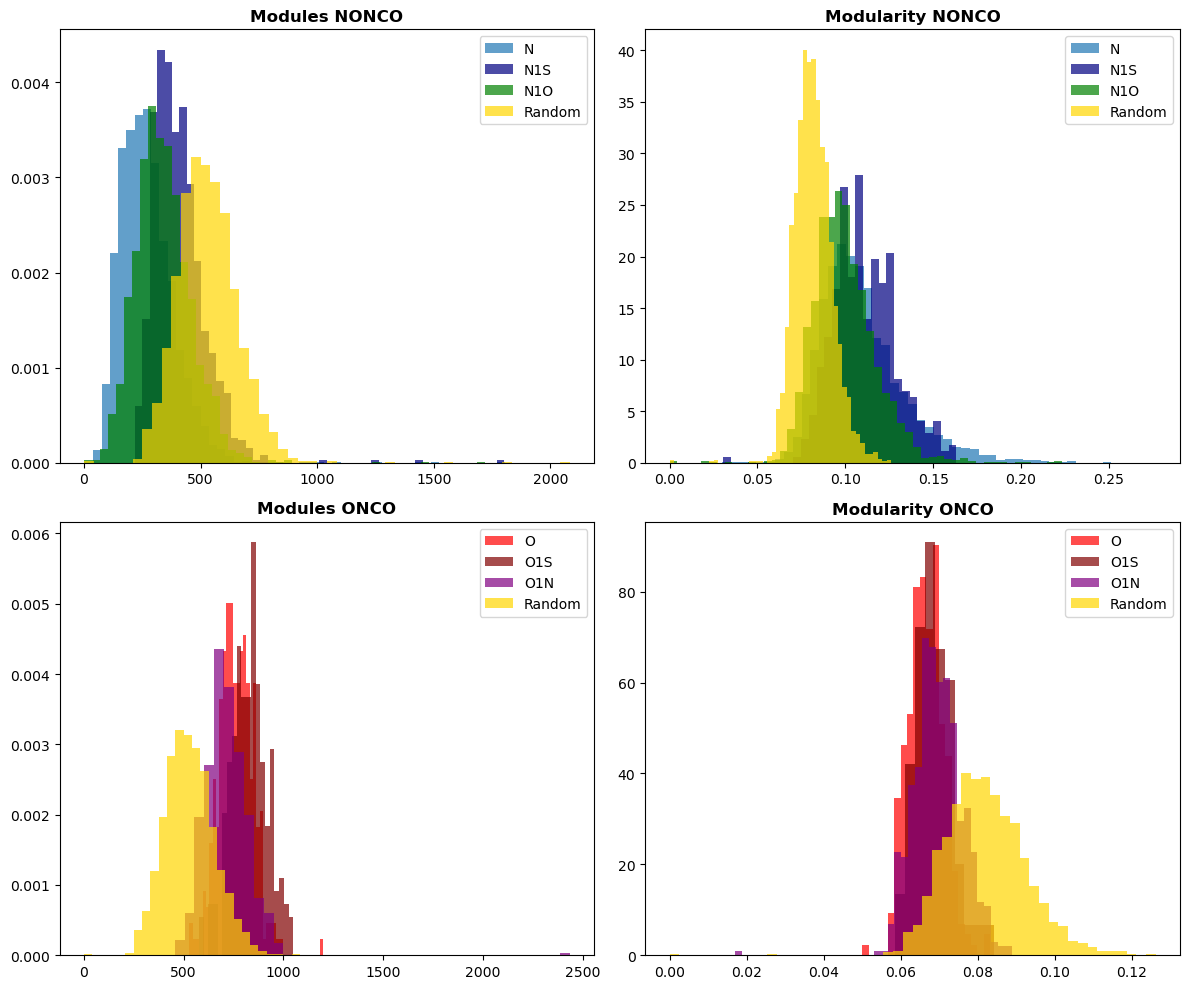

In [5]:
#load trials with onco multilayer net

#plot the two distributions
plt.figure(figsize=(12,10))

#NONCO
plt.subplot(2,2,1)
plt.hist(nonco_ms, bins=50, density=True, label="N", alpha=0.7)
plt.hist(Snonco_ms, bins= 50, density=True, label="N1S", alpha=0.7, color="navy")
plt.hist(n1o_ms, bins=50, density=True, label="N1O", alpha=0.7, color="green")
plt.hist(random_ms, bins=50, density=True, label="Random", alpha=0.7, color="gold")
plt.title("Modules NONCO", fontweight="bold")
plt.legend()

plt.subplot(2,2,2)
plt.hist(nonco_my, bins=50, density=True, label="N", alpha=0.7)
plt.hist(Snonco_my, bins= 30, density=True, label="N1S", alpha=0.7, color="navy")
plt.hist(n1o_my, bins=50, density=True, label="N1O", alpha=0.7, color="green")
plt.hist(random_my, bins=50, density=True, label="Random", alpha=0.7, color="gold")
plt.title("Modularity NONCO", fontweight="bold")
plt.legend()



#ONCO
plt.subplot(2,2,3)
plt.hist(onco_ms, density=True, bins=40, label="O", alpha=0.7, color="red")
plt.hist(Sonco_ms, bins= 20, density=True, label="O1S", alpha=0.7, color="maroon")
plt.hist(o1n_ms[2:], bins= 40, density=True, label="O1N", alpha=0.7, color="purple")
plt.hist(random_ms, bins=50, density=True, label="Random", alpha=0.7, color="gold")
plt.title("Modules ONCO", fontweight="bold")
plt.legend()

plt.subplot(2,2,4)
plt.hist(onco_my, density=True, bins=20, label="O", alpha=0.7, color="red")
plt.hist(Sonco_my, bins= 10, density=True, label="O1S", alpha=0.7, color="maroon")
plt.hist(o1n_my[2:], bins= 40, density=True, label="O1N", alpha=0.7, color="purple")
plt.hist(random_my, bins=50, density=True, label="Random", alpha=0.7, color="gold")
plt.title("Modularity ONCO", fontweight="bold")
plt.legend()

plt.tight_layout()

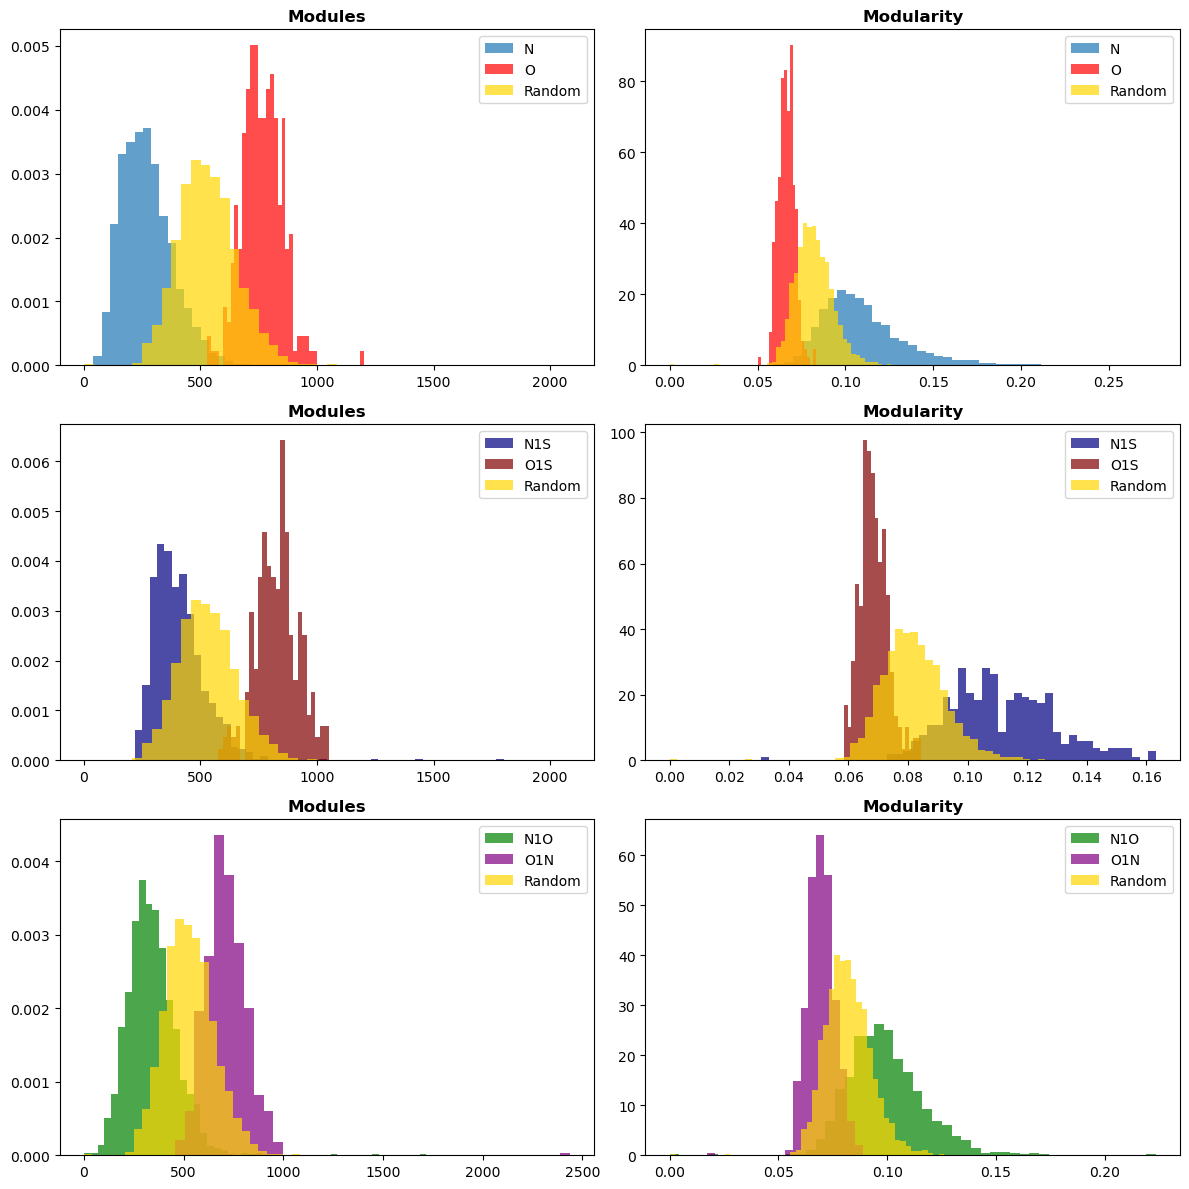

In [6]:
plt.figure(figsize=(12,12))
plt.subplot(3,2,1)
plt.hist(nonco_ms, bins=50, density=True, label="N", alpha=0.7)
plt.hist(onco_ms, bins= 40, density=True, label="O", alpha=0.7, color="red")
plt.hist(random_ms, bins=50, density=True, label="Random", alpha=0.7, color="gold")
plt.title("Modules", fontweight="bold")
plt.legend()

plt.subplot(3,2,2)
plt.hist(nonco_my, bins=50, density=True, label="N", alpha=0.7)
plt.hist(onco_my, density=True, bins=20, label="O", alpha=0.7, color="red")
plt.hist(random_my, bins=50, density=True, label="Random", alpha=0.7, color="gold")
plt.title("Modularity", fontweight="bold")
plt.legend()
plt.tight_layout()

plt.subplot(3,2,3)
plt.hist(Snonco_ms, bins=50, density=True, label="N1S", alpha=0.7, color="navy")
plt.hist(Sonco_ms, bins= 25, density=True, label="O1S", alpha=0.7, color="maroon")
plt.hist(random_ms, bins=50, density=True, label="Random", alpha=0.7, color="gold")
plt.title("Modules", fontweight="bold")
plt.legend()

plt.subplot(3,2,4)
plt.hist(Snonco_my, bins=50, density=True, label="N1S", alpha=0.7, color="navy")
plt.hist(Sonco_my, density=True, bins=20, label="O1S", alpha=0.7, color="maroon")
plt.hist(random_my, bins=50, density=True, label="Random", alpha=0.7, color="gold")
plt.title("Modularity", fontweight="bold")
plt.legend()
plt.tight_layout()

plt.subplot(3,2,5)
plt.hist(n1o_ms, bins=50, density=True, label="N1O", alpha=0.7, color="green")
plt.hist(o1n_ms[2:], bins= 40, density=True, label="O1N", alpha=0.7, color="purple")
plt.hist(random_ms, bins=50, density=True, label="Random", alpha=0.7, color="gold")
plt.title("Modules", fontweight="bold")
plt.legend()

plt.subplot(3,2,6)
plt.hist(n1o_my, bins=50, density=True, label="N1O", alpha=0.7, color="green")
plt.hist(o1n_my[2:], density=True, bins=20, label="O1N", alpha=0.7, color="purple")
plt.hist(random_my, bins=50, density=True, label="Random", alpha=0.7, color="gold")
plt.title("Modularity", fontweight="bold")
plt.legend()
plt.tight_layout()

In [7]:
print("DIMENSIONS\n")
print("Onco len: %d" %(len(onco_ms)))
print("O1S len: %d" %(len(Sonco_ms)))
print("O1N len: %d\n" %(len(o1n_ms)))
print("Random len: %d\n" %(len(random_ms)))
print("Nonco len: %d" %(len(nonco_ms)))
print("N1S len: %d" %(len(Snonco_ms)))
print("N1O len: %d" %(len(n1o_ms)))

DIMENSIONS

Onco len: 261
O1S len: 230
O1N len: 568

Random len: 3110

Nonco len: 8783
N1S len: 1209
N1O len: 2236


In [8]:
print("\t MODULES \t MODULARITY \n")
print("Onco \t %d±%d \t %.3f±%.3f" %(np.mean(onco_ms), np.std(onco_ms), np.mean(onco_my), np.std(onco_my)))
print("O1S \t %d±%d \t %.3f±%.3f" %(np.mean(Sonco_ms), np.std(Sonco_ms), np.mean(Sonco_my), np.std(Sonco_my)))
print("O1N \t %d±%d \t %.3f±%.3f\n" %(np.mean(o1n_ms), np.std(o1n_ms), np.mean(o1n_my), np.std(o1n_my)))

print("Nonco \t %d±%d \t %.3f±%.3f" %(np.mean(nonco_ms), np.std(nonco_ms), np.mean(nonco_my), np.std(nonco_my)))
print("N1S \t %d±%d \t %.3f±%.3f" %(np.mean(Snonco_ms), np.std(Snonco_ms), np.mean(Snonco_my), np.std(Snonco_my)))
print("N1O \t %d±%d \t %.3f±%.3f\n" %(np.mean(n1o_ms), np.std(n1o_ms), np.mean(n1o_my), np.std(n1o_my)))

print("random \t %d±%d \t %.3f±%.3f" %(np.mean(random_ms), np.std(random_ms), np.mean(random_my), np.std(random_my)))

	 MODULES 	 MODULARITY 

Onco 	 764±85 	 0.067±0.005
O1S 	 829±89 	 0.068±0.005
O1N 	 714±120 	 0.070±0.006

Nonco 	 270±111 	 0.110±0.024
N1S 	 407±114 	 0.111±0.018
N1O 	 340±122 	 0.100±0.018

random 	 531±129 	 0.082±0.011


In [9]:
print("WILCOXON RANKSUM TEST")
print("\t\t MODULES \t MODULARITY ")
print("O vs O1S \t %.4f \t %.4f" %(sp.stats.ranksums(onco_ms, Sonco_ms)[0], sp.stats.ranksums(onco_my, Sonco_my)[0]))
print("O vs O1N \t %.4f \t %.4f" %(sp.stats.ranksums(onco_ms, o1n_ms)[0], sp.stats.ranksums(onco_my, o1n_my)[0]))
print("O1N vs O1S\t %.4f \t %.4f\n" %(sp.stats.ranksums(o1n_ms, Sonco_ms)[0], sp.stats.ranksums(o1n_my, Sonco_my)[0]))

print("N vs N1S\t %.4f \t %.4f" %(sp.stats.ranksums(nonco_ms, Snonco_ms)[0], sp.stats.ranksums(nonco_my, Snonco_my)[0]))
print("N vs N1O\t %.4f \t %.4f" %(sp.stats.ranksums(nonco_ms, n1o_ms)[0], sp.stats.ranksums(nonco_my, n1o_my)[0]))
print("N1O vs N1S\t %.4f \t %.4f\n" %(sp.stats.ranksums(Snonco_ms, n1o_ms)[0], sp.stats.ranksums(Snonco_my, n1o_my)[0]))

print("O vs N  \t %.4f \t %.4f" %(sp.stats.ranksums(onco_ms, nonco_ms)[0], sp.stats.ranksums(onco_my, nonco_my)[0]))
print("O1S vs N1S\t %.4f \t %.4f" %(sp.stats.ranksums(Sonco_ms, Snonco_ms)[0], sp.stats.ranksums(Sonco_my, Snonco_my)[0]))

WILCOXON RANKSUM TEST
		 MODULES 	 MODULARITY 
O vs O1S 	 -7.8849 	 -4.1464
O vs O1N 	 7.6036 	 -7.1096
O1N vs O1S	 -13.9495 	 2.7783

N vs N1S	 -37.3044 	 -3.4514
N vs N1O	 -26.2684 	 18.4799
N1O vs N1S	 16.6326 	 12.0214

O vs N  	 27.4737 	 -27.1995
O1S vs N1S	 23.8100 	 -20.6523


In [8]:
print("KOLMOGOROV-SMIRNOV TEST")
print("\t\t MODULES \t MODULARITY ")

print("O vs O1S \t %.4f \t %.4f" %(sp.stats.kstest(onco_ms, Sonco_ms).statistic, sp.stats.kstest(onco_my, Sonco_my).statistic))
print("O vs O1N \t %.4f \t %.4f" %(sp.stats.kstest(onco_ms, o1n_ms).statistic, sp.stats.kstest(onco_my, o1n_my).statistic))
print("O1N vs O1S\t %.4f \t %.4f\n" %(sp.stats.kstest(o1n_ms, Sonco_ms).statistic, sp.stats.kstest(o1n_my, Sonco_my).statistic))

print("N vs N1S\t %.4f \t %.4f" %(sp.stats.kstest(nonco_ms, Snonco_ms).statistic, sp.stats.kstest(nonco_my, Snonco_my).statistic))
print("N vs N1O\t %.4f \t %.4f" %(sp.stats.kstest(nonco_ms, n1o_ms).statistic, sp.stats.kstest(nonco_my, n1o_my).statistic))
print("N1O vs N1S\t %.4f \t %.4f\n" %(sp.stats.kstest(Snonco_ms, n1o_ms).statistic, sp.stats.kstest(Snonco_my, n1o_my).statistic))

print("O vs N  \t %.4f \t %.4f" %(sp.stats.kstest(onco_ms, nonco_ms).statistic, sp.stats.kstest(onco_my, nonco_my).statistic))
print("O1S vs N1S\t %.4f \t %.4f" %(sp.stats.kstest(Sonco_ms, Snonco_ms).statistic, sp.stats.kstest(Sonco_my, Snonco_my).statistic))


KOLMOGOROV-SMIRNOV TEST
		 MODULES 	 MODULARITY 
O vs O1S 	 0.3082 	 0.1788
O vs O1N 	 0.2356 	 0.2316
O1N vs O1S	 0.4870 	 0.1242

N vs N1S	 0.5285 	 0.1169
N vs N1O	 0.2659 	 0.1859
N1O vs N1S	 0.2717 	 0.2891

O vs N  	 0.9816 	 0.9549
O1S vs N1S	 0.9555 	 0.9656


In [9]:
print("WASSERSTEIN DISTANCE")
print("\t\t MODULES \t MODULARITY ")

print("O vs O1S \t %.4f \t %.4f" %(sp.stats.wasserstein_distance(onco_ms, Sonco_ms), sp.stats.wasserstein_distance(onco_my, Sonco_my)))
print("O vs O1N \t %.4f \t %.4f" %(sp.stats.wasserstein_distance(onco_ms, o1n_ms), sp.stats.wasserstein_distance(onco_my, o1n_my)))
print("O1N vs O1S\t %.4f \t %.4f\n" %(sp.stats.wasserstein_distance(o1n_ms, Sonco_ms), sp.stats.wasserstein_distance(o1n_my, Sonco_my)))

print("N vs N1S\t %.4f \t %.4f" %(sp.stats.wasserstein_distance(nonco_ms, Snonco_ms), sp.stats.wasserstein_distance(nonco_my, Snonco_my)))
print("N vs N1O\t %.4f \t %.4f" %(sp.stats.wasserstein_distance(nonco_ms, n1o_ms), sp.stats.wasserstein_distance(nonco_my, n1o_my)))
print("N1O vs N1S\t %.4f \t %.4f\n" %(sp.stats.wasserstein_distance(Snonco_ms, n1o_ms), sp.stats.wasserstein_distance(Snonco_my, n1o_my)))

print("O vs N  \t %.4f \t %.4f" %(sp.stats.wasserstein_distance(onco_ms, nonco_ms), sp.stats.wasserstein_distance(onco_my, nonco_my)))
print("O1S vs N1S\t %.4f \t %.4f" %(sp.stats.wasserstein_distance(Sonco_ms, Snonco_ms), sp.stats.wasserstein_distance(Sonco_my, Snonco_my)))

WASSERSTEIN DISTANCE
		 MODULES 	 MODULARITY 
O vs O1S 	 65.7002 	 0.0019
O vs O1N 	 52.4451 	 0.0030
O1N vs O1S	 117.3865 	 0.0017

N vs N1S	 137.5304 	 0.0056
N vs N1O	 70.7818 	 0.0103
N1O vs N1S	 66.8940 	 0.0119

O vs N  	 494.8394 	 0.0434
O1S vs N1S	 423.7954 	 0.0429


# 4 LAYERS NETWORKS

## No restrictions

In [5]:
n_iters = 2000
Sars_pos = np.where(np.array(np.all([virus_metadata["neigh_order"]==NEIGH_ORDER, virus_metadata["virus"]=="Human_SARS_coronavirus_2"], axis=0)))[0][0]

#N
n_virus_indexes = SamplingForNoco(n_iters, group_dim=4, random_seed=41252145)


#N1O
n1o_virus_indexes = []
n1o_sampling = SamplingForNoco(n_iters, group_dim=3, random_seed=456)
for i in range(len(n1o_sampling)):
    onco_pick = np.random.choice(onco_virus_indexes)
    n1o_virus_indexes.append(np.concatenate([n1o_sampling[i], [onco_pick]]))

#N2O
n2o_virus_indexes = []
n2o_sampling = SamplingForNoco(n_iters, group_dim=2, random_seed=17521)
for i in range(len(n2o_sampling)):
    onco_pick = np.random.choice(onco_virus_indexes, 2)
    n2o_virus_indexes.append(np.concatenate([n2o_sampling[i], onco_pick]))
    
#N3O
comb = list(itertools.combinations(range(8), 3))
o1n_onco_comb = [list(onco_virus_indexes[list(comb[i])]) for i in range(len(comb))]

nonco_positions = np.where(np.all([np.array(virus_metadata["virus"]!="Human_SARS_coronavirus_2"),
                                  np.array(virus_metadata["virus_short"]!="Lymphocytic_choriomeningitis_virus"),
                                  np.array(virus_metadata["neigh_order"]==NEIGH_ORDER), 
                                  np.array(virus_metadata["isOncogenic"]==False)],
                                  axis=0))[0]
n3o_virus_indexes = random.sample(set(itertools.product(np.arange(len(o1n_onco_comb)), nonco_positions)), n_iters)
n3o_virus_indexes = [np.concatenate([list(o1n_onco_comb[i[0]]), [i[1]]]) for i in n3o_virus_indexes]

#O
comb = list(itertools.combinations(range(8), 4))
o_virus_indexes = np.array([list(onco_virus_indexes[list(comb[i])]) for i in range(len(comb))])


########################################################################
#N1S
Snonco_nonco_samples = SamplingForNoco(n_iters, group_dim=3, random_seed=4563)
n1s_virus_indexes = np.concatenate([Snonco_nonco_samples, np.repeat(Sars_pos,n_iters).reshape([n_iters,1])], axis=1)

#N1O1S
n1o1s_virus_indexes = []
n1o1s_sampling = SamplingForNoco(n_iters, group_dim=2, random_seed=783)
for i in range(len(n1o1s_sampling)):
    onco_pick = np.random.choice(onco_virus_indexes)
    n1o1s_virus_indexes.append(np.concatenate([n1o1s_sampling[i], [onco_pick], [Sars_pos]]))
    
#N2O1S
n2o1s_virus_indexes = []
n2o1s_sampling = SamplingForNoco(n_iters, group_dim=1, random_seed=154)
for i in range(len(n2o1s_sampling)):
    onco_pick = np.random.choice(onco_virus_indexes,2)
    n2o1s_virus_indexes.append(np.concatenate([n2o1s_sampling[i], onco_pick, [Sars_pos]]))
    
#O1S
comb = list(itertools.combinations(range(8), 3))
Sars_pos = np.where(np.array(np.all([virus_metadata["neigh_order"]==NEIGH_ORDER, virus_metadata["virus"]=="Human_SARS_coronavirus_2"], axis=0)))[0][0]
o1s_virus_indexes = np.array([list(onco_virus_indexes[list(comb[i])])+[Sars_pos] for i in range(len(comb))])

In [18]:
index_lists = [n_virus_indexes,
               n1o_virus_indexes, 
               n2o_virus_indexes, 
               n3o_virus_indexes,
               #o_virus_indexes, 
               n1s_virus_indexes,
               n1o1s_virus_indexes,
               n2o1s_virus_indexes,
               #o1s_virus_indexes
               ]

names_lists=["n", 
             "n1o", 
             "n2o", 
             "n3o", 
             #"o", 
             "n1s", 
             "n1o1s", 
             "n2o1s", 
             #"o1s"
             ]
print(dict(zip(names_lists, [len(ioo) for ioo in index_lists])))

{'n': 2000, 'n1o': 2000, 'n2o': 2000, 'n3o': 2000, 'n1s': 2000, 'n1o1s': 2000, 'n2o1s': 2000}


In [ ]:
for i in tqdm(range(2000)):
    for nam, lst in zip(names_lists, index_lists):
        if not os.path.isdir("../Data/ClassificationData_4vir/topology/"+nam):
            os.mkdir("../Data/ClassificationData_4vir/topology/"+nam)
        
        net = mxp.VirusMultiplex(lst[i], target_folder=target_folder, virus_metadata=virus_metadata)

        #components
        lcc_curr = len(mxp.topology.get_multi_LCC(net.g_list))

        
        if not os.path.isfile("../Data/ComponentsNew/LCC/"+nam+"_lcc.txt"):
            np.savetxt(X=[lcc_curr], fname="../Data/ComponentsNew/LCC/"+nam+"_lcc.txt", fmt="%d")
        else:
            lcc_list = np.loadtxt("../Data/ComponentsNew/LCC/"+nam+"_lcc.txt")
            if lcc_list.size==1:
                np.savetxt(X=np.concatenate([[lcc_list],[lcc_curr]]), fname="../Data/ComponentsNew/LCC/"+nam+"_lcc.txt", fmt="%d")
            else:
                np.savetxt(X=np.concatenate([lcc_list,[lcc_curr]]), fname="../Data/ComponentsNew/LCC/"+nam+"_lcc.txt", fmt="%d")
        

 49%|███████████████████▌                    | 980/2000 [26:35<23:39,  1.39s/it]

In [ ]:
for i in range(56):
    print(i)
    for nam, lst in tqdm(zip(names_lists, index_lists)):
        if not os.path.isdir("../Data/ClassificationData_4vir/topology/"+nam):
            os.mkdir("../Data/ClassificationData_4vir/topology/"+nam)
        
        net = mxp.VirusMultiplex(lst[i], target_folder=target_folder, virus_metadata=virus_metadata)
        tensor = mxp.build.get_node_tensor_from_network_list(net.g_list)
        
        
        res_df = mxp.versatility.get_multi_RW_centrality_edge_colored(node_tensor=tensor, cval=0.15)
        

        list_res = np.array(list(net.node_map.keys()))[res_df.sort_values("vers", ascending=False).index[:50]]

        centr_norm = np.zeros(len(node_map_dict))
        centr_norm[np.array(itemgetter(*list(net.node_map.keys()))(node_map_dict))] = res_df["vers"].to_numpy()
        centr_norm=centr_norm/max(centr_norm)
        
        np.savetxt(X=centr_norm, fname="../Data/ClassificationData_4vir/topology/"+nam+"/"+str(i)+".txt", fmt="%.6f")
        
        #components
        lcc_curr = len(mxp.topology.get_multi_LCC(net.g_list))
        lic_curr = len(mxp.topology.get_multi_LIC(net.g_list))
        lvc_curr = len(mxp.topology.get_multi_LVC(net.g_list, printt=False))
        
        if not os.path.isfile("../Data/ComponentsNew/LCC/"+nam+"_lcc.txt"):
            np.savetxt(X=[lcc_curr], fname="../Data/ComponentsNew/LCC/"+nam+"_lcc.txt", fmt="%d")
        else:
            lcc_list = np.loadtxt("../Data/ComponentsNew/LCC/"+nam+"_lcc.txt")
            if lcc_list.size==1:
                np.savetxt(X=np.concatenate([[lcc_list],[lcc_curr]]), fname="../Data/ComponentsNew/LCC/"+nam+"_lcc.txt", fmt="%d")
            else:
                np.savetxt(X=np.concatenate([lcc_list,[lcc_curr]]), fname="../Data/ComponentsNew/LCC/"+nam+"_lcc.txt", fmt="%d")
        
        
        if not os.path.isfile("../Data/ComponentsNew/LIC/"+nam+"_lic.txt"):
            np.savetxt(X=[lic_curr], fname="../Data/ComponentsNew/LIC/"+nam+"_lic.txt", fmt="%d")
        else:
            lic_list = np.loadtxt("../Data/ComponentsNew/LIC/"+nam+"_lic.txt")
            if lic_list.size==1:
                np.savetxt(X=np.concatenate([[lic_list],[lic_curr]]), fname="../Data/ComponentsNew/LIC/"+nam+"_lic.txt", fmt="%d")
            else:
                np.savetxt(X=np.concatenate([lic_list,[lic_curr]]), fname="../Data/ComponentsNew/LIC/"+nam+"_lic.txt", fmt="%d")

                
        if not os.path.isfile("../Data/ComponentsNew/LVC/"+nam+"_lvc.txt"):
            np.savetxt(X=[lvc_curr], fname="../Data/ComponentsNew/LVC/"+nam+"_lvc.txt", fmt="%d")
        else:
            lvc_list = np.loadtxt("../Data/ComponentsNew/LVC/"+nam+"_lvc.txt")
            if lvc_list.size==1:
                np.savetxt(X=np.concatenate([[lvc_list],[lvc_curr]]), fname="../Data/ComponentsNew/LVC/"+nam+"_lvc.txt", fmt="%d")
            else:
                np.savetxt(X=np.concatenate([lvc_list,[lvc_curr]]), fname="../Data/ComponentsNew/LVC/"+nam+"_lvc.txt", fmt="%d")


71


4it [00:06,  1.89s/it]

In [ ]:
for i in tqdm(range(70,2000)):
    for nam, lst in zip(names_lists, index_lists):
        if not os.path.isdir("../Data/ClassificationData_4vir/topology/"+nam):
            os.mkdir("../Data/ClassificationData_4vir/topology/"+nam)
        
        net = mxp.VirusMultiplex(lst[i], target_folder=target_folder, virus_metadata=virus_metadata)
        
        #components
        #lic_curr = mxp.topology.get_multi_LIC(net.g_list)
        #if len(lic_curr)!=0:
        #    lic_curr = itemgetter(*np.array(list(net.node_map.keys()))[lic_curr])(node_map_dict)
        #if type(lic_curr)==int:
        #    lic_curr = [lic_curr]
        lvc_curr = mxp.topology.get_multi_LVC(net.g_list, printt=False)
        if len(lvc_curr)!=0:
            lvc_curr = itemgetter(*np.array(list(net.node_map.keys()))[lvc_curr])(node_map_dict)
        if type(lvc_curr)==int:
            lvc_curr = [lvc_curr]
    
        #if not os.path.isfile("../Data/ComponentsNew/LIC_all/"+nam+".txt"):
        #    mxp.utils.writeComponent(fname="../Data/ComponentsNew/LIC_all/"+nam+".txt", ensemble=[lic_curr])
        #else:
        #    lic_list = mxp.utils.readComponent("../Data/ComponentsNew/LIC_all/"+nam+".txt")
        #    lic_list.append(lic_curr)
        #    mxp.utils.writeComponent(ensemble=lic_list, fname="../Data/ComponentsNew/LIC_all/"+nam+".txt")

        if not os.path.isfile("../Data/ComponentsNew/LVC_all/"+nam+".txt"):
            mxp.utils.writeComponent(fname="../Data/ComponentsNew/LVC_all/"+nam+".txt", ensemble=[lvc_curr])
        else:
            lvc_list = mxp.utils.readComponent("../Data/ComponentsNew/LVC_all/"+nam+".txt")
            lvc_list.append(lvc_curr)
            mxp.utils.writeComponent(ensemble=lvc_list, fname="../Data/ComponentsNew/LVC_all/"+nam+".txt")
        

 25%|████████▊                          | 488/1930 [3:47:05<13:36:50, 33.99s/it]

## Deleting onco virus 67

In [ ]:
onco_virus_indexes = np.where(np.array(np.all([virus_metadata["neigh_order"]==NEIGH_ORDER, virus_metadata["isOncogenic"] == True], axis=0)))[0]
onco_virus_indexes_del = np.delete(onco_virus_indexes, 3)

In [233]:
n_iters = 2000

#N
n_virus_indexes = SamplingForNoco(n_iters, group_dim=4, random_seed=41252145)


#N1O
n1o_virus_indexes = []
n1o_sampling = SamplingForNoco(n_iters, group_dim=3, random_seed=456)
for i in range(len(n1o_sampling)):
    onco_pick = np.random.choice(onco_virus_indexes_del)
    n1o_virus_indexes.append(np.concatenate([n1o_sampling[i], [onco_pick]]))

#N2O
n2o_virus_indexes = []
n2o_sampling = SamplingForNoco(n_iters, group_dim=2, random_seed=17521)
for i in range(len(n2o_sampling)):
    onco_pick = np.random.choice(onco_virus_indexes_del, 2)
    n2o_virus_indexes.append(np.concatenate([n2o_sampling[i], onco_pick]))
    
#N3O
comb = list(itertools.combinations(range(7), 3))
o1n_onco_comb = [list(onco_virus_indexes_del[list(comb[i])]) for i in range(len(comb))]

nonco_positions = np.where(np.all([np.array(virus_metadata["virus"]!="Human_SARS_coronavirus_2"),
                                  np.array(virus_metadata["virus_short"]!="Lymphocytic_choriomeningitis_virus"),
                                  np.array(virus_metadata["neigh_order"]==NEIGH_ORDER), 
                                  np.array(virus_metadata["isOncogenic"]==False)],
                                  axis=0))[0]
n3o_virus_indexes = random.sample(set(itertools.product(np.arange(len(o1n_onco_comb)), nonco_positions)), n_iters)
n3o_virus_indexes = [np.concatenate([list(o1n_onco_comb[i[0]]), [i[1]]]) for i in n3o_virus_indexes]

#O
comb = list(itertools.combinations(range(7), 4))
o_virus_indexes = np.array([list(onco_virus_indexes_del[list(comb[i])]) for i in range(len(comb))])


########################################################################
#N1S
Snonco_nonco_samples = SamplingForNoco(n_iters, group_dim=3, random_seed=4563)
n1s_virus_indexes = np.concatenate([Snonco_nonco_samples, np.repeat(Sars_pos,n_iters).reshape([n_iters,1])], axis=1)

#N1O1S
n1o1s_virus_indexes = []
n1o1s_sampling = SamplingForNoco(n_iters, group_dim=2, random_seed=783)
for i in range(len(n1o1s_sampling)):
    onco_pick = np.random.choice(onco_virus_indexes_del)
    n1o1s_virus_indexes.append(np.concatenate([n1o1s_sampling[i], [onco_pick], [Sars_pos]]))
    
#N2O1S
n2o1s_virus_indexes = []
n2o1s_sampling = SamplingForNoco(n_iters, group_dim=1, random_seed=154)
for i in range(len(n2o1s_sampling)):
    onco_pick = np.random.choice(onco_virus_indexes_del,2)
    n2o1s_virus_indexes.append(np.concatenate([n2o1s_sampling[i], onco_pick, [Sars_pos]]))
    
#O1S
comb = list(itertools.combinations(range(7), 3))
Sars_pos = np.where(np.array(np.all([virus_metadata["neigh_order"]==NEIGH_ORDER, virus_metadata["virus"]=="Human_SARS_coronavirus_2"], axis=0)))[0][0]
o1s_virus_indexes = np.array([list(onco_virus_indexes_del[list(comb[i])])+[Sars_pos] for i in range(len(comb))])

In [250]:
index_lists = [#n_virus_indexes,
               n1o_virus_indexes, 
               n2o_virus_indexes, 
               n3o_virus_indexes,
               #o_virus_indexes, 
               #n1s_virus_indexes,
               #n1o1s_virus_indexes,
               #n2o1s_virus_indexes,
               #o1s_virus_indexes
               ]

names_lists=[#"n", 
             "n1o", 
             "n2o", 
             "n3o", 
             #"o", 
             #"n1s", 
             #"n1o1s", 
             #"n2o1s", 
             #"o1s"
             ]
print(dict(zip(names_lists, [len(ioo) for ioo in index_lists])))

In [ ]:
net = net_onco

for i in range(2000):
    print(i)
    for nam, lst in tqdm(zip(names_lists, index_lists)):
        if not os.path.isdir("../Data/ClassificationData_4vir/train/"+nam):
            os.mkdir("../Data/ClassificationData_4vir/train/"+nam)
        
        net = mxp.VirusMultiplex(lst[i], target_folder=target_folder, virus_metadata=virus_metadata)
        tensor = mxp.build.get_node_tensor_from_network_list(net.g_list)
        
        
        res_df = mxp.versatility.get_multi_RW_centrality_edge_colored(node_tensor=tensor, cval=0.15)
        

        list_res = np.array(list(net.node_map.keys()))[res_df.sort_values("vers", ascending=False).index[:50]]

        centr_norm = np.zeros(len(node_map_dict))
        centr_norm[np.array(itemgetter(*list(net.node_map.keys()))(node_map_dict))] = res_df["vers"].to_numpy()
        centr_norm=centr_norm/max(centr_norm)
        
        np.savetxt(X=centr_norm, fname="../Data/ClassificationData_4vir/train/"+nam+"/"+str(i)+".txt", fmt="%.6f")
        

## Always with virus 67

In [262]:
n_iters=100
#N1O
n1o_virus_indexes = []
n1o_sampling = SamplingForNoco(n_iters, group_dim=3, random_seed=456)
for i in range(len(n1o_sampling)):
    #onco_pick = np.random.choice(onco_virus_indexes_del)
    n1o_virus_indexes.append(np.concatenate([n1o_sampling[i], [67]]))

#N2O
n2o_virus_indexes = []
n2o_sampling = SamplingForNoco(n_iters, group_dim=2, random_seed=17521)
for i in range(len(n2o_sampling)):
    onco_pick = np.random.choice(onco_virus_indexes_del, 1)
    n2o_virus_indexes.append(np.concatenate([n2o_sampling[i], onco_pick,[67]]))
    
#N3O
comb = list(itertools.combinations(range(7), 2))
o1n_onco_comb = [list(onco_virus_indexes_del[list(comb[i])]) for i in range(len(comb))]

nonco_positions = np.where(np.all([np.array(virus_metadata["virus"]!="Human_SARS_coronavirus_2"),
                                  np.array(virus_metadata["virus_short"]!="Lymphocytic_choriomeningitis_virus"),
                                  np.array(virus_metadata["neigh_order"]==NEIGH_ORDER), 
                                  np.array(virus_metadata["isOncogenic"]==False)],
                                  axis=0))[0]
n3o_virus_indexes = set(itertools.product(np.arange(len(o1n_onco_comb)), nonco_positions))
n3o_virus_indexes = [np.concatenate([list(o1n_onco_comb[i[0]]), [i[1]],[67]]) for i in n3o_virus_indexes]
n3o_virus_indexes = random.sample(n3o_virus_indexes, n_iters)

In [263]:
index_lists = [#n_virus_indexes,
               n1o_virus_indexes, 
               n2o_virus_indexes, 
               n3o_virus_indexes,
               #o_virus_indexes, 
               #n1s_virus_indexes,
               #n1o1s_virus_indexes,
               #n2o1s_virus_indexes,
               #o1s_virus_indexes
               ]

names_lists=[#"n", 
             "n1o", 
             "n2o", 
             "n3o", 
             #"o", 
             #"n1s", 
             #"n1o1s", 
             #"n2o1s", 
             #"o1s"
             ]
print(dict(zip(names_lists, [len(ioo) for ioo in index_lists])))

{'n1o': 100, 'n2o': 100, 'n3o': 100}


In [264]:
net = net_onco

for i in tqdm(range(50,100)):
    #print(i)
    for nam, lst in zip(names_lists, index_lists):
        if not os.path.isdir("../Data/ClassificationData_4vir/val/"+nam):
            os.mkdir("../Data/ClassificationData_4vir/val/"+nam)
        
        net = mxp.VirusMultiplex(lst[i], target_folder=target_folder, virus_metadata=virus_metadata)
        tensor = mxp.build.get_node_tensor_from_network_list(net.g_list)
        
        
        res_df = mxp.versatility.get_multi_RW_centrality_edge_colored(node_tensor=tensor, cval=0.15)
        

        list_res = np.array(list(net.node_map.keys()))[res_df.sort_values("vers", ascending=False).index[:50]]

        centr_norm = np.zeros(len(node_map_dict))
        centr_norm[np.array(itemgetter(*list(net.node_map.keys()))(node_map_dict))] = res_df["vers"].to_numpy()
        centr_norm=centr_norm/max(centr_norm)
        
        np.savetxt(X=centr_norm, fname="../Data/ClassificationData_4vir/val/"+nam+"/"+str(i)+".txt", fmt="%.6f")
        

100%|███████████████████████████████████████████| 50/50 [06:38<00:00,  7.97s/it]


## Statistics

In [330]:
o_lcc = np.loadtxt("../Data/ComponentsNew/LCC/o_lcc.txt")
o_lic = np.loadtxt("../Data/ComponentsNew/LIC/o_lic.txt")
o_lvc = np.loadtxt("../Data/ComponentsNew/LVC/o_lvc.txt")

n_lcc = np.loadtxt("../Data/ComponentsNew/LCC/n_lcc.txt")
n_lic = np.loadtxt("../Data/ComponentsNew/LIC/n_lic.txt")
n_lvc = np.loadtxt("../Data/ComponentsNew/LVC/n_lvc.txt")

n1o_lcc = np.loadtxt("../Data/ComponentsNew/LCC/n1o_lcc.txt")
n1o_lic = np.loadtxt("../Data/ComponentsNew/LIC/n1o_lic.txt")
n1o_lvc = np.loadtxt("../Data/ComponentsNew/LVC/n1o_lvc.txt")

n2o_lcc = np.loadtxt("../Data/ComponentsNew/LCC/n2o_lcc.txt")
n2o_lic = np.loadtxt("../Data/ComponentsNew/LIC/n2o_lic.txt")
n2o_lvc = np.loadtxt("../Data/ComponentsNew/LVC/n2o_lvc.txt")

n3o_lcc = np.loadtxt("../Data/ComponentsNew/LCC/n3o_lcc.txt")
n3o_lic = np.loadtxt("../Data/ComponentsNew/LIC/n3o_lic.txt")
n3o_lvc = np.loadtxt("../Data/ComponentsNew/LVC/n3o_lvc.txt")

n1o1s_lcc = np.loadtxt("../Data/ComponentsNew/LCC/n1o1s_lcc.txt")
n1o1s_lic = np.loadtxt("../Data/ComponentsNew/LIC/n1o1s_lic.txt")
n1o1s_lvc = np.loadtxt("../Data/ComponentsNew/LVC/n1o1s_lvc.txt")

n2o1s_lcc = np.loadtxt("../Data/ComponentsNew/LCC/n2o1s_lcc.txt")
n2o1s_lic = np.loadtxt("../Data/ComponentsNew/LIC/n2o1s_lic.txt")
n2o1s_lvc = np.loadtxt("../Data/ComponentsNew/LVC/n2o1s_lvc.txt")

n1s_lcc = np.loadtxt("../Data/ComponentsNew/LCC/n1s_lcc.txt")
n1s_lic = np.loadtxt("../Data/ComponentsNew/LIC/n1s_lic.txt")
n1s_lvc = np.loadtxt("../Data/ComponentsNew/LVC/n1s_lvc.txt")

o1s_lcc = np.loadtxt("../Data/ComponentsNew/LCC/o1s_lcc.txt")
o1s_lic = np.loadtxt("../Data/ComponentsNew/LIC/o1s_lic.txt")
o1s_lvc = np.loadtxt("../Data/ComponentsNew/LVC/o1s_lvc.txt")

In [333]:
n1o_lcc

array([], dtype=float64)

In [185]:
from matplotlib import cm

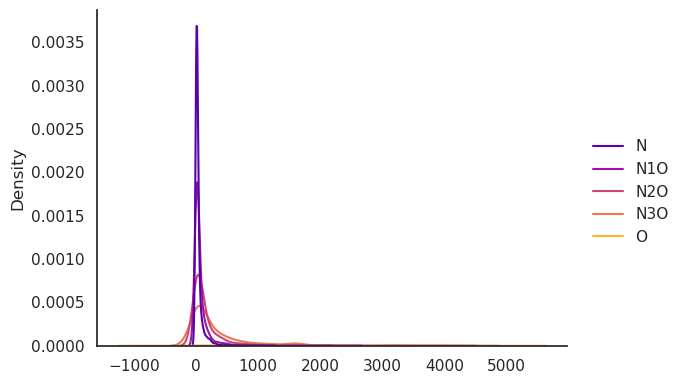

In [226]:
sns.displot(dict({"N": n_lic, "N1O": n1o_lic, "N2O": n2o_lic,"N3O": n3o_lic,"O": o_lic}),kind="kde", 
            height=4,
            aspect=1.5, palette="plasma")#hue=[cmap(i) for i in [0,0.2,0.4,0.6,0.8]])

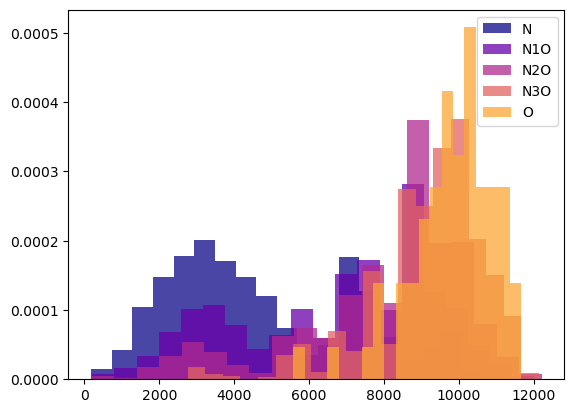

In [199]:
cmap = cm.get_cmap("plasma")

plt.hist(n_lcc, density=True, bins=20, alpha=0.75, color=cmap(0), label="N")
plt.hist(n1o_lcc, density=True, bins=20, alpha=0.75, color=cmap(0.2), label="N1O")
plt.hist(n2o_lcc, density=True, bins=20, alpha=0.75, color=cmap(0.4), label="N2O")
plt.hist(n3o_lcc, density=True, bins=20, alpha=0.75, color=cmap(0.6), label="N3O")
plt.hist(o_lcc, density=True, bins=20, alpha=0.75, color=cmap(0.8), label="O")

plt.legend()

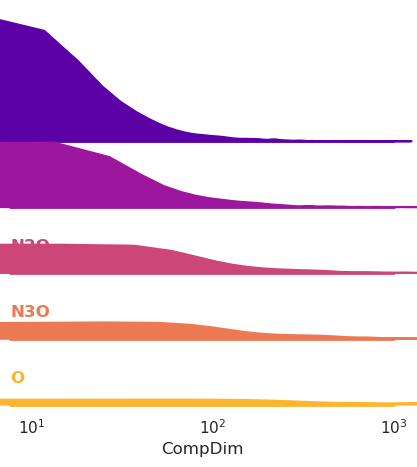

In [341]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

g = np.concatenate([["N"]*len(n_lic),
                    ["N1O"]*len(n1o_lic),
                    ["N2O"]*len(n2o_lic),
                    ["N3O"]*len(n3o_lic),
                    ["O"]*len(o_lic)])
                   
x = np.concatenate([n_lic, n1o_lic, n2o_lic, n3o_lic, o_lic])+1
df = pd.DataFrame(dict(CompDim=x, g=g))
pal = ["C0","green", "navy", "yellow", "purple", "maroon"]#sns.color_palette("bright", 7)
g = sns.FacetGrid(df, row="g", hue="g", aspect=5, height=1, palette="plasma")
g.map(sns.kdeplot, "CompDim",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)
    #ax.vlines(len(onco_lcc), 0 ,0.0018, ls="--", color="red")
g.map(label, "CompDim")
g.figure.subplots_adjust(hspace=-.5)
g.set_titles("")
g.set(yticks=[], ylabel="", xscale="log", xlim=[0,1000])
g.despine(bottom=True, left=True)

In [334]:
x

array([ 1., 58.,  7., ..., 41., 32., 33.])

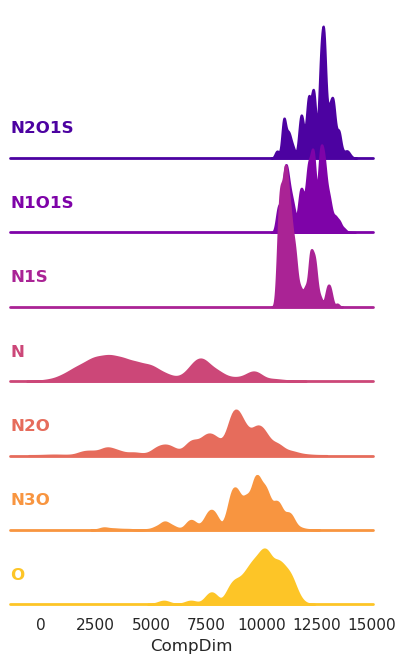

In [338]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

g = np.concatenate([["N2O1S"]*len(n2o1s_lcc),
                    ["N1O1S"]*len(n1o1s_lcc),
                    ["N1S"]*len(n1s_lcc),
                    ["N"]*len(n_lcc),
                   ["N1O"]*len(n1o_lcc),
                   ["N2O"]*len(n2o_lcc),
                   ["N3O"]*len(n3o_lcc),
                   ["O"]*len(o_lcc)])
                   
x = np.concatenate([n2o1s_lcc, n1o1s_lcc, n1s_lcc, n_lcc, n1o_lcc, n2o_lcc, n3o_lcc, o_lcc])
df = pd.DataFrame(dict(CompDim=x, g=g))
pal = ["C0","green", "navy", "yellow", "purple", "maroon"]#sns.color_palette("bright", 7)
g = sns.FacetGrid(df, row="g", hue="g", aspect=5, height=1, palette="plasma")
g.map(sns.kdeplot, "CompDim",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)
    #ax.vlines(len(onco_lcc), 0 ,0.0018, ls="--", color="red")
g.map(label, "CompDim")
g.figure.subplots_adjust(hspace=-.5)
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)